## Data Downloading and preprocessing

In [ ]:
# @title Kaggle Competition Data Downloading  { display-mode: "form",run :"auto" }
# @markdown Put the competition name

project_name = 'playground-series-s4e1'  # @param {type: "string"}


from google.colab import userdata
from IPython import display
token = {"username":userdata.get("Kaggle_Username"),"key":userdata.get("Kaggle")}
import os, json
os.environ['KAGGLE_CONFIG_DIR']='.'
with open('kaggle.json', "w") as f:
    json.dump(token, f)
!chmod 600 ./kaggle.json
!kaggle competitions download -c $project_name
project_name += ".zip"
!unzip $project_name && rm $project_name
username,token = userdata.get('MLFLOW_TRACKING_USERNAME'), userdata.get('MLFLOW_TRACKING_PASSWORD')
%env MLFLOW_TRACKING_USERNAME=$username
%env MLFLOW_TRACKING_PASSWORD=$token
display.clear_output()
print("Files have been downloaded!")

Files have been downloaded!


In [ ]:
!gdown 1TirpUEzc7Qg0ioKY1gpwZd7BZTTp3p8C

Downloading...
From: https://drive.google.com/uc?id=1TirpUEzc7Qg0ioKY1gpwZd7BZTTp3p8C
To: /content/Churn_Modelling.csv
100% 685k/685k [00:00<00:00, 6.40MB/s]


In [ ]:
!pip install optuna-dashboard optuna
!pip install catboost
!pip install mlflow dagshub
!mkdir output
display.clear_output()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import anderson,kstest, shapiro
from IPython.display import Audio,display as dis
from IPython.display import clear_output

from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import (confusion_matrix, accuracy_score,
                             precision_score, f1_score, recall_score,
                             classification_report,
                             roc_auc_score, roc_curve, auc,
                             )

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier

from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import VALID_METRICS

from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import (AdaBoostClassifier, ExtraTreesClassifier,
                              BaggingClassifier, RandomForestClassifier,
                              GradientBoostingClassifier,
                              HistGradientBoostingClassifier,
                              StackingClassifier
                              )
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier, XGBRFClassifier
from catboost import CatBoostClassifier

In [ ]:
import optuna

In [ ]:
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import plotly.offline as pyo
import plotly.io as pio
pio.renderers.default = "colab"
pyo.init_notebook_mode()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import dagshub
import mlflow

dagshub.init("BankChurnDataset-Kaggle", "SantanuK", mlflow=True)

❗❗❗ AUTHORIZATION REQUIRED ❗❗❗

Output()



Open the following link in your browser to authorize the client:
https://dagshub.com/login/oauth/authorize?state=7673e45c-6a89-4b8b-8a7f-d54fe4dd4728&client_id=32b60ba385aa7cecf24046d8195a71c07dd345d9657977863b52e7748e0f0f28&middleman_request_id=72f33fca201cb07ab84ad3aa778e5f3ce4917eeec73fa709fb6fcbf3b3814b44




Repository initialized!

## Defined Custom functions

In [ ]:
def preprocessing_method_1(dataframe,train=True):

    temp = pd.pivot_table(dataframe,values='Exited',index=['id'],
            columns=['Geography'],aggfunc='count',fill_value=0).reset_index()
    temp.columns = ['id', 'Is_France', 'Is_Germany', 'Is_Spain']

    df = pd.merge(dataframe, temp, on='id').drop('Exited', axis=1)

    df['Gender_F'] = df['Gender'].map({'Female':1,"Male":0})

    temp = pd.pivot_table(dataframe,values='Exited',index=['id'],
        columns=['NumOfProducts'],aggfunc='count',fill_value=0).reset_index()
    temp.columns = ['id', 'No_prd_1', 'No_prd_2', 'No_prd_3', 'No_prd_4']
    df = pd.merge(df, temp, on='id')

    temp = pd.pivot_table(dataframe,values='Exited',index=['id'],
        columns=['Tenure'],aggfunc='count',fill_value=0).reset_index()
    temp.columns = ['id', 'Tenure_0', 'Tenure_1', 'Tenure_2', 'Tenure_3',
                    'Tenure_4', 'Tenure_5', 'Tenure_6', 'Tenure_7',
                    'Tenure_8', 'Tenure_9', 'Tenure_10',
                    ]
    df = pd.merge(df, temp, on='id')

    drop_cols = set(['id', 'CustomerId', 'Surname', 'Geography',
                     'Gender', 'NumOfProducts','Tenure']).intersection(df.columns)
    df['Exited'] = dataframe['Exited']
    if train:
        return df.drop(drop_cols, axis=1).drop_duplicates()
    else:
        return df.drop(drop_cols, axis=1)

def create_binary_columns(dataframe, column_names, create_new=True):
    df = dataframe.drop('Exited', axis=1)
    for name in set(column_names):
        unique_keys = list(df[name].unique())
        unique_vals = list(range(len(unique_keys)))

        if create_new and len(unique_vals)>2:
            unique_cols = None
            if type(unique_keys[0])!=str:
                unique_cols = [ f"{name}_{i}" for i in unique_vals]
            else:
                unique_cols = [ f"Is_{i}" for i in unique_keys]

            for i,cols in enumerate(unique_cols):
                df[cols] = df[name].apply(lambda x: 1 if x==unique_keys[i] else 0)
            df.drop(name,axis=1)
        else:
            df[name] = df[name].map(dict(zip(unique_keys, unique_vals)))
    df['Exited'] = dataframe['Exited']
    return df

def preprocessing_method_2(dataframe):
    df = dataframe.copy()
    df['Geography'] = df['Geography'].map({'France':1,'Germany':2,'Spain':3})
    df['Gender'] = df['Gender'].map({'Female':1,"Male":0})
    drop_cols = set(['id', 'CustomerId', 'Surname',]).intersection(df.columns)

    return df.drop(drop_cols, axis=1).drop_duplicates()


def get_feature_importance(model):
    feature_importance = pd.DataFrame()
    feature_importance['Feature'] = model.feature_name()
    feature_importance['Importance'] = model.feature_importance()

    # Normalize feature importance scores to range [0, 1]
    feature_importance['Normalized_Importance'] = (feature_importance['Importance'] - feature_importance['Importance'].min()) / (feature_importance['Importance'].max() - feature_importance['Importance'].min())

    # Sort features based on importance
    feature_importance = feature_importance.sort_values(by='Normalized_Importance', ascending=False)

    # Visualize feature importance with color gradient
    plt.figure(figsize=(10, 8))
    sns.barplot(x='Normalized_Importance', y='Feature', data=feature_importance, palette='RdYlBu')
    plt.title('Feature Importance')
    plt.xlabel('Normalized Importance')
    plt.ylabel('Feature')
    plt.show()
    return feature_importance

def plot_auc_roc(clf, X,Y):
    y_prob = clf.predict_proba(X)[:, 1]
    roc_auc = roc_auc_score(Y, y_prob)
    print(f"AUC-ROC: {roc_auc}")

    # Plot the ROC curve
    fpr, tpr, _ = roc_curve(Y, y_prob)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'AUC-ROC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

def plot_auc(clf, X,Y):
    # Calculate y_pred
    y_pred = clf.predict(X)
    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(Y, y_pred)

    # Calculate AUC (Area Under the Curve)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

def score(X,Y,clf):
    y_prob = clf.predict(np.array(X))
    roc_auc = roc_auc_score(Y, y_prob)
    print(f"AUC-ROC: {roc_auc}")

    # Plot the ROC curve
    fpr, tpr, _ = roc_curve(Y, y_prob)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'AUC-ROC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

def beep(output_file='output.wav'):
    dis(Audio(output_file,autoplay=True))

In [ ]:
df_train = pd.read_csv("train.csv")
df_extra = pd.read_csv("Churn_Modelling.csv").drop_duplicates()
df_extra.columns = df_train.columns
df_test = pd.read_csv('test.csv')

In [ ]:
df_test[df_test.duplicated()]

## Data Viz-1

In [ ]:
select_cols = ['Age', 'CreditScore', 'EstimatedSalary', 'Balance','Tenure', 'NumOfProducts','Exited']
description = df_train.describe(percentiles=[.1, .25,.33,.67,.75,.9])[select_cols].T
description['IQR'] = description['75%'] - description['25%']
description['Low'] = description['25%'] - 1.5* description['IQR']
description['High'] = description['75%'] + 1.5* description['IQR']
description

,count,mean,std,min,10%,25%,33%,50%,67%,75%,90%,max,IQR,Low,High
Age,165034.0,38.125888,8.867205,18.00,28.000,32.00,34.00,37.0,40.0000,42.0000,50.00,92.00,10.0000,17.00000,57.00000
CreditScore,165034.0,656.454373,80.103340,350.00,554.000,597.00,623.00,659.0,694.0000,710.0000,754.00,850.00,113.0000,427.50000,879.50000
EstimatedSalary,165034.0,112574.822734,50292.865585,11.58,44965.443,74637.57,87959.83,117948.0,142566.7144,155152.4675,176843.53,199992.48,80514.8975,-46134.77625,275924.81375
Balance,165034.0,55478.086689,62817.663278,0.00,0.000,0.00,0.00,0.0,107065.3100,119939.5175,139959.05,250898.09,119939.5175,-179909.27625,299848.79375
Tenure,165034.0,5.020353,2.806159,0.00,1.000,3.00,3.00,5.0,7.0000,7.0000,9.00,10.00,4.0000,-3.00000,13.00000
NumOfProducts,165034.0,1.554455,0.547154,1.00,1.000,1.00,1.00,2.0,2.0000,2.0000,2.00,4.00,1.0000,-0.50000,3.50000
Exited,165034.0,0.211599,0.408443,0.00,0.000,0.00,0.00,0.0,0.0000,0.0000,1.00,1.00,0.0000,0.00000,0.00000


In [ ]:
list(range(350,851,50))

[350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850]

In [ ]:
df = preprocessing_method_2(df_train).reset_index(drop=True)
# df = preprocessing_method_1(df_extra)
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,668,1,0,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,627,1,0,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,678,1,0,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,581,1,0,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,716,3,0,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [ ]:
df.columns

Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Exited'],
      dtype='object')

In [ ]:
df['Exited'].value_counts()/len(df)

0    0.788316
1    0.211684
Name: Exited, dtype: float64

In [64]:
base_scaler = MinMaxScaler()
df_copy = pd.DataFrame(base_scaler.fit_transform(df))
df_copy.columns = df.columns
df_copy.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0.636,0.0,0.0,0.202703,0.3,0.000000,0.333333,1.0,0.0,0.907279,0.0
1,0.554,0.0,0.0,0.202703,0.1,0.000000,0.333333,1.0,1.0,0.247483,0.0
2,0.656,0.0,0.0,0.297297,1.0,0.000000,0.333333,1.0,0.0,0.924364,0.0
3,0.462,0.0,0.0,0.216216,0.2,0.593398,0.000000,1.0,1.0,0.422787,0.0
4,0.732,1.0,0.0,0.202703,0.5,0.000000,0.333333,1.0,1.0,0.075293,0.0


## Cluster - 1

In [65]:
num_clusters = list(np.arange(2,11))
inertia_list = []
cluster_cols = [
                # 'CreditScore', 'Age',
                'Balance', 'EstimatedSalary'
                ]
# train_cols = df.columns
train_x = np.array(df_copy[cluster_cols])
"""
for i in num_clusters:
    model = KMeans(n_clusters=i,n_init= 3, max_iter=1000,random_state=151)
    model.fit(train_x)
    inertia_list.append(model.inertia_)

plt.plot(num_clusters, inertia_list)
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.grid()
plt.show()
"""

'\nfor i in num_clusters:\n    model = KMeans(n_clusters=i,n_init= 3, max_iter=1000,random_state=151)\n    model.fit(train_x)\n    inertia_list.append(model.inertia_)\n\nplt.plot(num_clusters, inertia_list)\nplt.xlabel("Number of clusters")\nplt.ylabel("Inertia")\nplt.grid()\nplt.show()\n'

In [66]:
n_clusters=4
cluster_model = KMeans(n_clusters=n_clusters,n_init= 4, max_iter=1000,random_state=151)
cluster_model.fit(train_x)

KMeans(max_iter=1000, n_clusters=4, n_init=4, random_state=151)

In [67]:
df_copy['Label'] = cluster_model.labels_
df['Label'] = cluster_model.labels_

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but KMeans was fitted with feature names



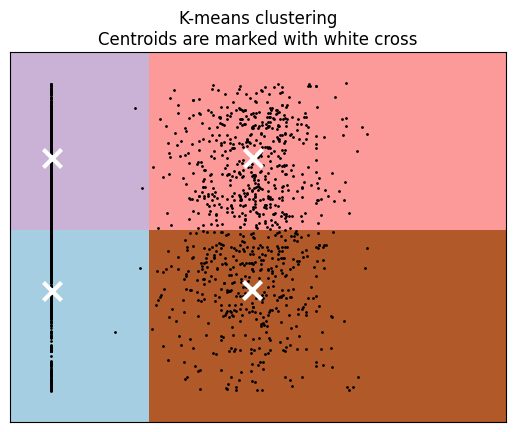

In [ ]:
# Step size of the mesh. Decrease to increase the quality of the VQ.
h = 0.05  # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = train_x[:, 0].min() - .1, train_x[:, 0].max() + .1
y_min, y_max = train_x[:, 1].min() - .1, train_x[:, 1].max() + .1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = cluster_model.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Paired,
    aspect="auto",
    origin="lower",
)
# colormap = {0: 'k.',1: 'g.', 2: 'b.', 3: 'r.' }
# colors = [colormap[label] for label in cluster_model.labels_]
plt.plot(train_x[:, 0][:2000], train_x[:, 1][:2000], 'k.',markersize=2)
# Plot the centroids as a white X
centroids = cluster_model.cluster_centers_
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker="x",
    s=169,
    linewidths=3,
    color="w",
    zorder=10,
)
plt.title(
    "K-means clustering\n"
    "Centroids are marked with white cross"
)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

In [ ]:
df_copy.groupby(by=['Label','Exited'])[['Exited']].count()

Exited
Label Exited        
0     0.0      34652
      1.0       6407
1     0.0      29513
      1.0      11390
2     0.0      40954
      1.0       8299
3     0.0      24883
      1.0       8813

In [ ]:
temp = df_copy.groupby(by=['Label'])[['Exited']].count()
temp_ = df_copy.groupby(by=['Label','Exited'])[['Exited']].count()
temp_['Exited'] /= np.array([ [i, i ]for i in temp['Exited']]).flatten()
temp_

Exited
Label Exited          
0     0.0     0.843956
      1.0     0.156044
1     0.0     0.721536
      1.0     0.278464
2     0.0     0.831503
      1.0     0.168497
3     0.0     0.738456
      1.0     0.261544

In [ ]:
df[df['Label']==0].describe(percentiles=[.25, .5, .75, .90, .99])[cluster_cols].T

,count,mean,std,min,25%,50%,75%,90%,99%,max
Balance,41059.0,431.881963,4784.028648,0.00,0.00,0.0,0.00,0.00,0.0000,61710.44
EstimatedSalary,41059.0,65096.766722,29521.495346,90.07,47786.72,70810.6,89248.99,100408.31,107615.4426,108162.13


In [ ]:
df[df['Label']==1].describe(percentiles=[.25, .5, .75, .90, .99])[cluster_cols].T

,count,mean,std,min,25%,50%,75%,90%,99%,max
Balance,40903.0,122293.818270,24036.782588,61297.05,105770.190,122570.69,137933.05,152522.47,181625.2866,238387.56
EstimatedSalary,40903.0,151760.276202,23955.354159,108739.15,131501.495,151677.31,172501.38,182765.14,198490.0900,199992.48


In [ ]:
df[df['Label']==2].describe(percentiles=[.25, .5, .75, .90, .99])[cluster_cols].T

,count,mean,std,min,25%,50%,75%,90%,99%,max
Balance,49253.0,410.276617,4700.904455,0.00,0.00,0.00,0.00,0.00,0.00,61354.14
EstimatedSalary,49253.0,151439.315776,23661.244794,108301.45,131553.82,151316.37,171681.86,182566.76,198446.91,199992.48


In [ ]:
df[df['Label']==3].describe(percentiles=[.25, .5, .75, .90, .99])[cluster_cols].T

,count,mean,std,min,25%,50%,75%,90%,99%,max
Balance,33696.0,121952.933933,24267.021969,61172.04,105763.8150,122214.00,137780.3425,152522.565,181554.261,250898.09
EstimatedSalary,33696.0,66077.510417,28641.439950,11.58,49415.1175,71071.47,89520.7425,101089.760,107876.910,108891.20


## Trial - 1

In [ ]:
# scaler_2 = MinMaxScaler()
# Xtrain = scaler_2.fit_transform(df_copy.drop(['Exited', 'Label'], axis=1))
Xtrain = df_copy.drop(['Exited', 'Label'], axis=1)
ytrain = df_copy['Exited']

In [134]:
# Define the objective function for Optuna
def objective(trial, X_train, Y_train):
    factor = trial.suggest_float('factor', 1, 100,log=True)

    params = {
        # 'n_estimators'      : trial.suggest_int('n_estimators', 100, 200, log=True),
        'boosting_type'     : trial.suggest_categorical('boosting_type',
                                                    ['gbdt', 'rf', 'dart']),
        'num_leaves'        : trial.suggest_int('num_leaves', 8, 64, log=True),
        'max_depth'         : trial.suggest_categorical('max_depth', [-1, 3, 4, 5, 6]),
        'learning_rate'     : trial.suggest_float('learning_rate', 0.01, 1,log=True),
        'objective'         : trial.suggest_categorical('objective', ['binary'] ),
        'class_weight'      : {0: 1, 1: factor},

        'min_split_gain'    : trial.suggest_categorical('min_split_gain', [0, 1e-4, 1e-3, 1e-1] ),
        'min_child_samples' : trial.suggest_categorical('min_child_samples', [10, 15, 20, 25, 30] ),
        'colsample_bytree'  : trial.suggest_float('colsample_bytree', .4, 1.0, log=True),
        'reg_alpha'         : trial.suggest_float('reg_alpha', 0.001, 1, log=True),
        'reg_lambda'        : trial.suggest_float('reg_lambda', 0.001, 1, log=True ),
        'importance_type'   : trial.suggest_categorical('importance_type', ['split', 'gain'] ),

        # previously used features
        # 'colsample_bytree' : trial.suggest_categorical('colsample_bytree',[ .4, .5, .67, .75, .9, 1.0]),

    }
    clf = LGBMClassifier(random_state=42,verbose=0, **params)
    Xtrain, Xtest, ytrain, ytest = train_test_split(X_train,Y_train, test_size=.3,random_state= 131)
    roc_auc, diff = 0, -np.inf
    try:
        clf.fit(Xtrain, ytrain);
        y_prob = clf.predict_proba(Xtrain)[:, 1]
        roc_auc = roc_auc_score(ytrain, y_prob)
        diff = roc_auc_score(ytest, clf.predict_proba(Xtest)[:, 1]) - roc_auc
    except Exception as e:
        print(e)

    return roc_auc, diff


In [ ]:
Xtrain.loc[1]

CreditScore        0.554000
Geography          0.000000
Gender             0.000000
Age                0.202703
Tenure             0.100000
Balance            0.000000
NumOfProducts      0.333333
HasCrCard          1.000000
IsActiveMember     1.000000
EstimatedSalary    0.247483
Name: 1, dtype: float64

In [ ]:
# indices = df_copy[df_copy['Label']==0].index
# Xtrain.iloc[indices], ytrain.iloc[indices]

In [ ]:
studies = []
clusters_ = list(range(n_clusters))
# clusters_ = [1, 3]
for i in clusters_:
    indices = df_copy[df_copy['Label']==i].index
    # Create an Optuna study and optimize the objective function
    study = optuna.create_study(directions= ['maximize',  'maximize'] )
    study.optimize(lambda trial: objective(trial,Xtrain.iloc[indices], ytrain.iloc[indices]), n_trials=500)

    studies.append(study)

Output hidden; open in https://colab.research.google.com to view.

### sub-trial - 1

In [ ]:
df_train[(df_train['Balance']==0)&(df_train['Exited']==1)].describe().T

In [ ]:
df_train[(df_train['Exited']==1)].describe().T

In [49]:
def preprocessing_method_3(dataframe):
    df = dataframe.drop('Exited', axis=1)
    # Encoding geography and gender data
    df['Geography'] = df['Geography'].map({'France':0,'Germany':1,'Spain':2})
    df['Gender'] = df['Gender'].map({'Female':1,"Male":0})
    drop_cols = set(['id', 'CustomerId', 'Surname',]).intersection(df.columns)

    # creating credit score bins
    credit_bins = list(range(350,851,50))
    credit_labels = list(range(len(credit_bins)-1))
    df['Credit_bins'] = pd.cut(df['CreditScore'], bins = credit_bins, labels = credit_labels, include_lowest=True)

    # creating bins for age
    age_bins = [18, 24, 30, 45, 60, 92]
    age_labels = list(range(len(age_bins)-1))
    df['Age_bins'] = pd.cut(df['Age'], bins = age_bins, labels = age_labels, include_lowest=True)

    # creating bins for salary
    salary_bins = [0, 10000, 25000, 50000, 75000, 100000, 150000, 200000]
    salary_labels = list(range(len(salary_bins)-1))
    df['Salary_bins'] = pd.cut(df['EstimatedSalary'], bins = salary_bins, labels = salary_labels, include_lowest=True)

    # creating bins for balance
    balance_bins = [0, 10000, 50000, 100000, 150000, 175000, 200000, 225000, 251000]
    balance_labels = list(range(len(balance_bins)-1))
    df['Balance_bins'] = pd.cut(df['Balance'], bins = balance_bins, labels = balance_labels, include_lowest=True)

    df['IsBalance_0'] = df['Balance']==0
    # Interaction features
    df['Cr_Active'] = df['HasCrCard']*df['IsActiveMember']
    df['Gender_Cr_Active'] = 100*df['Gender'] + 10*df['HasCrCard']+df['IsActiveMember']

    df['Exp_Balance'] = df['EstimatedSalary']*(1-df['Age']/100)
    df['Exp_Balance_Total'] = df['Exp_Balance'] + df['Balance']/100

    df['Exited'] = dataframe['Exited']

    return df.drop(drop_cols, axis=1).drop_duplicates().reset_index(drop=True)

preprocessing_method_3(df_train).head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Credit_bins,Age_bins,Salary_bins,Balance_bins,IsBalance_0,Cr_Active,Gender_Cr_Active,Exp_Balance,Exp_Balance_Total,Exited
0,668,0,0,33.0,3,0.00,2,1.0,0.0,181449.97,6,2,6,0,True,0.0,10.0,121571.4799,121571.4799,0
1,627,0,0,33.0,1,0.00,2,1.0,1.0,49503.50,5,2,2,0,True,1.0,11.0,33167.3450,33167.3450,0
2,678,0,0,40.0,10,0.00,2,1.0,0.0,184866.69,6,2,6,0,True,0.0,10.0,110920.0140,110920.0140,0
3,581,0,0,34.0,2,148882.54,1,1.0,1.0,84560.88,4,2,4,3,False,1.0,11.0,55810.1808,57299.0062,0
4,716,2,0,33.0,5,0.00,2,1.0,1.0,15068.83,7,2,1,0,True,1.0,11.0,10096.1161,10096.1161,0


In [50]:
scaler =  MinMaxScaler()
numerical_cols = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary',
                  'Exp_Balance',  ]
categorical_cols = ['Geography', 'Gender', 'Tenure', 'NumOfProducts',
                    'HasCrCard', 'IsActiveMember', 'Credit_bins', 'Age_bins',
                    'Salary_bins', 'Balance_bins', 'IsBalance_0', 'Cr_Active',
                    'Gender_Cr_Active' , ]
df_processed = preprocessing_method_3(df_train)
df_processed[categorical_cols] = df_processed[categorical_cols].astype(int)
df_scaled = pd.DataFrame(scaler.fit_transform(df_processed[numerical_cols]))
df_scaled.columns = numerical_cols
df_merged = pd.concat([df_scaled, df_processed[categorical_cols]], axis=1)
df_merged['Exited'] = df_processed['Exited']

In [69]:
df_merged_label = df_merged.copy()
df_merged_label['Label'] = cluster_model.predict(df_merged_label[cluster_cols])

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but KMeans was fitted without feature names



In [135]:
studies = []
clusters_ = list(range(n_clusters))
# clusters_ = [1, 3]
for i in clusters_:
    indices = df_merged_label[df_merged_label['Label']==i].index
    # Create an Optuna study and optimize the objective function
    study = optuna.create_study(directions= ['maximize',  'maximize'] )
    study.optimize(lambda trial: objective(trial,df_merged.drop('Exited',axis=1).iloc[indices],df_merged['Exited'][indices]), n_trials=500)

    studies.append(study)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
label_1 = df_merged_label[df_merged_label['Label']==3].drop('Label', axis=1)
sub_x = label_1.drop('Exited',axis=1)
sub_y = label_1['Exited']
_x1, _x2, _y1, _y2 = train_test_split(sub_x,sub_y, test_size=.25, random_state=131)
cbm = CatBoostClassifier(iterations=300, learning_rate = .010,cat_features = categorical_cols ,random_state=42)
obj = cbm.fit(_x1, _y1)
roc_auc_score(_y1,cbm.predict_proba(_x1)[:,1]), roc_auc_score(_y2,cbm.predict_proba(_x2)[:,1])

In [ ]:
study = optuna.create_study(directions= ['maximize',  'maximize'] )
study.optimize(lambda trial: objective(trial,df_merged.drop('Exited',axis=1), df_merged['Exited']), n_trials=500)
studies = [study, ]

[I 2024-01-31 18:48:44,017] A new study created in memory with name: no-name-6c83d8cd-7d0e-480c-ad79-6e4bf388f905


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002216 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.784456 -> initscore=1.291828
[LightGBM] [Info] Start training from score 1.291828


[I 2024-01-31 18:48:46,144] Trial 0 finished with values: [0.8860817286928909, -0.0030086157447322126] and parameters: {'factor': 13.648965228354449, 'boosting_type': 'gbdt', 'num_leaves': 33, 'max_depth': -1, 'learning_rate': 0.024300480770008244, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 20, 'colsample_bytree': 0.4451827886173234, 'reg_alpha': 0.003714409059642249, 'reg_lambda': 0.4443284340783164, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004383 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.751452 -> initscore=1.106371
[LightGBM] [Info] Start training from score 1.106371


[I 2024-01-31 18:48:49,855] Trial 1 finished with values: [0.8921812032439653, -0.002590911710515398] and parameters: {'factor': 11.338527462011774, 'boosting_type': 'dart', 'num_leaves': 10, 'max_depth': 6, 'learning_rate': 0.35065422124275225, 'objective': 'binary', 'min_split_gain': 0.0001, 'min_child_samples': 20, 'colsample_bytree': 0.957520718090163, 'reg_alpha': 0.0029218661290388373, 'reg_lambda': 0.028395764141402404, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002550 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.960808 -> initscore=3.199298
[LightGBM] [Info] Start training from score 3.199298


[I 2024-01-31 18:48:50,946] Trial 2 finished with values: [0.8634833863261309, 0.0004091149830431906] and parameters: {'factor': 91.93976906863095, 'boosting_type': 'rf', 'num_leaves': 19, 'max_depth': 3, 'learning_rate': 0.016207256515230584, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 30, 'colsample_bytree': 0.5175441698855044, 'reg_alpha': 0.3569155107991836, 'reg_lambda': 0.3379604390550126, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004377 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.331076 -> initscore=-0.703324
[LightGBM] [Info] Start training from score -0.703324


[I 2024-01-31 18:48:53,912] Trial 3 finished with values: [0.8875393506840301, -0.00010383579390871311] and parameters: {'factor': 1.8561622661867625, 'boosting_type': 'dart', 'num_leaves': 26, 'max_depth': 3, 'learning_rate': 0.19742065153135532, 'objective': 'binary', 'min_split_gain': 0.0001, 'min_child_samples': 10, 'colsample_bytree': 0.9296669902543117, 'reg_alpha': 0.061289283074569614, 'reg_lambda': 0.11848872815457938, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002213 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.951763 -> initscore=2.982179
[LightGBM] [Info] Start training from score 2.982179
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-01-31 18:48:55,354] Trial 4 finished with values: [0.8991177963221765, -0.015743061116035628] and parameters: {'factor': 73.99624994889933, 'boosting_type': 'gbdt', 'num_leaves': 15, 'max_depth': 4, 'learning_rate': 0.4395644878000666, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 0.43189865630777996, 'reg_alpha': 0.0024878166263631735, 'reg_lambda': 0.0029962404642352616, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004363 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.337222 -> initscore=-0.675699
[LightGBM] [Info] Start training from score -0.675699


[I 2024-01-31 18:48:57,036] Trial 5 finished with values: [0.8837408793619603, -0.0003420858781576497] and parameters: {'factor': 1.908154802101399, 'boosting_type': 'gbdt', 'num_leaves': 23, 'max_depth': 6, 'learning_rate': 0.013606251035156103, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 15, 'colsample_bytree': 0.941021667788507, 'reg_alpha': 0.007928317521140817, 'reg_lambda': 0.06117079471783348, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002815 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.935460 -> initscore=2.673752
[LightGBM] [Info] Start training from score 2.673752
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-01-31 18:49:01,276] Trial 6 finished with values: [0.898544775900108, -0.012906406347266808] and parameters: {'factor': 54.35777850774412, 'boosting_type': 'dart', 'num_leaves': 17, 'max_depth': 5, 'learning_rate': 0.7971491507834997, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 20, 'colsample_bytree': 0.5606986061035136, 'reg_alpha': 0.029215806878019, 'reg_lambda': 0.576510232798519, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003691 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.933085 -> initscore=2.635071
[LightGBM] [Info] Start training from score 2.635071
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

[I 2024-01-31 18:49:02,548] Trial 7 finished with values: [0.880865541083469, -0.00031274798122238323] and parameters: {'factor': 52.29530977775882, 'boosting_type': 'gbdt', 'num_leaves': 28, 'max_depth': 3, 'learning_rate': 0.03373980514807848, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 30, 'colsample_bytree': 0.6903135463781792, 'reg_alpha': 0.9248740713592919, 'reg_lambda': 0.24442331589528415, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004502 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.884162 -> initscore=2.032443
[LightGBM] [Info] Start training from score 2.032443


[I 2024-01-31 18:49:03,992] Trial 8 finished with values: [0.8690760919877355, -0.00046738482869068676] and parameters: {'factor': 28.624934767414942, 'boosting_type': 'rf', 'num_leaves': 26, 'max_depth': 5, 'learning_rate': 0.588379353476469, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 25, 'colsample_bytree': 0.9862437007430779, 'reg_alpha': 0.0027337276654786132, 'reg_lambda': 0.5958901651283647, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003750 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.387912 -> initscore=-0.456098
[LightGBM] [Info] Start training from score -0.456098


[I 2024-01-31 18:49:05,603] Trial 9 finished with values: [0.8819317391387492, 9.265459168350532e-05] and parameters: {'factor': 2.3767587373658903, 'boosting_type': 'gbdt', 'num_leaves': 47, 'max_depth': 4, 'learning_rate': 0.018722704387179295, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 20, 'colsample_bytree': 0.6545602859644831, 'reg_alpha': 0.0014583084447203612, 'reg_lambda': 0.2315911155616385, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004129 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.237994 -> initscore=-1.163708
[LightGBM] [Info] Start training from score -1.163708


[I 2024-01-31 18:49:07,227] Trial 10 finished with values: [0.8788856008899996, -0.000499260663429979] and parameters: {'factor': 1.1713148054113862, 'boosting_type': 'rf', 'num_leaves': 34, 'max_depth': 6, 'learning_rate': 0.06816018625566252, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 20, 'colsample_bytree': 0.7822250056440515, 'reg_alpha': 0.00203468413990778, 'reg_lambda': 0.0017259444327906242, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002517 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.848169 -> initscore=1.720312
[LightGBM] [Info] Start training from score 1.720312


[I 2024-01-31 18:49:09,290] Trial 11 finished with values: [0.8785078361655512, -0.0013352286493291121] and parameters: {'factor': 20.950174944906337, 'boosting_type': 'rf', 'num_leaves': 47, 'max_depth': 6, 'learning_rate': 0.4345798625350999, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 20, 'colsample_bytree': 0.5243973554690948, 'reg_alpha': 0.1470099960611111, 'reg_lambda': 0.1662575479289123, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002190 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547021 -> initscore=0.188640
[LightGBM] [Info] Start training from score 0.188640


[I 2024-01-31 18:49:10,999] Trial 12 finished with values: [0.8889239856807143, -0.0006633802854819626] and parameters: {'factor': 4.528884060755407, 'boosting_type': 'gbdt', 'num_leaves': 8, 'max_depth': 6, 'learning_rate': 0.09127804469314983, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 25, 'colsample_bytree': 0.46306056212643937, 'reg_alpha': 0.7804326532104927, 'reg_lambda': 0.13484280295626036, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003982 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.643915 -> initscore=0.592398
[LightGBM] [Info] Start training from score 0.592398
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

[I 2024-01-31 18:49:12,734] Trial 13 finished with values: [0.8758476822797583, -0.00015545075703948807] and parameters: {'factor': 6.781741136953114, 'boosting_type': 'rf', 'num_leaves': 40, 'max_depth': 5, 'learning_rate': 0.0112391880024583, 'objective': 'binary', 'min_split_gain': 0.0001, 'min_child_samples': 20, 'colsample_bytree': 0.7313001536820395, 'reg_alpha': 0.03346494863727205, 'reg_lambda': 0.03964815603604545, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002584 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.942086 -> initscore=2.789129
[LightGBM] [Info] Start training from score 2.789129


[I 2024-01-31 18:49:14,626] Trial 14 finished with values: [0.8831426557058532, -0.001822544466237086] and parameters: {'factor': 61.00554956939833, 'boosting_type': 'gbdt', 'num_leaves': 25, 'max_depth': -1, 'learning_rate': 0.013140319824945887, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 20, 'colsample_bytree': 0.49267974966845096, 'reg_alpha': 0.024756402803998774, 'reg_lambda': 0.03299470348396209, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004233 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.693907 -> initscore=0.818450
[LightGBM] [Info] Start training from score 0.818450


[I 2024-01-31 18:49:18,314] Trial 15 finished with values: [0.8782486635673313, -3.446651451910476e-05] and parameters: {'factor': 8.501865251379666, 'boosting_type': 'dart', 'num_leaves': 42, 'max_depth': 4, 'learning_rate': 0.04571940472713738, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 0.8818140374616259, 'reg_alpha': 0.15883480166083166, 'reg_lambda': 0.0042475451371611515, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002569 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.715738 -> initscore=0.923420
[LightGBM] [Info] Start training from score 0.923420


[I 2024-01-31 18:49:19,391] Trial 16 finished with values: [0.8665029825566086, 0.0006430109113761961] and parameters: {'factor': 9.442827967304355, 'boosting_type': 'rf', 'num_leaves': 20, 'max_depth': 3, 'learning_rate': 0.7682002768374936, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 0.5162177990937002, 'reg_alpha': 0.0013316589638252125, 'reg_lambda': 0.10094549820749771, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004384 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.838829 -> initscore=1.649543
[LightGBM] [Info] Start training from score 1.649543


[I 2024-01-31 18:49:20,462] Trial 17 finished with values: [0.855350343452294, -1.2597250178991715e-05] and parameters: {'factor': 19.518805538178242, 'boosting_type': 'rf', 'num_leaves': 26, 'max_depth': 3, 'learning_rate': 0.09688046911429621, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 20, 'colsample_bytree': 0.8948982818749806, 'reg_alpha': 0.044288524972034796, 'reg_lambda': 0.17645979819438418, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002157 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.348787 -> initscore=-0.624376
[LightGBM] [Info] Start training from score -0.624376


[I 2024-01-31 18:49:22,721] Trial 18 finished with values: [0.8757711523610254, -0.0008748898885584389] and parameters: {'factor': 2.0086436763937185, 'boosting_type': 'rf', 'num_leaves': 52, 'max_depth': 6, 'learning_rate': 0.07570143881664222, 'objective': 'binary', 'min_split_gain': 0.0001, 'min_child_samples': 20, 'colsample_bytree': 0.40243160048700494, 'reg_alpha': 0.008312714588442566, 'reg_lambda': 0.005036675195933144, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018780 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.419040 -> initscore=-0.326716
[LightGBM] [Info] Start training from score -0.326716


[I 2024-01-31 18:49:23,872] Trial 19 finished with values: [0.9017677792857972, -0.017806229725289224] and parameters: {'factor': 2.7050474257695103, 'boosting_type': 'gbdt', 'num_leaves': 10, 'max_depth': 5, 'learning_rate': 0.7427578233218557, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 30, 'colsample_bytree': 0.5447503454182423, 'reg_alpha': 0.029045625466172884, 'reg_lambda': 0.006466379884172853, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003723 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339263 -> initscore=-0.666581
[LightGBM] [Info] Start training from score -0.666581


[I 2024-01-31 18:49:24,996] Trial 20 finished with values: [0.8659286339612445, -0.0010146478703488837] and parameters: {'factor': 1.9256318945250208, 'boosting_type': 'rf', 'num_leaves': 9, 'max_depth': 6, 'learning_rate': 0.04301988348517185, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 30, 'colsample_bytree': 0.694381517372788, 'reg_alpha': 0.23402199807747667, 'reg_lambda': 0.8417794557887897, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002216 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.658659 -> initscore=0.657325
[LightGBM] [Info] Start training from score 0.657325


[I 2024-01-31 18:49:27,852] Trial 21 finished with values: [0.8918861659030018, -0.003703429141220127] and parameters: {'factor': 7.236665251500446, 'boosting_type': 'dart', 'num_leaves': 8, 'max_depth': 4, 'learning_rate': 0.7391397754794039, 'objective': 'binary', 'min_split_gain': 0.0001, 'min_child_samples': 25, 'colsample_bytree': 0.4280650252618889, 'reg_alpha': 0.002978256852857991, 'reg_lambda': 0.2027059313638958, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003989 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.210979 -> initscore=-1.319034
[LightGBM] [Info] Start training from score -1.319034


[I 2024-01-31 18:49:29,143] Trial 22 finished with values: [0.8710852176774844, -0.0005987678893387693] and parameters: {'factor': 1.002805752866319, 'boosting_type': 'rf', 'num_leaves': 16, 'max_depth': 4, 'learning_rate': 0.2165553710521619, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 15, 'colsample_bytree': 0.7792264118193218, 'reg_alpha': 0.004291133603398811, 'reg_lambda': 0.0043414568981319625, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004375 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.959674 -> initscore=3.169605
[LightGBM] [Info] Start training from score 3.169605
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-01-31 18:49:30,517] Trial 23 finished with values: [0.8906738109894647, -0.0026487227681801784] and parameters: {'factor': 89.2499337493615, 'boosting_type': 'gbdt', 'num_leaves': 12, 'max_depth': 3, 'learning_rate': 0.15435855274057414, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 30, 'colsample_bytree': 0.9234147587467241, 'reg_alpha': 0.015677287645131703, 'reg_lambda': 0.0183239641302627, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002198 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.944368 -> initscore=2.831766
[LightGBM] [Info] Start training from score 2.831766


[I 2024-01-31 18:49:31,888] Trial 24 finished with values: [0.8703301438216032, -5.3987489435525227e-05] and parameters: {'factor': 63.6628424894434, 'boosting_type': 'rf', 'num_leaves': 13, 'max_depth': 6, 'learning_rate': 0.05487557407786579, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 15, 'colsample_bytree': 0.4438613164804571, 'reg_alpha': 0.08002216327960636, 'reg_lambda': 0.24419245687648117, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002826 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.778345 -> initscore=1.256048
[LightGBM] [Info] Start training from score 1.256048
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

[I 2024-01-31 18:49:34,418] Trial 25 finished with values: [0.8805580853334803, -0.0014340601994369262] and parameters: {'factor': 13.169229440479393, 'boosting_type': 'rf', 'num_leaves': 59, 'max_depth': 6, 'learning_rate': 0.1720813811309943, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 30, 'colsample_bytree': 0.5376789967276778, 'reg_alpha': 0.006013652195878553, 'reg_lambda': 0.20608408964188818, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003771 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.255000 -> initscore=-1.072119
[LightGBM] [Info] Start training from score -1.072119


[I 2024-01-31 18:49:37,216] Trial 26 finished with values: [0.8677514939007862, -0.0007960650823972681] and parameters: {'factor': 1.2836607235588426, 'boosting_type': 'dart', 'num_leaves': 10, 'max_depth': 3, 'learning_rate': 0.013161564702088433, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 20, 'colsample_bytree': 0.5943887772274775, 'reg_alpha': 0.004436784714591946, 'reg_lambda': 0.0019613415949034565, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002558 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.955827 -> initscore=3.074464
[LightGBM] [Info] Start training from score 3.074464
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

[I 2024-01-31 18:49:39,169] Trial 27 finished with values: [0.8970202140200252, -0.009303938374711329] and parameters: {'factor': 81.14997347699529, 'boosting_type': 'gbdt', 'num_leaves': 45, 'max_depth': 5, 'learning_rate': 0.12268442060172645, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 30, 'colsample_bytree': 0.47395532762642606, 'reg_alpha': 0.07280339117595476, 'reg_lambda': 0.0034505157869610613, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004592 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.954559 -> initscore=3.044844
[LightGBM] [Info] Start training from score 3.044844


[I 2024-01-31 18:49:43,967] Trial 28 finished with values: [0.8774148536207907, 4.589536832988461e-05] and parameters: {'factor': 78.7816211067722, 'boosting_type': 'dart', 'num_leaves': 25, 'max_depth': 5, 'learning_rate': 0.025392802062930167, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 15, 'colsample_bytree': 0.9696041271822955, 'reg_alpha': 0.07985852483367809, 'reg_lambda': 0.055560062853575475, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003553 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.879736 -> initscore=1.989937
[LightGBM] [Info] Start training from score 1.989937


[I 2024-01-31 18:49:47,821] Trial 29 finished with values: [0.8734538893378816, -8.34804984140014e-05] and parameters: {'factor': 27.433693300287967, 'boosting_type': 'dart', 'num_leaves': 11, 'max_depth': 6, 'learning_rate': 0.020183839666345873, 'objective': 'binary', 'min_split_gain': 0.0001, 'min_child_samples': 30, 'colsample_bytree': 0.4379741193294892, 'reg_alpha': 0.05909689306745265, 'reg_lambda': 0.10423406134060749, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004576 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.842953 -> initscore=1.680369
[LightGBM] [Info] Start training from score 1.680369


[I 2024-01-31 18:49:48,949] Trial 30 finished with values: [0.8429325636329701, 0.00032512454753541586] and parameters: {'factor': 20.129872229771866, 'boosting_type': 'rf', 'num_leaves': 10, 'max_depth': 4, 'learning_rate': 0.11019675231736258, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 25, 'colsample_bytree': 0.9789482594683945, 'reg_alpha': 0.14332542122424682, 'reg_lambda': 0.037503710812570576, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003692 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.473939 -> initscore=-0.104339
[LightGBM] [Info] Start training from score -0.104339


[I 2024-01-31 18:49:52,213] Trial 31 finished with values: [0.8894338382892124, -0.0004278349788477964] and parameters: {'factor': 3.378719570125438, 'boosting_type': 'dart', 'num_leaves': 9, 'max_depth': 6, 'learning_rate': 0.22139089197318768, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 30, 'colsample_bytree': 0.597897878628882, 'reg_alpha': 0.01419480289482043, 'reg_lambda': 0.0015606091607511328, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002829 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.949643 -> initscore=2.936941
[LightGBM] [Info] Start training from score 2.936941


[I 2024-01-31 18:49:56,384] Trial 32 finished with values: [0.9111742032834976, -0.04185832974492343] and parameters: {'factor': 70.72336347496015, 'boosting_type': 'dart', 'num_leaves': 31, 'max_depth': -1, 'learning_rate': 0.9457897552094497, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 0.5409508750155253, 'reg_alpha': 0.008838352350108741, 'reg_lambda': 0.9504720567107271, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002242 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.551120 -> initscore=0.205198
[LightGBM] [Info] Start training from score 0.205198


[I 2024-01-31 18:50:00,063] Trial 33 finished with values: [0.8893284371385599, -0.001851438152058904] and parameters: {'factor': 4.604496489081009, 'boosting_type': 'dart', 'num_leaves': 13, 'max_depth': 5, 'learning_rate': 0.22320008807789504, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 0.42937172479950614, 'reg_alpha': 0.13211046058640785, 'reg_lambda': 0.004624779207555524, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004408 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.935480 -> initscore=2.674093
[LightGBM] [Info] Start training from score 2.674093
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-01-31 18:50:01,466] Trial 34 finished with values: [0.8893826398388262, -0.0014740532025597775] and parameters: {'factor': 54.376278782863906, 'boosting_type': 'gbdt', 'num_leaves': 16, 'max_depth': 3, 'learning_rate': 0.10417591774892283, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 20, 'colsample_bytree': 0.9564279849042986, 'reg_alpha': 0.04280917705884846, 'reg_lambda': 0.002599339788381032, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002632 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.815090 -> initscore=1.483430
[LightGBM] [Info] Start training from score 1.483430
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

[I 2024-01-31 18:50:03,111] Trial 35 finished with values: [0.8786430946880105, 0.00018903676469161912] and parameters: {'factor': 16.531462353037153, 'boosting_type': 'gbdt', 'num_leaves': 20, 'max_depth': 4, 'learning_rate': 0.01168013435969312, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 0.4922049622883367, 'reg_alpha': 0.6930608919115857, 'reg_lambda': 0.008407011557188334, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003938 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.841435 -> initscore=1.668946
[LightGBM] [Info] Start training from score 1.668946


[I 2024-01-31 18:50:04,468] Trial 36 finished with values: [0.8699885303352091, 0.00048313740099470426] and parameters: {'factor': 19.901228519600075, 'boosting_type': 'rf', 'num_leaves': 64, 'max_depth': 4, 'learning_rate': 0.4504811428468669, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 20, 'colsample_bytree': 0.7255569132656415, 'reg_alpha': 0.03827783399152125, 'reg_lambda': 0.0015506070634845018, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003039 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.618511 -> initscore=0.483233
[LightGBM] [Info] Start training from score 0.483233


[I 2024-01-31 18:50:09,970] Trial 37 finished with values: [0.8896907582079926, -0.0028643065462169437] and parameters: {'factor': 6.080390049730071, 'boosting_type': 'dart', 'num_leaves': 29, 'max_depth': -1, 'learning_rate': 0.09632453258111813, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 0.4794633829713352, 'reg_alpha': 0.016634089922667097, 'reg_lambda': 0.09017713938770035, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002205 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.371252 -> initscore=-0.526848
[LightGBM] [Info] Start training from score -0.526848


[I 2024-01-31 18:50:11,938] Trial 38 finished with values: [0.8787767100955207, -0.0009971555771107754] and parameters: {'factor': 2.214412867269703, 'boosting_type': 'rf', 'num_leaves': 42, 'max_depth': -1, 'learning_rate': 0.0367380247345998, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 15, 'colsample_bytree': 0.4304617918413768, 'reg_alpha': 0.08906599194283568, 'reg_lambda': 0.05769824145576658, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002560 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.248536 -> initscore=-1.106435
[LightGBM] [Info] Start training from score -1.106435


[I 2024-01-31 18:50:13,591] Trial 39 finished with values: [0.8786653814946089, -0.0003579480044074712] and parameters: {'factor': 1.2403579497449722, 'boosting_type': 'rf', 'num_leaves': 26, 'max_depth': -1, 'learning_rate': 0.2829299110344622, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 30, 'colsample_bytree': 0.4861387059846342, 'reg_alpha': 0.3867141826323838, 'reg_lambda': 0.04939120960570155, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004101 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429149 -> initscore=-0.285326
[LightGBM] [Info] Start training from score -0.285326


[I 2024-01-31 18:50:15,493] Trial 40 finished with values: [0.8882749004150428, -0.0005286265059802897] and parameters: {'factor': 2.819358916765003, 'boosting_type': 'gbdt', 'num_leaves': 26, 'max_depth': 6, 'learning_rate': 0.027360752666696464, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 20, 'colsample_bytree': 0.8036729177810896, 'reg_alpha': 0.5813796141691325, 'reg_lambda': 0.012941881178136558, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004229 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.782258 -> initscore=1.278877
[LightGBM] [Info] Start training from score 1.278877


[I 2024-01-31 18:50:16,551] Trial 41 finished with values: [0.8586969342323297, -1.8109575945723932e-05] and parameters: {'factor': 13.473327829671083, 'boosting_type': 'rf', 'num_leaves': 51, 'max_depth': 3, 'learning_rate': 0.4306558882011835, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 25, 'colsample_bytree': 0.7514608512041633, 'reg_alpha': 0.006249045039668848, 'reg_lambda': 0.3936485364746171, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003652 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.945124 -> initscore=2.846246
[LightGBM] [Info] Start training from score 2.846246


[I 2024-01-31 18:50:20,317] Trial 42 finished with values: [0.8627231079183232, -0.0002695179100657974] and parameters: {'factor': 64.59139285342948, 'boosting_type': 'dart', 'num_leaves': 10, 'max_depth': 3, 'learning_rate': 0.012242343765922242, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 25, 'colsample_bytree': 0.6462962399167215, 'reg_alpha': 0.005289374420901495, 'reg_lambda': 0.030465596310234485, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003893 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.958644 -> initscore=3.143314
[LightGBM] [Info] Start training from score 3.143314


[I 2024-01-31 18:50:21,741] Trial 43 finished with values: [0.8697934936292762, 0.0004370298330528266] and parameters: {'factor': 86.93405112766362, 'boosting_type': 'rf', 'num_leaves': 18, 'max_depth': 4, 'learning_rate': 0.013343742444928282, 'objective': 'binary', 'min_split_gain': 0.0001, 'min_child_samples': 15, 'colsample_bytree': 0.678319371181663, 'reg_alpha': 0.007512118477424761, 'reg_lambda': 0.017482925251492813, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004121 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.796762 -> initscore=1.366180
[LightGBM] [Info] Start training from score 1.366180


[I 2024-01-31 18:50:22,997] Trial 44 finished with values: [0.9079882934774121, -0.026224115523753033] and parameters: {'factor': 14.702471072284935, 'boosting_type': 'gbdt', 'num_leaves': 16, 'max_depth': -1, 'learning_rate': 0.4669397113516877, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 25, 'colsample_bytree': 0.7951038267915825, 'reg_alpha': 0.002305936094333331, 'reg_lambda': 0.004527622158148114, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004283 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.405804 -> initscore=-0.381341
[LightGBM] [Info] Start training from score -0.381341
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-01-31 18:50:24,272] Trial 45 finished with values: [0.8698455228934867, -0.0013269609050822195] and parameters: {'factor': 2.5612481247725722, 'boosting_type': 'rf', 'num_leaves': 45, 'max_depth': 4, 'learning_rate': 0.48529955171824, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 30, 'colsample_bytree': 0.854626965123665, 'reg_alpha': 0.11018983878616437, 'reg_lambda': 0.4868301653971709, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002222 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.231704 -> initscore=-1.198716
[LightGBM] [Info] Start training from score -1.198716
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-01-31 18:50:29,603] Trial 46 finished with values: [0.8965364002004472, -0.00773738078664199] and parameters: {'factor': 1.1310189392273122, 'boosting_type': 'dart', 'num_leaves': 37, 'max_depth': 5, 'learning_rate': 0.3626607135815997, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 25, 'colsample_bytree': 0.4300635448487626, 'reg_alpha': 0.030683928048799745, 'reg_lambda': 0.012326774101532045, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024483 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.955602 -> initscore=3.069141
[LightGBM] [Info] Start training from score 3.069141
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-01-31 18:50:31,150] Trial 47 finished with values: [0.8942506076373636, -0.008503333084405651] and parameters: {'factor': 80.71921734648546, 'boosting_type': 'gbdt', 'num_leaves': 10, 'max_depth': 3, 'learning_rate': 0.5001256497741776, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 30, 'colsample_bytree': 0.7263746559650407, 'reg_alpha': 0.03824152116388321, 'reg_lambda': 0.012842436781548975, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002875 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.295831 -> initscore=-0.867231
[LightGBM] [Info] Start training from score -0.867231
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-01-31 18:50:33,516] Trial 48 finished with values: [0.8888598116342054, -0.0028190607780517185] and parameters: {'factor': 1.5755502237743029, 'boosting_type': 'gbdt', 'num_leaves': 61, 'max_depth': 6, 'learning_rate': 0.019753696036825735, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 30, 'colsample_bytree': 0.5568502369589652, 'reg_alpha': 0.08787023093148276, 'reg_lambda': 0.025692671253958667, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002068 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.909377 -> initscore=2.306054
[LightGBM] [Info] Start training from score 2.306054


[I 2024-01-31 18:50:34,643] Trial 49 finished with values: [0.8648999069640231, 0.0009657126798023885] and parameters: {'factor': 37.63329139250792, 'boosting_type': 'rf', 'num_leaves': 8, 'max_depth': 4, 'learning_rate': 0.029746875989902728, 'objective': 'binary', 'min_split_gain': 0.0001, 'min_child_samples': 15, 'colsample_bytree': 0.40284709563640725, 'reg_alpha': 0.015240333451833994, 'reg_lambda': 0.8503089293210705, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004179 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.848169 -> initscore=1.720312
[LightGBM] [Info] Start training from score 1.720312


[I 2024-01-31 18:50:36,552] Trial 50 finished with values: [0.8800546846264677, -0.0006665787226619591] and parameters: {'factor': 20.950174944906337, 'boosting_type': 'rf', 'num_leaves': 47, 'max_depth': 6, 'learning_rate': 0.4345798625350999, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 25, 'colsample_bytree': 0.7951038267915825, 'reg_alpha': 0.1470099960611111, 'reg_lambda': 0.1662575479289123, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003757 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.231704 -> initscore=-1.198716
[LightGBM] [Info] Start training from score -1.198716
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-01-31 18:50:38,326] Trial 51 finished with values: [0.9083591130046667, -0.02119820059098143] and parameters: {'factor': 1.1310189392273122, 'boosting_type': 'gbdt', 'num_leaves': 47, 'max_depth': 5, 'learning_rate': 0.3626607135815997, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 25, 'colsample_bytree': 0.6545602859644831, 'reg_alpha': 0.030683928048799745, 'reg_lambda': 0.012326774101532045, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003302 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.884162 -> initscore=2.032443
[LightGBM] [Info] Start training from score 2.032443


[I 2024-01-31 18:50:40,117] Trial 52 finished with values: [0.8747892430773846, -0.001070305736190047] and parameters: {'factor': 28.624934767414942, 'boosting_type': 'rf', 'num_leaves': 26, 'max_depth': -1, 'learning_rate': 0.588379353476469, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 15, 'colsample_bytree': 0.4114406244801653, 'reg_alpha': 0.08906599194283568, 'reg_lambda': 0.05769824145576658, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007540 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.405804 -> initscore=-0.381341
[LightGBM] [Info] Start training from score -0.381341


[I 2024-01-31 18:50:41,692] Trial 53 finished with values: [0.8468490362552414, -0.0018370814814465675] and parameters: {'factor': 2.5612481247725722, 'boosting_type': 'rf', 'num_leaves': 9, 'max_depth': -1, 'learning_rate': 0.48529955171824, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 30, 'colsample_bytree': 0.9724835486591757, 'reg_alpha': 0.23402199807747667, 'reg_lambda': 0.4868301653971709, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004023 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.955602 -> initscore=3.069141
[LightGBM] [Info] Start training from score 3.069141
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-01-31 18:50:42,973] Trial 54 finished with values: [0.8942830780089535, -0.008568241746695127] and parameters: {'factor': 80.71921734648546, 'boosting_type': 'gbdt', 'num_leaves': 26, 'max_depth': 3, 'learning_rate': 0.5001256497741776, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 30, 'colsample_bytree': 0.7263746559650407, 'reg_alpha': 0.3867141826323838, 'reg_lambda': 0.012842436781548975, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002190 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.658659 -> initscore=0.657325
[LightGBM] [Info] Start training from score 0.657325


[I 2024-01-31 18:50:44,098] Trial 55 finished with values: [0.8689513631274393, 0.0004286047771350221] and parameters: {'factor': 7.236665251500446, 'boosting_type': 'rf', 'num_leaves': 8, 'max_depth': -1, 'learning_rate': 0.0367380247345998, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 25, 'colsample_bytree': 0.4304617918413768, 'reg_alpha': 0.08906599194283568, 'reg_lambda': 0.2027059313638958, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002332 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.909377 -> initscore=2.306054
[LightGBM] [Info] Start training from score 2.306054
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-01-31 18:50:45,555] Trial 56 finished with values: [0.8709959690827735, 0.0003285887300122914] and parameters: {'factor': 37.63329139250792, 'boosting_type': 'rf', 'num_leaves': 42, 'max_depth': 4, 'learning_rate': 0.0367380247345998, 'objective': 'binary', 'min_split_gain': 0.0001, 'min_child_samples': 15, 'colsample_bytree': 0.4304617918413768, 'reg_alpha': 0.015240333451833994, 'reg_lambda': 0.132412570564062, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004462 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.905085 -> initscore=2.255045
[LightGBM] [Info] Start training from score 2.255045
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-01-31 18:50:46,959] Trial 57 finished with values: [0.8897770700564468, -0.0017056188976173337] and parameters: {'factor': 35.76179906210097, 'boosting_type': 'gbdt', 'num_leaves': 12, 'max_depth': 3, 'learning_rate': 0.12268442060172645, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 30, 'colsample_bytree': 0.9234147587467241, 'reg_alpha': 0.07280339117595476, 'reg_lambda': 0.0183239641302627, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003755 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.473939 -> initscore=-0.104339
[LightGBM] [Info] Start training from score -0.104339


[I 2024-01-31 18:50:50,718] Trial 58 finished with values: [0.8908559021259703, -0.0014411506427638443] and parameters: {'factor': 3.378719570125438, 'boosting_type': 'dart', 'num_leaves': 13, 'max_depth': 5, 'learning_rate': 0.22320008807789504, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 30, 'colsample_bytree': 0.597897878628882, 'reg_alpha': 0.01419480289482043, 'reg_lambda': 0.004624779207555524, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003668 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.945124 -> initscore=2.846246
[LightGBM] [Info] Start training from score 2.846246


[I 2024-01-31 18:50:54,005] Trial 59 finished with values: [0.8627231079183232, -0.0002695179100657974] and parameters: {'factor': 64.59139285342948, 'boosting_type': 'dart', 'num_leaves': 10, 'max_depth': 3, 'learning_rate': 0.012242343765922242, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 25, 'colsample_bytree': 0.6462962399167215, 'reg_alpha': 0.003154880778472851, 'reg_lambda': 0.030465596310234485, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003754 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.949643 -> initscore=2.936941
[LightGBM] [Info] Start training from score 2.936941
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

[I 2024-01-31 18:50:55,448] Trial 60 finished with values: [0.8698611473859678, 0.0004234314050347576] and parameters: {'factor': 70.72336347496015, 'boosting_type': 'rf', 'num_leaves': 31, 'max_depth': 4, 'learning_rate': 0.9457897552094497, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 15, 'colsample_bytree': 0.678319371181663, 'reg_alpha': 0.008838352350108741, 'reg_lambda': 0.9504720567107271, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003987 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.433586 -> initscore=-0.267237
[LightGBM] [Info] Start training from score -0.267237
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-01-31 18:50:56,734] Trial 61 finished with values: [0.8949504996517952, -0.006027795611405429] and parameters: {'factor': 2.8708216412234213, 'boosting_type': 'gbdt', 'num_leaves': 14, 'max_depth': 3, 'learning_rate': 0.4306558882011835, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 30, 'colsample_bytree': 0.7514608512041633, 'reg_alpha': 0.006249045039668848, 'reg_lambda': 0.3936485364746171, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002216 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.935480 -> initscore=2.674093
[LightGBM] [Info] Start training from score 2.674093
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

[I 2024-01-31 18:50:58,687] Trial 62 finished with values: [0.8959211717269344, -0.0076707848541124335] and parameters: {'factor': 54.376278782863906, 'boosting_type': 'gbdt', 'num_leaves': 37, 'max_depth': 5, 'learning_rate': 0.10417591774892283, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 20, 'colsample_bytree': 0.4300635448487626, 'reg_alpha': 0.030683928048799745, 'reg_lambda': 0.012326774101532045, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002631 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.884162 -> initscore=2.032443
[LightGBM] [Info] Start training from score 2.032443


[I 2024-01-31 18:51:00,005] Trial 63 finished with values: [0.8703901789252211, 0.000240726037019523] and parameters: {'factor': 28.624934767414942, 'boosting_type': 'rf', 'num_leaves': 11, 'max_depth': 6, 'learning_rate': 0.020183839666345873, 'objective': 'binary', 'min_split_gain': 0.0001, 'min_child_samples': 30, 'colsample_bytree': 0.4379741193294892, 'reg_alpha': 0.0027337276654786132, 'reg_lambda': 0.044725821643305866, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002196 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.355607 -> initscore=-0.594483
[LightGBM] [Info] Start training from score -0.594483


[I 2024-01-31 18:51:01,632] Trial 64 finished with values: [0.885126568002155, -0.0005004409619527861] and parameters: {'factor': 2.069593583838858, 'boosting_type': 'gbdt', 'num_leaves': 42, 'max_depth': 4, 'learning_rate': 0.0367380247345998, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 15, 'colsample_bytree': 0.43189865630777996, 'reg_alpha': 0.12428562114866273, 'reg_lambda': 0.0029962404642352616, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004077 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.879736 -> initscore=1.989937
[LightGBM] [Info] Start training from score 1.989937


[I 2024-01-31 18:51:05,461] Trial 65 finished with values: [0.8923765241875623, -0.0030362941835394563] and parameters: {'factor': 27.433693300287967, 'boosting_type': 'dart', 'num_leaves': 11, 'max_depth': 4, 'learning_rate': 0.4345798625350999, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 30, 'colsample_bytree': 0.65048882258568, 'reg_alpha': 0.1470099960611111, 'reg_lambda': 0.1662575479289123, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004553 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.954559 -> initscore=3.044844
[LightGBM] [Info] Start training from score 3.044844


[I 2024-01-31 18:51:10,194] Trial 66 finished with values: [0.8852933974499334, -0.0004917424868583486] and parameters: {'factor': 78.7816211067722, 'boosting_type': 'dart', 'num_leaves': 25, 'max_depth': 5, 'learning_rate': 0.09632453258111813, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 25, 'colsample_bytree': 0.9696041271822955, 'reg_alpha': 0.016634089922667097, 'reg_lambda': 0.09017713938770035, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004366 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.693907 -> initscore=0.818450
[LightGBM] [Info] Start training from score 0.818450
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-01-31 18:51:13,201] Trial 67 finished with values: [0.8905695476925279, -0.0014332345730571072] and parameters: {'factor': 8.501865251379666, 'boosting_type': 'dart', 'num_leaves': 42, 'max_depth': 3, 'learning_rate': 0.4345798625350999, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 10, 'colsample_bytree': 0.8818140374616259, 'reg_alpha': 0.15883480166083166, 'reg_lambda': 0.1662575479289123, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002532 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.827546 -> initscore=1.568332
[LightGBM] [Info] Start training from score 1.568332
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-01-31 18:51:15,273] Trial 68 finished with values: [0.8961026386242485, -0.006840651989425739] and parameters: {'factor': 17.996324758840125, 'boosting_type': 'gbdt', 'num_leaves': 23, 'max_depth': 5, 'learning_rate': 0.12268442060172645, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 30, 'colsample_bytree': 0.4922049622883367, 'reg_alpha': 0.6930608919115857, 'reg_lambda': 0.008407011557188334, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002262 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.909377 -> initscore=2.306054
[LightGBM] [Info] Start training from score 2.306054
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

[I 2024-01-31 18:51:18,856] Trial 69 finished with values: [0.895709417376201, -0.009288554707243435] and parameters: {'factor': 37.63329139250792, 'boosting_type': 'dart', 'num_leaves': 22, 'max_depth': 4, 'learning_rate': 0.7391397754794039, 'objective': 'binary', 'min_split_gain': 0.0001, 'min_child_samples': 15, 'colsample_bytree': 0.4280650252618889, 'reg_alpha': 0.002978256852857991, 'reg_lambda': 0.2027059313638958, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002205 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.295831 -> initscore=-0.867231
[LightGBM] [Info] Start training from score -0.867231


[I 2024-01-31 18:51:20,804] Trial 70 finished with values: [0.8780304577666412, -0.0007529557717373958] and parameters: {'factor': 1.5755502237743029, 'boosting_type': 'rf', 'num_leaves': 42, 'max_depth': 6, 'learning_rate': 0.019753696036825735, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 30, 'colsample_bytree': 0.4304617918413768, 'reg_alpha': 0.08787023093148276, 'reg_lambda': 0.05769824145576658, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004251 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.944368 -> initscore=2.831766
[LightGBM] [Info] Start training from score 2.831766


[I 2024-01-31 18:51:24,374] Trial 71 finished with values: [0.8757989198296882, -0.0003351764569566873] and parameters: {'factor': 63.6628424894434, 'boosting_type': 'dart', 'num_leaves': 13, 'max_depth': 4, 'learning_rate': 0.04571940472713738, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 15, 'colsample_bytree': 0.8818140374616259, 'reg_alpha': 0.15883480166083166, 'reg_lambda': 0.24419245687648117, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002243 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.884162 -> initscore=2.032443
[LightGBM] [Info] Start training from score 2.032443
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

[I 2024-01-31 18:51:26,006] Trial 72 finished with values: [0.9003736847512778, -0.014416037914433577] and parameters: {'factor': 28.624934767414942, 'boosting_type': 'gbdt', 'num_leaves': 26, 'max_depth': 4, 'learning_rate': 0.4395644878000666, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 25, 'colsample_bytree': 0.43189865630777996, 'reg_alpha': 0.0024878166263631735, 'reg_lambda': 0.5958901651283647, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003077 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.348787 -> initscore=-0.624376
[LightGBM] [Info] Start training from score -0.624376


[I 2024-01-31 18:51:29,478] Trial 73 finished with values: [0.8830234535636047, 0.00039967106369687144] and parameters: {'factor': 2.0086436763937185, 'boosting_type': 'dart', 'num_leaves': 10, 'max_depth': 6, 'learning_rate': 0.10424646472354439, 'objective': 'binary', 'min_split_gain': 0.0001, 'min_child_samples': 20, 'colsample_bytree': 0.40243160048700494, 'reg_alpha': 0.010065341887557666, 'reg_lambda': 0.028395764141402404, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003691 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547021 -> initscore=0.188640
[LightGBM] [Info] Start training from score 0.188640


[I 2024-01-31 18:51:33,764] Trial 74 finished with values: [0.8947522327055916, -0.00514182428990273] and parameters: {'factor': 4.528884060755407, 'boosting_type': 'dart', 'num_leaves': 17, 'max_depth': 6, 'learning_rate': 0.3443116855675793, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 25, 'colsample_bytree': 0.5966438480341522, 'reg_alpha': 0.029215806878019, 'reg_lambda': 0.13484280295626036, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002793 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.419040 -> initscore=-0.326716
[LightGBM] [Info] Start training from score -0.326716


[I 2024-01-31 18:51:35,082] Trial 75 finished with values: [0.8741039350062727, -0.00023171619070949667] and parameters: {'factor': 2.7050474257695103, 'boosting_type': 'rf', 'num_leaves': 13, 'max_depth': 5, 'learning_rate': 0.05487557407786579, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 15, 'colsample_bytree': 0.5447503454182423, 'reg_alpha': 0.08002216327960636, 'reg_lambda': 0.019535354747112887, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004302 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339263 -> initscore=-0.666581
[LightGBM] [Info] Start training from score -0.666581


[I 2024-01-31 18:51:36,188] Trial 76 finished with values: [0.862056086330399, -0.0013929461381508856] and parameters: {'factor': 1.9256318945250208, 'boosting_type': 'rf', 'num_leaves': 9, 'max_depth': 4, 'learning_rate': 0.04301988348517185, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 30, 'colsample_bytree': 0.854626965123665, 'reg_alpha': 0.005643271491948706, 'reg_lambda': 0.4868301653971709, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003948 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.841435 -> initscore=1.668946
[LightGBM] [Info] Start training from score 1.668946
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-01-31 18:51:40,372] Trial 77 finished with values: [0.8946597687710752, -0.0056466357795745825] and parameters: {'factor': 19.901228519600075, 'boosting_type': 'dart', 'num_leaves': 17, 'max_depth': 4, 'learning_rate': 0.4504811428468669, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 0.7255569132656415, 'reg_alpha': 0.03827783399152125, 'reg_lambda': 0.0015506070634845018, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002804 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.643915 -> initscore=0.592398
[LightGBM] [Info] Start training from score 0.592398


[I 2024-01-31 18:51:42,319] Trial 78 finished with values: [0.8838345834215682, -0.0004408640295960886] and parameters: {'factor': 6.781741136953114, 'boosting_type': 'gbdt', 'num_leaves': 26, 'max_depth': 6, 'learning_rate': 0.0112391880024583, 'objective': 'binary', 'min_split_gain': 0.0001, 'min_child_samples': 20, 'colsample_bytree': 0.571630313049283, 'reg_alpha': 0.5813796141691325, 'reg_lambda': 0.012941881178136558, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002198 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.237994 -> initscore=-1.163708
[LightGBM] [Info] Start training from score -1.163708


[I 2024-01-31 18:51:44,116] Trial 79 finished with values: [0.8780855788774067, -0.0006448776445130422] and parameters: {'factor': 1.1713148054113862, 'boosting_type': 'rf', 'num_leaves': 34, 'max_depth': -1, 'learning_rate': 0.06816018625566252, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 20, 'colsample_bytree': 0.4451827886173234, 'reg_alpha': 0.029021479493222684, 'reg_lambda': 0.0017259444327906242, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002832 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.796762 -> initscore=1.366180
[LightGBM] [Info] Start training from score 1.366180


[I 2024-01-31 18:51:45,808] Trial 80 finished with values: [0.8842899274187317, -8.950504084959121e-05] and parameters: {'factor': 14.702471072284935, 'boosting_type': 'gbdt', 'num_leaves': 16, 'max_depth': -1, 'learning_rate': 0.019753696036825735, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 25, 'colsample_bytree': 0.5568502369589652, 'reg_alpha': 0.002305936094333331, 'reg_lambda': 0.025692671253958667, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004242 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.879736 -> initscore=1.989937
[LightGBM] [Info] Start training from score 1.989937


[I 2024-01-31 18:51:47,089] Trial 81 finished with values: [0.8685438284020945, 0.00021734405928197642] and parameters: {'factor': 27.433693300287967, 'boosting_type': 'rf', 'num_leaves': 34, 'max_depth': 4, 'learning_rate': 0.06816018625566252, 'objective': 'binary', 'min_split_gain': 0.0001, 'min_child_samples': 20, 'colsample_bytree': 0.861526035265926, 'reg_alpha': 0.00203468413990778, 'reg_lambda': 0.10423406134060749, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003982 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.643915 -> initscore=0.592398
[LightGBM] [Info] Start training from score 0.592398


[I 2024-01-31 18:51:48,593] Trial 82 finished with values: [0.8701889736524084, 0.00028741890735473064] and parameters: {'factor': 6.781741136953114, 'boosting_type': 'rf', 'num_leaves': 18, 'max_depth': 4, 'learning_rate': 0.0112391880024583, 'objective': 'binary', 'min_split_gain': 0.0001, 'min_child_samples': 15, 'colsample_bytree': 0.7313001536820395, 'reg_alpha': 0.007512118477424761, 'reg_lambda': 0.017482925251492813, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006959 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.778345 -> initscore=1.256048
[LightGBM] [Info] Start training from score 1.256048
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-01-31 18:51:50,205] Trial 83 finished with values: [0.8913824044241168, -0.002208926977649739] and parameters: {'factor': 13.169229440479393, 'boosting_type': 'gbdt', 'num_leaves': 12, 'max_depth': 3, 'learning_rate': 0.1720813811309943, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 30, 'colsample_bytree': 0.9234147587467241, 'reg_alpha': 0.006013652195878553, 'reg_lambda': 0.0183239641302627, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002610 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.618511 -> initscore=0.483233
[LightGBM] [Info] Start training from score 0.483233


[I 2024-01-31 18:51:52,025] Trial 84 finished with values: [0.8781607582721459, -0.0004361759116218167] and parameters: {'factor': 6.080390049730071, 'boosting_type': 'rf', 'num_leaves': 29, 'max_depth': -1, 'learning_rate': 0.48529955171824, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 30, 'colsample_bytree': 0.4794633829713352, 'reg_alpha': 0.11018983878616437, 'reg_lambda': 0.009296302058031518, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002197 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.784456 -> initscore=1.291828
[LightGBM] [Info] Start training from score 1.291828


[I 2024-01-31 18:51:54,071] Trial 85 finished with values: [0.8860817286928909, -0.0030086157447322126] and parameters: {'factor': 13.648965228354449, 'boosting_type': 'gbdt', 'num_leaves': 33, 'max_depth': -1, 'learning_rate': 0.024300480770008244, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 20, 'colsample_bytree': 0.4451827886173234, 'reg_alpha': 0.003714409059642249, 'reg_lambda': 0.4443284340783164, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003694 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.935460 -> initscore=2.673752
[LightGBM] [Info] Start training from score 2.673752


[I 2024-01-31 18:51:57,453] Trial 86 finished with values: [0.870110883700109, 0.0002238830011040971] and parameters: {'factor': 54.35777850774412, 'boosting_type': 'dart', 'num_leaves': 10, 'max_depth': 5, 'learning_rate': 0.012242343765922242, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 20, 'colsample_bytree': 0.6462962399167215, 'reg_alpha': 0.029215806878019, 'reg_lambda': 0.576510232798519, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002548 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.954559 -> initscore=3.044844
[LightGBM] [Info] Start training from score 3.044844


[I 2024-01-31 18:51:58,733] Trial 87 finished with values: [0.8783071314129145, 0.0003619439047702899] and parameters: {'factor': 78.7816211067722, 'boosting_type': 'gbdt', 'num_leaves': 25, 'max_depth': 3, 'learning_rate': 0.025392802062930167, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 15, 'colsample_bytree': 0.5065477813025311, 'reg_alpha': 0.07985852483367809, 'reg_lambda': 0.055560062853575475, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004454 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.331076 -> initscore=-0.703324
[LightGBM] [Info] Start training from score -0.703324
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-01-31 18:52:02,033] Trial 88 finished with values: [0.8927051882665306, -0.0031093520992732104] and parameters: {'factor': 1.8561622661867625, 'boosting_type': 'dart', 'num_leaves': 26, 'max_depth': 3, 'learning_rate': 0.7391397754794039, 'objective': 'binary', 'min_split_gain': 0.0001, 'min_child_samples': 10, 'colsample_bytree': 0.9296669902543117, 'reg_alpha': 0.002978256852857991, 'reg_lambda': 0.2027059313638958, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002813 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.778345 -> initscore=1.256048
[LightGBM] [Info] Start training from score 1.256048
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

[I 2024-01-31 18:52:04,206] Trial 89 finished with values: [0.8805581128767647, -0.0014340950191437107] and parameters: {'factor': 13.169229440479393, 'boosting_type': 'rf', 'num_leaves': 59, 'max_depth': 6, 'learning_rate': 0.019753696036825735, 'objective': 'binary', 'min_split_gain': 0.0001, 'min_child_samples': 30, 'colsample_bytree': 0.5568502369589652, 'reg_alpha': 0.0029569069904961504, 'reg_lambda': 0.20608408964188818, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002071 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.784456 -> initscore=1.291828
[LightGBM] [Info] Start training from score 1.291828


[I 2024-01-31 18:52:05,520] Trial 90 finished with values: [0.8783800269726959, 0.0008687645493833385] and parameters: {'factor': 13.648965228354449, 'boosting_type': 'gbdt', 'num_leaves': 8, 'max_depth': -1, 'learning_rate': 0.024300480770008244, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 15, 'colsample_bytree': 0.40284709563640725, 'reg_alpha': 0.003714409059642249, 'reg_lambda': 0.8503089293210705, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002595 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429149 -> initscore=-0.285326
[LightGBM] [Info] Start training from score -0.285326


[I 2024-01-31 18:52:07,962] Trial 91 finished with values: [0.8863861036587914, -0.0010497032067295908] and parameters: {'factor': 2.819358916765003, 'boosting_type': 'gbdt', 'num_leaves': 26, 'max_depth': 5, 'learning_rate': 0.027360752666696464, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 30, 'colsample_bytree': 0.47395532762642606, 'reg_alpha': 0.5813796141691325, 'reg_lambda': 0.0034505157869610613, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002216 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.944368 -> initscore=2.831766
[LightGBM] [Info] Start training from score 2.831766


[I 2024-01-31 18:52:09,147] Trial 92 finished with values: [0.8679283044026862, 5.6427713206685937e-05] and parameters: {'factor': 63.6628424894434, 'boosting_type': 'rf', 'num_leaves': 9, 'max_depth': 6, 'learning_rate': 0.16813761740261768, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 30, 'colsample_bytree': 0.4438613164804571, 'reg_alpha': 0.01419480289482043, 'reg_lambda': 0.01351333040977293, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002222 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.658659 -> initscore=0.657325
[LightGBM] [Info] Start training from score 0.657325


[I 2024-01-31 18:52:12,575] Trial 93 finished with values: [0.8813526449709437, -6.883337680485546e-05] and parameters: {'factor': 7.236665251500446, 'boosting_type': 'dart', 'num_leaves': 8, 'max_depth': 6, 'learning_rate': 0.09127804469314983, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 0.46306056212643937, 'reg_alpha': 0.002978256852857991, 'reg_lambda': 0.13484280295626036, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002194 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.944368 -> initscore=2.831766
[LightGBM] [Info] Start training from score 2.831766


[I 2024-01-31 18:52:14,160] Trial 94 finished with values: [0.8878846847714629, -0.0016705404096500898] and parameters: {'factor': 63.6628424894434, 'boosting_type': 'gbdt', 'num_leaves': 13, 'max_depth': 6, 'learning_rate': 0.05487557407786579, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 15, 'colsample_bytree': 0.4438613164804571, 'reg_alpha': 0.08002216327960636, 'reg_lambda': 0.0013356971534885347, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002192 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.848169 -> initscore=1.720312
[LightGBM] [Info] Start training from score 1.720312


[I 2024-01-31 18:52:19,723] Trial 95 finished with values: [0.8977256806146051, -0.011734829037243655] and parameters: {'factor': 20.950174944906337, 'boosting_type': 'dart', 'num_leaves': 47, 'max_depth': 6, 'learning_rate': 0.22320008807789504, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 15, 'colsample_bytree': 0.42937172479950614, 'reg_alpha': 0.1470099960611111, 'reg_lambda': 0.1662575479289123, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004561 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.405804 -> initscore=-0.381341
[LightGBM] [Info] Start training from score -0.381341


[I 2024-01-31 18:52:21,380] Trial 96 finished with values: [0.878796032612578, -0.00045668958503208845] and parameters: {'factor': 2.5612481247725722, 'boosting_type': 'rf', 'num_leaves': 45, 'max_depth': 6, 'learning_rate': 0.35065422124275225, 'objective': 'binary', 'min_split_gain': 0.0001, 'min_child_samples': 20, 'colsample_bytree': 0.957520718090163, 'reg_alpha': 0.00314177161665102, 'reg_lambda': 0.4868301653971709, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003679 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.551120 -> initscore=0.205198
[LightGBM] [Info] Start training from score 0.205198
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-01-31 18:52:26,353] Trial 97 finished with values: [0.9020525172445163, -0.014699154375117485] and parameters: {'factor': 4.604496489081009, 'boosting_type': 'dart', 'num_leaves': 26, 'max_depth': 5, 'learning_rate': 0.588379353476469, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 0.7034262296688392, 'reg_alpha': 0.13211046058640785, 'reg_lambda': 0.004624779207555524, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003714 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339263 -> initscore=-0.666581
[LightGBM] [Info] Start training from score -0.666581


[I 2024-01-31 18:52:27,486] Trial 98 finished with values: [0.8659286339612445, -0.0010146478703488837] and parameters: {'factor': 1.9256318945250208, 'boosting_type': 'rf', 'num_leaves': 9, 'max_depth': 6, 'learning_rate': 0.04301988348517185, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 30, 'colsample_bytree': 0.694381517372788, 'reg_alpha': 0.23402199807747667, 'reg_lambda': 0.8417794557887897, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003691 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339263 -> initscore=-0.666581
[LightGBM] [Info] Start training from score -0.666581


[I 2024-01-31 18:52:30,538] Trial 99 finished with values: [0.8786432572385412, -0.0002405438490159506] and parameters: {'factor': 1.9256318945250208, 'boosting_type': 'dart', 'num_leaves': 9, 'max_depth': 6, 'learning_rate': 0.04301988348517185, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 30, 'colsample_bytree': 0.694381517372788, 'reg_alpha': 0.23402199807747667, 'reg_lambda': 0.8417794557887897, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003990 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.473939 -> initscore=-0.104339
[LightGBM] [Info] Start training from score -0.104339


[I 2024-01-31 18:52:35,282] Trial 100 finished with values: [0.8920090563619475, -0.002568660341013329] and parameters: {'factor': 3.378719570125438, 'boosting_type': 'dart', 'num_leaves': 17, 'max_depth': 6, 'learning_rate': 0.22139089197318768, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 0.7255569132656415, 'reg_alpha': 0.03827783399152125, 'reg_lambda': 0.0015506070634845018, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002206 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.751452 -> initscore=1.106371
[LightGBM] [Info] Start training from score 1.106371


[I 2024-01-31 18:52:36,469] Trial 101 finished with values: [0.8941211072416941, -0.006109652610362004] and parameters: {'factor': 11.338527462011774, 'boosting_type': 'gbdt', 'num_leaves': 8, 'max_depth': 4, 'learning_rate': 0.35065422124275225, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 20, 'colsample_bytree': 0.43189865630777996, 'reg_alpha': 0.0029218661290388373, 'reg_lambda': 0.028395764141402404, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004522 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.827546 -> initscore=1.568332
[LightGBM] [Info] Start training from score 1.568332


[I 2024-01-31 18:52:37,918] Trial 102 finished with values: [0.8922560232214198, -0.0030714237634377195] and parameters: {'factor': 17.996324758840125, 'boosting_type': 'gbdt', 'num_leaves': 10, 'max_depth': 6, 'learning_rate': 0.12268442060172645, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 20, 'colsample_bytree': 0.957520718090163, 'reg_alpha': 0.0029218661290388373, 'reg_lambda': 0.028395764141402404, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002201 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.337222 -> initscore=-0.675699
[LightGBM] [Info] Start training from score -0.675699


[I 2024-01-31 18:52:42,670] Trial 103 finished with values: [0.885253969012566, -0.0016575442603583568] and parameters: {'factor': 1.908154802101399, 'boosting_type': 'dart', 'num_leaves': 23, 'max_depth': 6, 'learning_rate': 0.09127804469314983, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 15, 'colsample_bytree': 0.46306056212643937, 'reg_alpha': 0.007928317521140817, 'reg_lambda': 0.06117079471783348, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002233 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.884162 -> initscore=2.032443
[LightGBM] [Info] Start training from score 2.032443
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

[I 2024-01-31 18:52:43,929] Trial 104 finished with values: [0.8938475613385511, -0.006339190057220168] and parameters: {'factor': 28.624934767414942, 'boosting_type': 'gbdt', 'num_leaves': 24, 'max_depth': 3, 'learning_rate': 0.4395644878000666, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 25, 'colsample_bytree': 0.43189865630777996, 'reg_alpha': 0.006013652195878553, 'reg_lambda': 0.0183239641302627, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002868 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.796762 -> initscore=1.366180
[LightGBM] [Info] Start training from score 1.366180
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

[I 2024-01-31 18:52:45,873] Trial 105 finished with values: [0.9007209330969757, -0.014719822976881014] and parameters: {'factor': 14.702471072284935, 'boosting_type': 'gbdt', 'num_leaves': 16, 'max_depth': 4, 'learning_rate': 0.4345798625350999, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 30, 'colsample_bytree': 0.5568502369589652, 'reg_alpha': 0.1470099960611111, 'reg_lambda': 0.1662575479289123, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002236 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.909377 -> initscore=2.306054
[LightGBM] [Info] Start training from score 2.306054
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-01-31 18:52:47,696] Trial 106 finished with values: [0.8742846133077476, -0.0006236981581276835] and parameters: {'factor': 37.63329139250792, 'boosting_type': 'rf', 'num_leaves': 62, 'max_depth': 5, 'learning_rate': 0.8002973382967105, 'objective': 'binary', 'min_split_gain': 0.0001, 'min_child_samples': 30, 'colsample_bytree': 0.4280650252618889, 'reg_alpha': 0.002978256852857991, 'reg_lambda': 0.0034505157869610613, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002820 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.935460 -> initscore=2.673752
[LightGBM] [Info] Start training from score 2.673752


[I 2024-01-31 18:52:48,939] Trial 107 finished with values: [0.899567520812031, -0.02712223024256144] and parameters: {'factor': 54.35777850774412, 'boosting_type': 'gbdt', 'num_leaves': 12, 'max_depth': 5, 'learning_rate': 0.7971491507834997, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 30, 'colsample_bytree': 0.5606986061035136, 'reg_alpha': 0.3479906512750283, 'reg_lambda': 0.0015143946051326975, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003966 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.893089 -> initscore=2.122685
[LightGBM] [Info] Start training from score 2.122685
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-01-31 18:52:50,336] Trial 108 finished with values: [0.8889536850172826, -0.0010319547368333737] and parameters: {'factor': 31.32825402926603, 'boosting_type': 'gbdt', 'num_leaves': 14, 'max_depth': 3, 'learning_rate': 0.10417591774892283, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 30, 'colsample_bytree': 0.7514608512041633, 'reg_alpha': 0.006249045039668848, 'reg_lambda': 0.3936485364746171, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003935 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.815090 -> initscore=1.483430
[LightGBM] [Info] Start training from score 1.483430


[I 2024-01-31 18:52:51,939] Trial 109 finished with values: [0.8783792830782527, 0.00015747171229152368] and parameters: {'factor': 16.531462353037153, 'boosting_type': 'gbdt', 'num_leaves': 17, 'max_depth': 4, 'learning_rate': 0.01168013435969312, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 25, 'colsample_bytree': 0.5966438480341522, 'reg_alpha': 0.029215806878019, 'reg_lambda': 0.013569314829373076, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003694 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.643915 -> initscore=0.592398
[LightGBM] [Info] Start training from score 0.592398


[I 2024-01-31 18:52:53,939] Trial 110 finished with values: [0.8959146791878161, -0.006309538901886458] and parameters: {'factor': 6.781741136953114, 'boosting_type': 'gbdt', 'num_leaves': 26, 'max_depth': 6, 'learning_rate': 0.09127804469314983, 'objective': 'binary', 'min_split_gain': 0.0001, 'min_child_samples': 10, 'colsample_bytree': 0.604538928329818, 'reg_alpha': 0.5813796141691325, 'reg_lambda': 0.13484280295626036, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002686 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.618511 -> initscore=0.483233
[LightGBM] [Info] Start training from score 0.483233


[I 2024-01-31 18:52:55,180] Trial 111 finished with values: [0.9043978075914073, -0.018093887943755216] and parameters: {'factor': 6.080390049730071, 'boosting_type': 'gbdt', 'num_leaves': 15, 'max_depth': -1, 'learning_rate': 0.4395644878000666, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 0.4794633829713352, 'reg_alpha': 0.0024878166263631735, 'reg_lambda': 0.0029962404642352616, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002258 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.841435 -> initscore=1.668946
[LightGBM] [Info] Start training from score 1.668946


[I 2024-01-31 18:52:59,052] Trial 112 finished with values: [0.9000644246903968, -0.015037001746544876] and parameters: {'factor': 19.901228519600075, 'boosting_type': 'dart', 'num_leaves': 17, 'max_depth': -1, 'learning_rate': 0.7391397754794039, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 0.4280650252618889, 'reg_alpha': 0.03827783399152125, 'reg_lambda': 0.0012402094537337647, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004417 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.801501 -> initscore=1.395700
[LightGBM] [Info] Start training from score 1.395700
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

[I 2024-01-31 18:53:01,211] Trial 113 finished with values: [0.9042179183373008, -0.016325125175678523] and parameters: {'factor': 15.142958335640714, 'boosting_type': 'gbdt', 'num_leaves': 45, 'max_depth': 6, 'learning_rate': 0.12268442060172645, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 30, 'colsample_bytree': 0.957520718090163, 'reg_alpha': 0.07280339117595476, 'reg_lambda': 0.0034505157869610613, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004016 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.819886 -> initscore=1.515577
[LightGBM] [Info] Start training from score 1.515577


[I 2024-01-31 18:53:02,275] Trial 114 finished with values: [0.8586555330636593, 2.6095750190746614e-06] and parameters: {'factor': 17.071539513140447, 'boosting_type': 'rf', 'num_leaves': 10, 'max_depth': 3, 'learning_rate': 0.5001256497741776, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 30, 'colsample_bytree': 0.7263746559650407, 'reg_alpha': 0.03824152116388321, 'reg_lambda': 0.012842436781548975, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002895 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.643915 -> initscore=0.592398
[LightGBM] [Info] Start training from score 0.592398
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-01-31 18:53:04,183] Trial 115 finished with values: [0.8968738693255993, -0.007457046487505892] and parameters: {'factor': 6.781741136953114, 'boosting_type': 'gbdt', 'num_leaves': 26, 'max_depth': 6, 'learning_rate': 0.10424646472354439, 'objective': 'binary', 'min_split_gain': 0.0001, 'min_child_samples': 20, 'colsample_bytree': 0.571630313049283, 'reg_alpha': 0.010065341887557666, 'reg_lambda': 0.028395764141402404, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002589 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.778345 -> initscore=1.256048
[LightGBM] [Info] Start training from score 1.256048


[I 2024-01-31 18:53:05,476] Trial 116 finished with values: [0.8788982852497546, 0.0002523170168102773] and parameters: {'factor': 13.169229440479393, 'boosting_type': 'gbdt', 'num_leaves': 12, 'max_depth': 3, 'learning_rate': 0.025392802062930167, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 30, 'colsample_bytree': 0.5065477813025311, 'reg_alpha': 0.07985852483367809, 'reg_lambda': 0.055560062853575475, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003986 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.841435 -> initscore=1.668946
[LightGBM] [Info] Start training from score 1.668946
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

[I 2024-01-31 18:53:09,597] Trial 117 finished with values: [0.8952507121952835, -0.006633558468191358] and parameters: {'factor': 19.901228519600075, 'boosting_type': 'dart', 'num_leaves': 17, 'max_depth': 4, 'learning_rate': 0.5001256497741776, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 0.7255569132656415, 'reg_alpha': 0.03824152116388321, 'reg_lambda': 0.0015506070634845018, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003721 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547021 -> initscore=0.188640
[LightGBM] [Info] Start training from score 0.188640
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-01-31 18:53:15,554] Trial 118 finished with values: [0.9047598143964807, -0.016668634431269314] and parameters: {'factor': 4.528884060755407, 'boosting_type': 'dart', 'num_leaves': 50, 'max_depth': 6, 'learning_rate': 0.3443116855675793, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 20, 'colsample_bytree': 0.5966438480341522, 'reg_alpha': 0.04280917705884846, 'reg_lambda': 0.002599339788381032, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004145 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.643915 -> initscore=0.592398
[LightGBM] [Info] Start training from score 0.592398


[I 2024-01-31 18:53:16,847] Trial 119 finished with values: [0.872349833038209, -0.0001675487534726905] and parameters: {'factor': 6.781741136953114, 'boosting_type': 'gbdt', 'num_leaves': 26, 'max_depth': 3, 'learning_rate': 0.0112391880024583, 'objective': 'binary', 'min_split_gain': 0.0001, 'min_child_samples': 20, 'colsample_bytree': 0.571630313049283, 'reg_alpha': 0.015677287645131703, 'reg_lambda': 0.06692640121720818, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003695 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.839431 -> initscore=1.654001
[LightGBM] [Info] Start training from score 1.654001


[I 2024-01-31 18:53:21,470] Trial 120 finished with values: [0.8947788532899534, -0.005918542145478045] and parameters: {'factor': 19.60602241252467, 'boosting_type': 'dart', 'num_leaves': 17, 'max_depth': 6, 'learning_rate': 0.3443116855675793, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 25, 'colsample_bytree': 0.5966438480341522, 'reg_alpha': 0.029215806878019, 'reg_lambda': 0.13484280295626036, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002587 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.778345 -> initscore=1.256048
[LightGBM] [Info] Start training from score 1.256048


[I 2024-01-31 18:53:22,910] Trial 121 finished with values: [0.894307861095023, -0.004887351536287832] and parameters: {'factor': 13.169229440479393, 'boosting_type': 'gbdt', 'num_leaves': 12, 'max_depth': 5, 'learning_rate': 0.1720813811309943, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 30, 'colsample_bytree': 0.47395532762642606, 'reg_alpha': 0.006013652195878553, 'reg_lambda': 0.0183239641302627, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004446 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.954559 -> initscore=3.044844
[LightGBM] [Info] Start training from score 3.044844


[I 2024-01-31 18:53:24,353] Trial 122 finished with values: [0.8944732271364948, -0.007380406270137252] and parameters: {'factor': 78.7816211067722, 'boosting_type': 'gbdt', 'num_leaves': 12, 'max_depth': 5, 'learning_rate': 0.15435855274057414, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 15, 'colsample_bytree': 0.9234147587467241, 'reg_alpha': 0.015677287645131703, 'reg_lambda': 0.055560062853575475, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002220 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.841435 -> initscore=1.668946
[LightGBM] [Info] Start training from score 1.668946
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

[I 2024-01-31 18:53:28,042] Trial 123 finished with values: [0.8935741892741705, -0.00521568810579065] and parameters: {'factor': 19.901228519600075, 'boosting_type': 'dart', 'num_leaves': 64, 'max_depth': 4, 'learning_rate': 0.4504811428468669, 'objective': 'binary', 'min_split_gain': 0.0001, 'min_child_samples': 25, 'colsample_bytree': 0.4280650252618889, 'reg_alpha': 0.03827783399152125, 'reg_lambda': 0.0015506070634845018, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004476 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.954559 -> initscore=3.044844
[LightGBM] [Info] Start training from score 3.044844
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-01-31 18:53:29,386] Trial 124 finished with values: [0.8914663723842224, -0.003790837427474658] and parameters: {'factor': 78.7816211067722, 'boosting_type': 'gbdt', 'num_leaves': 16, 'max_depth': 3, 'learning_rate': 0.1964406013076445, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 15, 'colsample_bytree': 0.9564279849042986, 'reg_alpha': 0.07985852483367809, 'reg_lambda': 0.002599339788381032, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006471 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.778345 -> initscore=1.256048
[LightGBM] [Info] Start training from score 1.256048


[I 2024-01-31 18:53:32,768] Trial 125 finished with values: [0.8907994383929732, -0.0014573504757848799] and parameters: {'factor': 13.169229440479393, 'boosting_type': 'dart', 'num_leaves': 12, 'max_depth': 3, 'learning_rate': 0.4345798625350999, 'objective': 'binary', 'min_split_gain': 0.0001, 'min_child_samples': 30, 'colsample_bytree': 0.8818140374616259, 'reg_alpha': 0.004630915134091876, 'reg_lambda': 0.1662575479289123, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002538 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.231704 -> initscore=-1.198716
[LightGBM] [Info] Start training from score -1.198716


[I 2024-01-31 18:53:37,100] Trial 126 finished with values: [0.8937875476825726, -0.004782182271897972] and parameters: {'factor': 1.1310189392273122, 'boosting_type': 'dart', 'num_leaves': 19, 'max_depth': 5, 'learning_rate': 0.3626607135815997, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 25, 'colsample_bytree': 0.4300635448487626, 'reg_alpha': 0.030683928048799745, 'reg_lambda': 0.012326774101532045, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002530 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.954559 -> initscore=3.044844
[LightGBM] [Info] Start training from score 3.044844
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

[I 2024-01-31 18:53:38,392] Trial 127 finished with values: [0.8927609783178831, -0.0069916950128832145] and parameters: {'factor': 78.7816211067722, 'boosting_type': 'gbdt', 'num_leaves': 17, 'max_depth': 3, 'learning_rate': 0.4504811428468669, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 15, 'colsample_bytree': 0.5065477813025311, 'reg_alpha': 0.03827783399152125, 'reg_lambda': 0.0015506070634845018, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003716 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.433586 -> initscore=-0.267237
[LightGBM] [Info] Start training from score -0.267237
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-01-31 18:53:39,709] Trial 128 finished with values: [0.8946918833376141, -0.005467760779067188] and parameters: {'factor': 2.8708216412234213, 'boosting_type': 'gbdt', 'num_leaves': 26, 'max_depth': 3, 'learning_rate': 0.4306558882011835, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 30, 'colsample_bytree': 0.7034262296688392, 'reg_alpha': 0.006249045039668848, 'reg_lambda': 0.3936485364746171, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004521 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.331076 -> initscore=-0.703324
[LightGBM] [Info] Start training from score -0.703324


[I 2024-01-31 18:53:44,542] Trial 129 finished with values: [0.880020822415958, -0.0009740971416873911] and parameters: {'factor': 1.8561622661867625, 'boosting_type': 'dart', 'num_leaves': 26, 'max_depth': -1, 'learning_rate': 0.0112391880024583, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 20, 'colsample_bytree': 0.9296669902543117, 'reg_alpha': 0.002978256852857991, 'reg_lambda': 0.012941881178136558, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002209 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.628489 -> initscore=0.525740
[LightGBM] [Info] Start training from score 0.525740
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

[I 2024-01-31 18:53:48,246] Trial 130 finished with values: [0.89357251680982, -0.004744158861223036] and parameters: {'factor': 6.344418282415815, 'boosting_type': 'dart', 'num_leaves': 26, 'max_depth': 4, 'learning_rate': 0.4395644878000666, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 25, 'colsample_bytree': 0.43189865630777996, 'reg_alpha': 0.0024878166263631735, 'reg_lambda': 0.5958901651283647, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002802 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.935460 -> initscore=2.673752
[LightGBM] [Info] Start training from score 2.673752


[I 2024-01-31 18:53:51,259] Trial 131 finished with values: [0.8794043623964097, 0.00029352991122055805] and parameters: {'factor': 54.35777850774412, 'boosting_type': 'dart', 'num_leaves': 24, 'max_depth': 3, 'learning_rate': 0.10417591774892283, 'objective': 'binary', 'min_split_gain': 0.0001, 'min_child_samples': 20, 'colsample_bytree': 0.5606986061035136, 'reg_alpha': 0.04280917705884846, 'reg_lambda': 0.002599339788381032, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002894 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.331076 -> initscore=-0.703324
[LightGBM] [Info] Start training from score -0.703324


[I 2024-01-31 18:53:55,212] Trial 132 finished with values: [0.9093142813713999, -0.02482873117219664] and parameters: {'factor': 1.8561622661867625, 'boosting_type': 'dart', 'num_leaves': 26, 'max_depth': -1, 'learning_rate': 0.9457897552094497, 'objective': 'binary', 'min_split_gain': 0.0001, 'min_child_samples': 10, 'colsample_bytree': 0.5409508750155253, 'reg_alpha': 0.061289283074569614, 'reg_lambda': 0.9504720567107271, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002520 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.348787 -> initscore=-0.624376
[LightGBM] [Info] Start training from score -0.624376


[I 2024-01-31 18:53:56,695] Trial 133 finished with values: [0.8913202602273615, -0.0017265014786764787] and parameters: {'factor': 2.0086436763937185, 'boosting_type': 'gbdt', 'num_leaves': 10, 'max_depth': 5, 'learning_rate': 0.12268442060172645, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 20, 'colsample_bytree': 0.4922049622883367, 'reg_alpha': 0.6930608919115857, 'reg_lambda': 0.028395764141402404, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004387 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.337222 -> initscore=-0.675699
[LightGBM] [Info] Start training from score -0.675699


[I 2024-01-31 18:53:58,403] Trial 134 finished with values: [0.8837408793619603, -0.0003420858781576497] and parameters: {'factor': 1.908154802101399, 'boosting_type': 'gbdt', 'num_leaves': 23, 'max_depth': 6, 'learning_rate': 0.013606251035156103, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 15, 'colsample_bytree': 0.941021667788507, 'reg_alpha': 0.007928317521140817, 'reg_lambda': 0.06117079471783348, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002150 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.348787 -> initscore=-0.624376
[LightGBM] [Info] Start training from score -0.624376


[I 2024-01-31 18:53:59,560] Trial 135 finished with values: [0.8702766488934399, 0.00039632106622899954] and parameters: {'factor': 2.0086436763937185, 'boosting_type': 'rf', 'num_leaves': 10, 'max_depth': 6, 'learning_rate': 0.029746875989902728, 'objective': 'binary', 'min_split_gain': 0.0001, 'min_child_samples': 15, 'colsample_bytree': 0.40284709563640725, 'reg_alpha': 0.002982980823923495, 'reg_lambda': 0.8503089293210705, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003764 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.891162 -> initscore=2.102665
[LightGBM] [Info] Start training from score 2.102665


[I 2024-01-31 18:54:03,178] Trial 136 finished with values: [0.9012053081674143, -0.020487006775828598] and parameters: {'factor': 30.707296999219786, 'boosting_type': 'dart', 'num_leaves': 17, 'max_depth': 6, 'learning_rate': 0.9457897552094497, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 0.5966438480341522, 'reg_alpha': 0.008838352350108741, 'reg_lambda': 0.5264018268385612, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004067 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.784456 -> initscore=1.291828
[LightGBM] [Info] Start training from score 1.291828


[I 2024-01-31 18:54:04,944] Trial 137 finished with values: [0.8809612499329569, -0.00010148518958641439] and parameters: {'factor': 13.648965228354449, 'boosting_type': 'gbdt', 'num_leaves': 8, 'max_depth': -1, 'learning_rate': 0.025392802062930167, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 15, 'colsample_bytree': 0.5065477813025311, 'reg_alpha': 0.003714409059642249, 'reg_lambda': 0.0052663550656185205, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003722 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.879736 -> initscore=1.989937
[LightGBM] [Info] Start training from score 1.989937


[I 2024-01-31 18:54:08,723] Trial 138 finished with values: [0.8906824839633425, -0.0015779190871879623] and parameters: {'factor': 27.433693300287967, 'boosting_type': 'dart', 'num_leaves': 13, 'max_depth': 5, 'learning_rate': 0.22320008807789504, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 30, 'colsample_bytree': 0.65048882258568, 'reg_alpha': 0.01419480289482043, 'reg_lambda': 0.04916328724369114, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003977 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.955602 -> initscore=3.069141
[LightGBM] [Info] Start training from score 3.069141


[I 2024-01-31 18:54:09,955] Trial 139 finished with values: [0.8733847854949964, -0.0005720501512438414] and parameters: {'factor': 80.71921734648546, 'boosting_type': 'gbdt', 'num_leaves': 10, 'max_depth': 3, 'learning_rate': 0.018722704387179295, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 25, 'colsample_bytree': 0.7263746559650407, 'reg_alpha': 0.03824152116388321, 'reg_lambda': 0.2315911155616385, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003679 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.751452 -> initscore=1.106371
[LightGBM] [Info] Start training from score 1.106371
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

[I 2024-01-31 18:54:13,508] Trial 140 finished with values: [0.8983131445543955, -0.010557667183835995] and parameters: {'factor': 11.338527462011774, 'boosting_type': 'dart', 'num_leaves': 18, 'max_depth': 4, 'learning_rate': 0.8317834012877351, 'objective': 'binary', 'min_split_gain': 0.0001, 'min_child_samples': 20, 'colsample_bytree': 0.678319371181663, 'reg_alpha': 0.0029218661290388373, 'reg_lambda': 0.028395764141402404, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002792 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.954559 -> initscore=3.044844
[LightGBM] [Info] Start training from score 3.044844


[I 2024-01-31 18:54:15,651] Trial 141 finished with values: [0.8878485021521257, -0.002101419211622324] and parameters: {'factor': 78.7816211067722, 'boosting_type': 'gbdt', 'num_leaves': 25, 'max_depth': 6, 'learning_rate': 0.025392802062930167, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 25, 'colsample_bytree': 0.571630313049283, 'reg_alpha': 0.5813796141691325, 'reg_lambda': 0.012941881178136558, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023054 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429149 -> initscore=-0.285326
[LightGBM] [Info] Start training from score -0.285326
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-01-31 18:54:17,124] Trial 142 finished with values: [0.9169463800831212, -0.039343824537629746] and parameters: {'factor': 2.819358916765003, 'boosting_type': 'gbdt', 'num_leaves': 26, 'max_depth': 6, 'learning_rate': 0.7391397754794039, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 0.4075707378399916, 'reg_alpha': 0.5813796141691325, 'reg_lambda': 0.012941881178136558, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003664 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.551120 -> initscore=0.205198
[LightGBM] [Info] Start training from score 0.205198


[I 2024-01-31 18:54:18,632] Trial 143 finished with values: [0.893648279128824, -0.0038729639413744854] and parameters: {'factor': 4.604496489081009, 'boosting_type': 'gbdt', 'num_leaves': 12, 'max_depth': 5, 'learning_rate': 0.15435855274057414, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 30, 'colsample_bytree': 0.7034262296688392, 'reg_alpha': 0.13211046058640785, 'reg_lambda': 0.004624779207555524, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004438 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.905085 -> initscore=2.255045
[LightGBM] [Info] Start training from score 2.255045


[I 2024-01-31 18:54:19,842] Trial 144 finished with values: [0.866293812082021, -0.0010815969714182971] and parameters: {'factor': 35.76179906210097, 'boosting_type': 'gbdt', 'num_leaves': 23, 'max_depth': 3, 'learning_rate': 0.013606251035156103, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 30, 'colsample_bytree': 0.9234147587467241, 'reg_alpha': 0.007928317521140817, 'reg_lambda': 0.06117079471783348, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003435 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.841435 -> initscore=1.668946
[LightGBM] [Info] Start training from score 1.668946


[I 2024-01-31 18:54:21,464] Trial 145 finished with values: [0.8831003345463312, -0.00015195766778208775] and parameters: {'factor': 19.901228519600075, 'boosting_type': 'gbdt', 'num_leaves': 64, 'max_depth': 4, 'learning_rate': 0.025392802062930167, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 15, 'colsample_bytree': 0.5065477813025311, 'reg_alpha': 0.07985852483367809, 'reg_lambda': 0.055560062853575475, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004326 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.958644 -> initscore=3.143314
[LightGBM] [Info] Start training from score 3.143314


[I 2024-01-31 18:54:22,851] Trial 146 finished with values: [0.8697934936292762, 0.0004370298330528266] and parameters: {'factor': 86.93405112766362, 'boosting_type': 'rf', 'num_leaves': 18, 'max_depth': 4, 'learning_rate': 0.013343742444928282, 'objective': 'binary', 'min_split_gain': 0.0001, 'min_child_samples': 15, 'colsample_bytree': 0.678319371181663, 'reg_alpha': 0.007512118477424761, 'reg_lambda': 0.017482925251492813, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002093 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547021 -> initscore=0.188640
[LightGBM] [Info] Start training from score 0.188640


[I 2024-01-31 18:54:26,267] Trial 147 finished with values: [0.8817728491555783, 0.0004794433346339] and parameters: {'factor': 4.528884060755407, 'boosting_type': 'dart', 'num_leaves': 10, 'max_depth': 6, 'learning_rate': 0.09127804469314983, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 25, 'colsample_bytree': 0.40243160048700494, 'reg_alpha': 0.010065341887557666, 'reg_lambda': 0.04500903123319723, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003634 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.231704 -> initscore=-1.198716
[LightGBM] [Info] Start training from score -1.198716


[I 2024-01-31 18:54:29,908] Trial 148 finished with values: [0.890521684914493, -0.0018514181554176723] and parameters: {'factor': 1.1310189392273122, 'boosting_type': 'dart', 'num_leaves': 11, 'max_depth': 4, 'learning_rate': 0.3626607135815997, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 25, 'colsample_bytree': 0.4300635448487626, 'reg_alpha': 0.1470099960611111, 'reg_lambda': 0.1662575479289123, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002522 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.955602 -> initscore=3.069141
[LightGBM] [Info] Start training from score 3.069141


[I 2024-01-31 18:54:32,878] Trial 149 finished with values: [0.8905017487691818, -0.0019553376326154615] and parameters: {'factor': 80.71921734648546, 'boosting_type': 'dart', 'num_leaves': 25, 'max_depth': 3, 'learning_rate': 0.5001256497741776, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 30, 'colsample_bytree': 0.5065477813025311, 'reg_alpha': 0.07985852483367809, 'reg_lambda': 0.0013315753221112073, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002216 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429149 -> initscore=-0.285326
[LightGBM] [Info] Start training from score -0.285326


[I 2024-01-31 18:54:34,086] Trial 150 finished with values: [0.9034078784709523, -0.016143188509411432] and parameters: {'factor': 2.819358916765003, 'boosting_type': 'gbdt', 'num_leaves': 15, 'max_depth': -1, 'learning_rate': 0.4395644878000666, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 0.4075707378399916, 'reg_alpha': 0.0024878166263631735, 'reg_lambda': 0.0029962404642352616, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002822 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.954559 -> initscore=3.044844
[LightGBM] [Info] Start training from score 3.044844


[I 2024-01-31 18:54:35,408] Trial 151 finished with values: [0.8785490303080594, 0.0002718627103706073] and parameters: {'factor': 78.7816211067722, 'boosting_type': 'gbdt', 'num_leaves': 16, 'max_depth': 3, 'learning_rate': 0.025392802062930167, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 25, 'colsample_bytree': 0.5568502369589652, 'reg_alpha': 0.002305936094333331, 'reg_lambda': 0.003168625614099854, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003702 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547021 -> initscore=0.188640
[LightGBM] [Info] Start training from score 0.188640


[I 2024-01-31 18:54:37,351] Trial 152 finished with values: [0.8800123171851977, -0.0005770467246548616] and parameters: {'factor': 4.528884060755407, 'boosting_type': 'rf', 'num_leaves': 36, 'max_depth': 6, 'learning_rate': 0.3443116855675793, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 20, 'colsample_bytree': 0.5966438480341522, 'reg_alpha': 0.04280917705884846, 'reg_lambda': 0.0034505157869610613, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003985 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.715738 -> initscore=0.923420
[LightGBM] [Info] Start training from score 0.923420


[I 2024-01-31 18:54:39,175] Trial 153 finished with values: [0.8719232997680454, 0.000560339972521251] and parameters: {'factor': 9.442827967304355, 'boosting_type': 'rf', 'num_leaves': 20, 'max_depth': 4, 'learning_rate': 0.4504811428468669, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 20, 'colsample_bytree': 0.5162177990937002, 'reg_alpha': 0.0013316589638252125, 'reg_lambda': 0.10094549820749771, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002890 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.551120 -> initscore=0.205198
[LightGBM] [Info] Start training from score 0.205198


[I 2024-01-31 18:54:43,094] Trial 154 finished with values: [0.9000881502949577, -0.012352936547820659] and parameters: {'factor': 4.604496489081009, 'boosting_type': 'dart', 'num_leaves': 17, 'max_depth': 5, 'learning_rate': 0.7971491507834997, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 30, 'colsample_bytree': 0.5606986061035136, 'reg_alpha': 0.2518341428818879, 'reg_lambda': 0.576510232798519, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004394 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.751452 -> initscore=1.106371
[LightGBM] [Info] Start training from score 1.106371


[I 2024-01-31 18:54:46,433] Trial 155 finished with values: [0.8925226584693564, -0.0031290255891947005] and parameters: {'factor': 11.338527462011774, 'boosting_type': 'dart', 'num_leaves': 10, 'max_depth': 4, 'learning_rate': 0.4395644878000666, 'objective': 'binary', 'min_split_gain': 0.0001, 'min_child_samples': 20, 'colsample_bytree': 0.957520718090163, 'reg_alpha': 0.0024878166263631735, 'reg_lambda': 0.5958901651283647, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002587 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.827546 -> initscore=1.568332
[LightGBM] [Info] Start training from score 1.568332
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

[I 2024-01-31 18:54:48,425] Trial 156 finished with values: [0.8971618336865906, -0.007935465139021103] and parameters: {'factor': 17.996324758840125, 'boosting_type': 'gbdt', 'num_leaves': 45, 'max_depth': 5, 'learning_rate': 0.12268442060172645, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 30, 'colsample_bytree': 0.4922049622883367, 'reg_alpha': 0.6930608919115857, 'reg_lambda': 0.008407011557188334, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004038 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.348787 -> initscore=-0.624376
[LightGBM] [Info] Start training from score -0.624376
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-01-31 18:54:50,187] Trial 157 finished with values: [0.9057510793662287, -0.020423463981380507] and parameters: {'factor': 2.0086436763937185, 'boosting_type': 'gbdt', 'num_leaves': 16, 'max_depth': 5, 'learning_rate': 0.5548387114716643, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 20, 'colsample_bytree': 0.5568502369589652, 'reg_alpha': 0.1470099960611111, 'reg_lambda': 0.004842936618719311, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003669 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.801501 -> initscore=1.395700
[LightGBM] [Info] Start training from score 1.395700


[I 2024-01-31 18:54:51,931] Trial 158 finished with values: [0.8994828380811188, -0.010618384226869781] and parameters: {'factor': 15.142958335640714, 'boosting_type': 'gbdt', 'num_leaves': 26, 'max_depth': -1, 'learning_rate': 0.12268442060172645, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 30, 'colsample_bytree': 0.604538928329818, 'reg_alpha': 0.07280339117595476, 'reg_lambda': 0.0034505157869610613, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002561 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547021 -> initscore=0.188640
[LightGBM] [Info] Start training from score 0.188640


[I 2024-01-31 18:54:55,278] Trial 159 finished with values: [0.8840164817550827, 0.0002866424728887873] and parameters: {'factor': 4.528884060755407, 'boosting_type': 'dart', 'num_leaves': 10, 'max_depth': 5, 'learning_rate': 0.12268442060172645, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 25, 'colsample_bytree': 0.40243160048700494, 'reg_alpha': 0.010065341887557666, 'reg_lambda': 0.04500903123319723, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003649 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.551120 -> initscore=0.205198
[LightGBM] [Info] Start training from score 0.205198


[I 2024-01-31 18:54:56,802] Trial 160 finished with values: [0.893648279128824, -0.0038729639413744854] and parameters: {'factor': 4.604496489081009, 'boosting_type': 'gbdt', 'num_leaves': 12, 'max_depth': 5, 'learning_rate': 0.15435855274057414, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 30, 'colsample_bytree': 0.7034262296688392, 'reg_alpha': 0.13211046058640785, 'reg_lambda': 0.004624779207555524, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002326 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.841435 -> initscore=1.668946
[LightGBM] [Info] Start training from score 1.668946
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

[I 2024-01-31 18:54:58,845] Trial 161 finished with values: [0.9225632206605539, -0.06609835664116992] and parameters: {'factor': 19.901228519600075, 'boosting_type': 'gbdt', 'num_leaves': 64, 'max_depth': 6, 'learning_rate': 0.7391397754794039, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 0.4075707378399916, 'reg_alpha': 0.03827783399152125, 'reg_lambda': 0.0015506070634845018, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002585 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.827546 -> initscore=1.568332
[LightGBM] [Info] Start training from score 1.568332


[I 2024-01-31 18:55:00,889] Trial 162 finished with values: [0.8877196059025956, -0.0013646967255407372] and parameters: {'factor': 17.996324758840125, 'boosting_type': 'gbdt', 'num_leaves': 21, 'max_depth': 5, 'learning_rate': 0.03596248115801429, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 20, 'colsample_bytree': 0.47395532762642606, 'reg_alpha': 0.006013652195878553, 'reg_lambda': 0.028395764141402404, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003099 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.485145 -> initscore=-0.059437
[LightGBM] [Info] Start training from score -0.059437
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-01-31 18:55:03,079] Trial 163 finished with values: [0.8753745550287585, -0.001023198356310262] and parameters: {'factor': 3.5338870605039427, 'boosting_type': 'rf', 'num_leaves': 59, 'max_depth': 6, 'learning_rate': 0.029746875989902728, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 25, 'colsample_bytree': 0.40284709563640725, 'reg_alpha': 0.0024878166263631735, 'reg_lambda': 0.5958901651283647, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002340 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.909377 -> initscore=2.306054
[LightGBM] [Info] Start training from score 2.306054


[I 2024-01-31 18:55:04,848] Trial 164 finished with values: [0.8746544518877014, -0.0008162843031188638] and parameters: {'factor': 37.63329139250792, 'boosting_type': 'rf', 'num_leaves': 26, 'max_depth': 6, 'learning_rate': 0.4395644878000666, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 25, 'colsample_bytree': 0.43189865630777996, 'reg_alpha': 0.015240333451833994, 'reg_lambda': 0.5958901651283647, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002600 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.796762 -> initscore=1.366180
[LightGBM] [Info] Start training from score 1.366180
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

[I 2024-01-31 18:55:06,834] Trial 165 finished with values: [0.8970215769610732, -0.007648445400796344] and parameters: {'factor': 14.702471072284935, 'boosting_type': 'gbdt', 'num_leaves': 45, 'max_depth': 5, 'learning_rate': 0.12268442060172645, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 25, 'colsample_bytree': 0.47395532762642606, 'reg_alpha': 0.002305936094333331, 'reg_lambda': 0.004527622158148114, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002565 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383808 -> initscore=-0.473416
[LightGBM] [Info] Start training from score -0.473416
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-01-31 18:55:08,092] Trial 166 finished with values: [0.8972978713227747, -0.01129216614198536] and parameters: {'factor': 2.3359510192066595, 'boosting_type': 'gbdt', 'num_leaves': 25, 'max_depth': 3, 'learning_rate': 0.9457897552094497, 'objective': 'binary', 'min_split_gain': 0.0001, 'min_child_samples': 10, 'colsample_bytree': 0.5065477813025311, 'reg_alpha': 0.00362445928582164, 'reg_lambda': 0.9504720567107271, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003729 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547021 -> initscore=0.188640
[LightGBM] [Info] Start training from score 0.188640


[I 2024-01-31 18:55:11,133] Trial 167 finished with values: [0.8898253692375042, -0.000761753640688867] and parameters: {'factor': 4.528884060755407, 'boosting_type': 'dart', 'num_leaves': 17, 'max_depth': 3, 'learning_rate': 0.3443116855675793, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 30, 'colsample_bytree': 0.5966438480341522, 'reg_alpha': 0.004630915134091876, 'reg_lambda': 0.1662575479289123, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020468 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.879736 -> initscore=1.989937
[LightGBM] [Info] Start training from score 1.989937


[I 2024-01-31 18:55:15,076] Trial 168 finished with values: [0.8728220567791749, 0.0002621036699345103] and parameters: {'factor': 27.433693300287967, 'boosting_type': 'dart', 'num_leaves': 11, 'max_depth': 4, 'learning_rate': 0.01860861839051355, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 30, 'colsample_bytree': 0.65048882258568, 'reg_alpha': 0.6930608919115857, 'reg_lambda': 0.1662575479289123, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002839 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.331076 -> initscore=-0.703324
[LightGBM] [Info] Start training from score -0.703324
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-01-31 18:55:16,733] Trial 169 finished with values: [0.9073326048221908, -0.020161837707211028] and parameters: {'factor': 1.8561622661867625, 'boosting_type': 'gbdt', 'num_leaves': 26, 'max_depth': 5, 'learning_rate': 0.3626607135815997, 'objective': 'binary', 'min_split_gain': 0.0001, 'min_child_samples': 10, 'colsample_bytree': 0.5409508750155253, 'reg_alpha': 0.061289283074569614, 'reg_lambda': 0.012326774101532045, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004432 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.801501 -> initscore=1.395700
[LightGBM] [Info] Start training from score 1.395700
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

[I 2024-01-31 18:55:18,879] Trial 170 finished with values: [0.9039922356637222, -0.01596644041673545] and parameters: {'factor': 15.142958335640714, 'boosting_type': 'gbdt', 'num_leaves': 45, 'max_depth': 6, 'learning_rate': 0.12268442060172645, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 30, 'colsample_bytree': 0.957520718090163, 'reg_alpha': 0.18650841075830074, 'reg_lambda': 0.0034505157869610613, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002517 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.954559 -> initscore=3.044844
[LightGBM] [Info] Start training from score 3.044844
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-01-31 18:55:20,141] Trial 171 finished with values: [0.8924247317081815, -0.007412198749869203] and parameters: {'factor': 78.7816211067722, 'boosting_type': 'gbdt', 'num_leaves': 15, 'max_depth': 3, 'learning_rate': 0.4395644878000666, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 0.5065477813025311, 'reg_alpha': 0.07985852483367809, 'reg_lambda': 0.055560062853575475, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002065 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.419040 -> initscore=-0.326716
[LightGBM] [Info] Start training from score -0.326716


[I 2024-01-31 18:55:23,782] Trial 172 finished with values: [0.8809755830517766, 0.0005241333326851949] and parameters: {'factor': 2.7050474257695103, 'boosting_type': 'dart', 'num_leaves': 10, 'max_depth': 5, 'learning_rate': 0.07881318864404317, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 0.40243160048700494, 'reg_alpha': 0.029045625466172884, 'reg_lambda': 0.006466379884172853, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003663 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.879736 -> initscore=1.989937
[LightGBM] [Info] Start training from score 1.989937


[I 2024-01-31 18:55:27,197] Trial 173 finished with values: [0.8932246141982355, -0.00442110765733339] and parameters: {'factor': 27.433693300287967, 'boosting_type': 'dart', 'num_leaves': 11, 'max_depth': 5, 'learning_rate': 0.4345798625350999, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 30, 'colsample_bytree': 0.65048882258568, 'reg_alpha': 0.01419480289482043, 'reg_lambda': 0.004624779207555524, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003141 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.473939 -> initscore=-0.104339
[LightGBM] [Info] Start training from score -0.104339


[I 2024-01-31 18:55:31,756] Trial 174 finished with values: [0.8926071824877363, -0.003347513393422319] and parameters: {'factor': 3.378719570125438, 'boosting_type': 'dart', 'num_leaves': 20, 'max_depth': 6, 'learning_rate': 0.22139089197318768, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 0.5162177990937002, 'reg_alpha': 0.0013316589638252125, 'reg_lambda': 0.10094549820749771, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002536 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.954559 -> initscore=3.044844
[LightGBM] [Info] Start training from score 3.044844


[I 2024-01-31 18:55:32,858] Trial 175 finished with values: [0.8635925026594712, 0.00039933515446965995] and parameters: {'factor': 78.7816211067722, 'boosting_type': 'rf', 'num_leaves': 13, 'max_depth': 3, 'learning_rate': 0.09632453258111813, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 25, 'colsample_bytree': 0.5162177990937002, 'reg_alpha': 0.0013316589638252125, 'reg_lambda': 0.10094549820749771, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004408 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.715738 -> initscore=0.923420
[LightGBM] [Info] Start training from score 0.923420


[I 2024-01-31 18:55:33,970] Trial 176 finished with values: [0.853039624668368, -0.00020620352317002322] and parameters: {'factor': 9.442827967304355, 'boosting_type': 'rf', 'num_leaves': 20, 'max_depth': 3, 'learning_rate': 0.7682002768374936, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 0.9296669902543117, 'reg_alpha': 0.04175476895890094, 'reg_lambda': 0.10094549820749771, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003509 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429149 -> initscore=-0.285326
[LightGBM] [Info] Start training from score -0.285326


[I 2024-01-31 18:55:35,916] Trial 177 finished with values: [0.8756459721972416, 0.00013194647471004295] and parameters: {'factor': 2.819358916765003, 'boosting_type': 'rf', 'num_leaves': 20, 'max_depth': 6, 'learning_rate': 0.7682002768374936, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 0.4075707378399916, 'reg_alpha': 0.5813796141691325, 'reg_lambda': 0.10094549820749771, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002261 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.884162 -> initscore=2.032443
[LightGBM] [Info] Start training from score 2.032443
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

[I 2024-01-31 18:55:37,419] Trial 178 finished with values: [0.9003736847512778, -0.014416037914433577] and parameters: {'factor': 28.624934767414942, 'boosting_type': 'gbdt', 'num_leaves': 26, 'max_depth': 4, 'learning_rate': 0.4395644878000666, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 25, 'colsample_bytree': 0.46750126713113027, 'reg_alpha': 0.0024878166263631735, 'reg_lambda': 0.5958901651283647, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002787 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.935460 -> initscore=2.673752
[LightGBM] [Info] Start training from score 2.673752
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-01-31 18:55:41,867] Trial 179 finished with values: [0.9020084665021935, -0.018215039892111373] and parameters: {'factor': 54.35777850774412, 'boosting_type': 'dart', 'num_leaves': 24, 'max_depth': 5, 'learning_rate': 0.7971491507834997, 'objective': 'binary', 'min_split_gain': 0.0001, 'min_child_samples': 20, 'colsample_bytree': 0.5606986061035136, 'reg_alpha': 0.04280917705884846, 'reg_lambda': 0.576510232798519, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002225 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.778345 -> initscore=1.256048
[LightGBM] [Info] Start training from score 1.256048
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

[I 2024-01-31 18:55:43,372] Trial 180 finished with values: [0.9003275219808773, -0.012542564185290983] and parameters: {'factor': 13.169229440479393, 'boosting_type': 'gbdt', 'num_leaves': 26, 'max_depth': 4, 'learning_rate': 0.4345798625350999, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 25, 'colsample_bytree': 0.43189865630777996, 'reg_alpha': 0.004630915134091876, 'reg_lambda': 0.5958901651283647, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003702 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.879736 -> initscore=1.989937
[LightGBM] [Info] Start training from score 1.989937


[I 2024-01-31 18:55:47,072] Trial 181 finished with values: [0.893489765946814, -0.004548711982071962] and parameters: {'factor': 27.433693300287967, 'boosting_type': 'dart', 'num_leaves': 11, 'max_depth': -1, 'learning_rate': 0.4395644878000666, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 30, 'colsample_bytree': 0.65048882258568, 'reg_alpha': 0.1470099960611111, 'reg_lambda': 0.1662575479289123, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002074 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.381201 -> initscore=-0.484453
[LightGBM] [Info] Start training from score -0.484453
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-01-31 18:55:49,075] Trial 182 finished with values: [0.8936480190479745, -0.00487461749168161] and parameters: {'factor': 2.3103105162262696, 'boosting_type': 'gbdt', 'num_leaves': 45, 'max_depth': 5, 'learning_rate': 0.09127804469314983, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 25, 'colsample_bytree': 0.40243160048700494, 'reg_alpha': 0.07280339117595476, 'reg_lambda': 0.0034505157869610613, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003737 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.231704 -> initscore=-1.198716
[LightGBM] [Info] Start training from score -1.198716


[I 2024-01-31 18:55:50,299] Trial 183 finished with values: [0.8962022516214162, -0.007223731358151686] and parameters: {'factor': 1.1310189392273122, 'boosting_type': 'gbdt', 'num_leaves': 9, 'max_depth': 5, 'learning_rate': 0.3626607135815997, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 20, 'colsample_bytree': 0.6545602859644831, 'reg_alpha': 0.04280917705884846, 'reg_lambda': 0.012326774101532045, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002829 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.331076 -> initscore=-0.703324
[LightGBM] [Info] Start training from score -0.703324


[I 2024-01-31 18:55:51,656] Trial 184 finished with values: [0.9194132593558884, -0.05021474359469191] and parameters: {'factor': 1.8561622661867625, 'boosting_type': 'gbdt', 'num_leaves': 26, 'max_depth': 6, 'learning_rate': 0.9457897552094497, 'objective': 'binary', 'min_split_gain': 0.0001, 'min_child_samples': 10, 'colsample_bytree': 0.5409508750155253, 'reg_alpha': 0.061289283074569614, 'reg_lambda': 0.08528116081562802, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002826 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.618511 -> initscore=0.483233
[LightGBM] [Info] Start training from score 0.483233


[I 2024-01-31 18:55:53,313] Trial 185 finished with values: [0.8840687887097834, 7.277711343134374e-05] and parameters: {'factor': 6.080390049730071, 'boosting_type': 'gbdt', 'num_leaves': 15, 'max_depth': 6, 'learning_rate': 0.019753696036825735, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 0.5568502369589652, 'reg_alpha': 0.0024878166263631735, 'reg_lambda': 0.0029962404642352616, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004427 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.778345 -> initscore=1.256048
[LightGBM] [Info] Start training from score 1.256048


[I 2024-01-31 18:55:54,540] Trial 186 finished with values: [0.8983205193816728, -0.011080699018882312] and parameters: {'factor': 13.169229440479393, 'boosting_type': 'gbdt', 'num_leaves': 10, 'max_depth': 5, 'learning_rate': 0.35065422124275225, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 20, 'colsample_bytree': 0.957520718090163, 'reg_alpha': 0.0029218661290388373, 'reg_lambda': 0.0183239641302627, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002836 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.231704 -> initscore=-1.198716
[LightGBM] [Info] Start training from score -1.198716


[I 2024-01-31 18:55:56,202] Trial 187 finished with values: [0.8850091708480925, -0.00015494009554906096] and parameters: {'factor': 1.1310189392273122, 'boosting_type': 'gbdt', 'num_leaves': 16, 'max_depth': 6, 'learning_rate': 0.019753696036825735, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 25, 'colsample_bytree': 0.5568502369589652, 'reg_alpha': 0.030683928048799745, 'reg_lambda': 0.012326774101532045, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003813 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.954559 -> initscore=3.044844
[LightGBM] [Info] Start training from score 3.044844


[I 2024-01-31 18:55:57,916] Trial 188 finished with values: [0.8783057831465674, 0.0003624456806542442] and parameters: {'factor': 78.7816211067722, 'boosting_type': 'gbdt', 'num_leaves': 25, 'max_depth': 3, 'learning_rate': 0.025392802062930167, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 15, 'colsample_bytree': 0.5065477813025311, 'reg_alpha': 0.07985852483367809, 'reg_lambda': 0.4150245663949919, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002911 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.331076 -> initscore=-0.703324
[LightGBM] [Info] Start training from score -0.703324
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-01-31 18:56:00,860] Trial 189 finished with values: [0.892229240763821, -0.0027381668869067566] and parameters: {'factor': 1.8561622661867625, 'boosting_type': 'dart', 'num_leaves': 26, 'max_depth': 3, 'learning_rate': 0.7391397754794039, 'objective': 'binary', 'min_split_gain': 0.0001, 'min_child_samples': 10, 'colsample_bytree': 0.5409508750155253, 'reg_alpha': 0.002978256852857991, 'reg_lambda': 0.9504720567107271, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004669 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.955827 -> initscore=3.074464
[LightGBM] [Info] Start training from score 3.074464


[I 2024-01-31 18:56:02,426] Trial 190 finished with values: [0.89346926990523, -0.019878424277071316] and parameters: {'factor': 81.14997347699529, 'boosting_type': 'gbdt', 'num_leaves': 10, 'max_depth': 5, 'learning_rate': 0.7427578233218557, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 30, 'colsample_bytree': 0.5447503454182423, 'reg_alpha': 0.029045625466172884, 'reg_lambda': 0.0034505157869610613, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003800 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.231704 -> initscore=-1.198716
[LightGBM] [Info] Start training from score -1.198716
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-01-31 18:56:04,449] Trial 191 finished with values: [0.919906843365427, -0.03587100880946059] and parameters: {'factor': 1.1310189392273122, 'boosting_type': 'gbdt', 'num_leaves': 63, 'max_depth': 6, 'learning_rate': 0.3626607135815997, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 25, 'colsample_bytree': 0.6545602859644831, 'reg_alpha': 0.030683928048799745, 'reg_lambda': 0.012326774101532045, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003639 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.801501 -> initscore=1.395700
[LightGBM] [Info] Start training from score 1.395700


[I 2024-01-31 18:56:06,045] Trial 192 finished with values: [0.9024001396821997, -0.014496180850528395] and parameters: {'factor': 15.142958335640714, 'boosting_type': 'gbdt', 'num_leaves': 22, 'max_depth': 6, 'learning_rate': 0.22139089197318768, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 30, 'colsample_bytree': 0.597897878628882, 'reg_alpha': 0.07280339117595476, 'reg_lambda': 0.014819509407684244, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002078 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.348787 -> initscore=-0.624376
[LightGBM] [Info] Start training from score -0.624376


[I 2024-01-31 18:56:09,666] Trial 193 finished with values: [0.8830234535636047, 0.00039967106369687144] and parameters: {'factor': 2.0086436763937185, 'boosting_type': 'dart', 'num_leaves': 10, 'max_depth': 6, 'learning_rate': 0.10424646472354439, 'objective': 'binary', 'min_split_gain': 0.0001, 'min_child_samples': 20, 'colsample_bytree': 0.40243160048700494, 'reg_alpha': 0.010065341887557666, 'reg_lambda': 0.028395764141402404, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003677 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.643915 -> initscore=0.592398
[LightGBM] [Info] Start training from score 0.592398
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

[I 2024-01-31 18:56:11,329] Trial 194 finished with values: [0.9084348893210774, -0.02265788937020785] and parameters: {'factor': 6.781741136953114, 'boosting_type': 'gbdt', 'num_leaves': 26, 'max_depth': 5, 'learning_rate': 0.3626607135815997, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 25, 'colsample_bytree': 0.604538928329818, 'reg_alpha': 0.030683928048799745, 'reg_lambda': 0.008035457060012657, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016370 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.778345 -> initscore=1.256048
[LightGBM] [Info] Start training from score 1.256048
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[I 2024-01-31 18:56:13,424] Trial 195 finished with values: [0.8949546327248057, -0.005532133064566125] and parameters: {'factor': 13.169229440479393, 'boosting_type': 'gbdt', 'num_leaves': 26, 'max_depth': 5, 'learning_rate': 0.09127804469314983, 'objective': 'binary', 'min_split_gain': 0.0001, 'min_child_samples': 10, 'colsample_bytree': 0.6556971221473572, 'reg_alpha': 0.5813796141691325, 'reg_lambda': 0.0183239641302627, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003663 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.231704 -> initscore=-1.198716
[LightGBM] [Info] Start training from score -1.198716


[I 2024-01-31 18:56:14,684] Trial 196 finished with values: [0.8975673889076935, -0.008720584015779909] and parameters: {'factor': 1.1310189392273122, 'boosting_type': 'gbdt', 'num_leaves': 11, 'max_depth': 5, 'learning_rate': 0.3626607135815997, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 30, 'colsample_bytree': 0.6545602859644831, 'reg_alpha': 0.030683928048799745, 'reg_lambda': 0.1662575479289123, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002195 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772954 -> initscore=1.225065
[LightGBM] [Info] Start training from score 1.225065


[I 2024-01-31 18:56:19,999] Trial 197 finished with values: [0.898048884124561, -0.011045585081998266] and parameters: {'factor': 12.767470618680179, 'boosting_type': 'dart', 'num_leaves': 38, 'max_depth': -1, 'learning_rate': 0.22320008807789504, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 15, 'colsample_bytree': 0.42937172479950614, 'reg_alpha': 0.0024878166263631735, 'reg_lambda': 0.0029962404642352616, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002194 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.884162 -> initscore=2.032443
[LightGBM] [Info] Start training from score 2.032443
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

[I 2024-01-31 18:56:21,711] Trial 198 finished with values: [0.8910548341747622, -0.0024504335905217722] and parameters: {'factor': 28.624934767414942, 'boosting_type': 'gbdt', 'num_leaves': 26, 'max_depth': 4, 'learning_rate': 0.09127804469314983, 'objective': 'binary', 'min_split_gain': 0.0001, 'min_child_samples': 10, 'colsample_bytree': 0.43189865630777996, 'reg_alpha': 0.5813796141691325, 'reg_lambda': 0.13484280295626036, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002318 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.879736 -> initscore=1.989937
[LightGBM] [Info] Start training from score 1.989937
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-01-31 18:56:22,999] Trial 199 finished with values: [0.8972369189374808, -0.010993799861992337] and parameters: {'factor': 27.433693300287967, 'boosting_type': 'gbdt', 'num_leaves': 11, 'max_depth': 4, 'learning_rate': 0.4395644878000666, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 25, 'colsample_bytree': 0.43189865630777996, 'reg_alpha': 0.1470099960611111, 'reg_lambda': 0.5958901651283647, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002597 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.348787 -> initscore=-0.624376
[LightGBM] [Info] Start training from score -0.624376


[I 2024-01-31 18:56:24,562] Trial 200 finished with values: [0.8917352497006614, -0.0022334067187144147] and parameters: {'factor': 2.0086436763937185, 'boosting_type': 'gbdt', 'num_leaves': 11, 'max_depth': 5, 'learning_rate': 0.12268442060172645, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 30, 'colsample_bytree': 0.4922049622883367, 'reg_alpha': 0.6930608919115857, 'reg_lambda': 0.1662575479289123, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003669 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.419040 -> initscore=-0.326716
[LightGBM] [Info] Start training from score -0.326716


[I 2024-01-31 18:56:25,785] Trial 201 finished with values: [0.8975455962998615, -0.008722738113801087] and parameters: {'factor': 2.7050474257695103, 'boosting_type': 'gbdt', 'num_leaves': 10, 'max_depth': 6, 'learning_rate': 0.3626607135815997, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 25, 'colsample_bytree': 0.6545602859644831, 'reg_alpha': 0.030683928048799745, 'reg_lambda': 0.012326774101532045, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004133 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.693907 -> initscore=0.818450
[LightGBM] [Info] Start training from score 0.818450


[I 2024-01-31 18:56:29,930] Trial 202 finished with values: [0.8968368163836283, -0.007482735709720578] and parameters: {'factor': 8.501865251379666, 'boosting_type': 'dart', 'num_leaves': 17, 'max_depth': 6, 'learning_rate': 0.4345798625350999, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 0.7255569132656415, 'reg_alpha': 0.03827783399152125, 'reg_lambda': 0.1662575479289123, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002118 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.841435 -> initscore=1.668946
[LightGBM] [Info] Start training from score 1.668946


[I 2024-01-31 18:56:31,773] Trial 203 finished with values: [0.889875935095408, -0.001543920104270402] and parameters: {'factor': 19.901228519600075, 'boosting_type': 'gbdt', 'num_leaves': 10, 'max_depth': 6, 'learning_rate': 0.10424646472354439, 'objective': 'binary', 'min_split_gain': 0.0001, 'min_child_samples': 20, 'colsample_bytree': 0.40243160048700494, 'reg_alpha': 0.010065341887557666, 'reg_lambda': 0.0015506070634845018, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002782 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.331076 -> initscore=-0.703324
[LightGBM] [Info] Start training from score -0.703324


[I 2024-01-31 18:56:35,208] Trial 204 finished with values: [0.892502031710054, -0.0024405772785809354] and parameters: {'factor': 1.8561622661867625, 'boosting_type': 'dart', 'num_leaves': 11, 'max_depth': 4, 'learning_rate': 0.4345798625350999, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 30, 'colsample_bytree': 0.5444527274190093, 'reg_alpha': 0.1470099960611111, 'reg_lambda': 0.1662575479289123, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002508 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.778345 -> initscore=1.256048
[LightGBM] [Info] Start training from score 1.256048


[I 2024-01-31 18:56:37,078] Trial 205 finished with values: [0.8837930966881045, -0.0005401336222151665] and parameters: {'factor': 13.169229440479393, 'boosting_type': 'gbdt', 'num_leaves': 23, 'max_depth': 5, 'learning_rate': 0.018958613498210018, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 30, 'colsample_bytree': 0.4922049622883367, 'reg_alpha': 0.6930608919115857, 'reg_lambda': 0.0183239641302627, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003650 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.784456 -> initscore=1.291828
[LightGBM] [Info] Start training from score 1.291828


[I 2024-01-31 18:56:38,524] Trial 206 finished with values: [0.899581883054487, -0.011465498775098615] and parameters: {'factor': 13.648965228354449, 'boosting_type': 'gbdt', 'num_leaves': 17, 'max_depth': 6, 'learning_rate': 0.22139089197318768, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 15, 'colsample_bytree': 0.597897878628882, 'reg_alpha': 0.01419480289482043, 'reg_lambda': 0.0015606091607511328, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002549 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.827546 -> initscore=1.568332
[LightGBM] [Info] Start training from score 1.568332
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

[I 2024-01-31 18:56:43,853] Trial 207 finished with values: [0.8963770555273192, -0.00740564796687182] and parameters: {'factor': 17.996324758840125, 'boosting_type': 'dart', 'num_leaves': 61, 'max_depth': 5, 'learning_rate': 0.2944430509512578, 'objective': 'binary', 'min_split_gain': 0.0001, 'min_child_samples': 20, 'colsample_bytree': 0.4922049622883367, 'reg_alpha': 0.6930608919115857, 'reg_lambda': 0.008407011557188334, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004307 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.693907 -> initscore=0.818450
[LightGBM] [Info] Start training from score 0.818450


[I 2024-01-31 18:56:46,861] Trial 208 finished with values: [0.8918735833630933, -0.0022443690339200018] and parameters: {'factor': 8.501865251379666, 'boosting_type': 'dart', 'num_leaves': 8, 'max_depth': 5, 'learning_rate': 0.4345798625350999, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 15, 'colsample_bytree': 0.8818140374616259, 'reg_alpha': 0.15883480166083166, 'reg_lambda': 0.1662575479289123, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003735 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.693907 -> initscore=0.818450
[LightGBM] [Info] Start training from score 0.818450
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

[I 2024-01-31 18:56:48,239] Trial 209 finished with values: [0.8917723306374461, -0.0026673316014265147] and parameters: {'factor': 8.501865251379666, 'boosting_type': 'gbdt', 'num_leaves': 22, 'max_depth': 3, 'learning_rate': 0.22139089197318768, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 30, 'colsample_bytree': 0.597897878628882, 'reg_alpha': 0.07280339117595476, 'reg_lambda': 0.014819509407684244, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002547 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.473939 -> initscore=-0.104339
[LightGBM] [Info] Start training from score -0.104339


[I 2024-01-31 18:56:49,619] Trial 210 finished with values: [0.8954807347422702, -0.005537309944502411] and parameters: {'factor': 3.378719570125438, 'boosting_type': 'gbdt', 'num_leaves': 12, 'max_depth': 5, 'learning_rate': 0.22139089197318768, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 30, 'colsample_bytree': 0.47395532762642606, 'reg_alpha': 0.006013652195878553, 'reg_lambda': 0.0183239641302627, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002131 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.419040 -> initscore=-0.326716
[LightGBM] [Info] Start training from score -0.326716


[I 2024-01-31 18:56:52,968] Trial 211 finished with values: [0.8809755830517766, 0.0005241333326851949] and parameters: {'factor': 2.7050474257695103, 'boosting_type': 'dart', 'num_leaves': 10, 'max_depth': 5, 'learning_rate': 0.07881318864404317, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 0.40243160048700494, 'reg_alpha': 0.029045625466172884, 'reg_lambda': 0.006466379884172853, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003541 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.551120 -> initscore=0.205198
[LightGBM] [Info] Start training from score 0.205198
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

[I 2024-01-31 18:56:54,770] Trial 212 finished with values: [0.9044746892514278, -0.0218310295358205] and parameters: {'factor': 4.604496489081009, 'boosting_type': 'gbdt', 'num_leaves': 26, 'max_depth': 4, 'learning_rate': 0.7971491507834997, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 25, 'colsample_bytree': 0.46750126713113027, 'reg_alpha': 0.2518341428818879, 'reg_lambda': 0.5958901651283647, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002672 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.348787 -> initscore=-0.624376
[LightGBM] [Info] Start training from score -0.624376
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-01-31 18:57:00,508] Trial 213 finished with values: [0.8909892224591142, -0.0055725654943439284] and parameters: {'factor': 2.0086436763937185, 'boosting_type': 'dart', 'num_leaves': 54, 'max_depth': 6, 'learning_rate': 0.12268442060172645, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 30, 'colsample_bytree': 0.40243160048700494, 'reg_alpha': 0.010065341887557666, 'reg_lambda': 0.028395764141402404, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004420 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.331076 -> initscore=-0.703324
[LightGBM] [Info] Start training from score -0.703324
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-01-31 18:57:01,771] Trial 214 finished with values: [0.8981906837255333, -0.011195763483271559] and parameters: {'factor': 1.8561622661867625, 'boosting_type': 'gbdt', 'num_leaves': 26, 'max_depth': 3, 'learning_rate': 0.7391397754794039, 'objective': 'binary', 'min_split_gain': 0.0001, 'min_child_samples': 10, 'colsample_bytree': 0.9296669902543117, 'reg_alpha': 0.061289283074569614, 'reg_lambda': 0.2027059313638958, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002080 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.348787 -> initscore=-0.624376
[LightGBM] [Info] Start training from score -0.624376


[I 2024-01-31 18:57:03,651] Trial 215 finished with values: [0.8937402527025724, -0.004887228895049889] and parameters: {'factor': 2.0086436763937185, 'boosting_type': 'gbdt', 'num_leaves': 26, 'max_depth': 6, 'learning_rate': 0.09127804469314983, 'objective': 'binary', 'min_split_gain': 0.0001, 'min_child_samples': 20, 'colsample_bytree': 0.40243160048700494, 'reg_alpha': 0.5813796141691325, 'reg_lambda': 0.028395764141402404, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003700 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.801501 -> initscore=1.395700
[LightGBM] [Info] Start training from score 1.395700


[I 2024-01-31 18:57:07,032] Trial 216 finished with values: [0.8878010879684028, -8.526103579864497e-05] and parameters: {'factor': 15.142958335640714, 'boosting_type': 'dart', 'num_leaves': 26, 'max_depth': 3, 'learning_rate': 0.22139089197318768, 'objective': 'binary', 'min_split_gain': 0.0001, 'min_child_samples': 30, 'colsample_bytree': 0.597897878628882, 'reg_alpha': 0.002978256852857991, 'reg_lambda': 0.014819509407684244, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004407 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.751452 -> initscore=1.106371
[LightGBM] [Info] Start training from score 1.106371


[I 2024-01-31 18:57:11,986] Trial 217 finished with values: [0.8919863704034899, -0.002656173373108417] and parameters: {'factor': 11.338527462011774, 'boosting_type': 'dart', 'num_leaves': 10, 'max_depth': 6, 'learning_rate': 0.35065422124275225, 'objective': 'binary', 'min_split_gain': 0.0001, 'min_child_samples': 10, 'colsample_bytree': 0.957520718090163, 'reg_alpha': 0.45782793012431444, 'reg_lambda': 0.9504720567107271, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004590 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.331076 -> initscore=-0.703324
[LightGBM] [Info] Start training from score -0.703324


[I 2024-01-31 18:57:19,888] Trial 218 finished with values: [0.8854976737989554, -0.00027638149703745896] and parameters: {'factor': 1.8561622661867625, 'boosting_type': 'dart', 'num_leaves': 26, 'max_depth': 6, 'learning_rate': 0.04741946358994323, 'objective': 'binary', 'min_split_gain': 0.0001, 'min_child_samples': 10, 'colsample_bytree': 0.9296669902543117, 'reg_alpha': 0.010065341887557666, 'reg_lambda': 0.028395764141402404, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003499 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.884162 -> initscore=2.032443
[LightGBM] [Info] Start training from score 2.032443


[I 2024-01-31 18:57:22,098] Trial 219 finished with values: [0.8986971796655702, -0.010501591529235355] and parameters: {'factor': 28.624934767414942, 'boosting_type': 'gbdt', 'num_leaves': 23, 'max_depth': -1, 'learning_rate': 0.12268442060172645, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 25, 'colsample_bytree': 0.4922049622883367, 'reg_alpha': 0.0024878166263631735, 'reg_lambda': 0.008407011557188334, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002538 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.348787 -> initscore=-0.624376
[LightGBM] [Info] Start training from score -0.624376


[I 2024-01-31 18:57:23,971] Trial 220 finished with values: [0.8913697184840097, -0.0016700562594144097] and parameters: {'factor': 2.0086436763937185, 'boosting_type': 'gbdt', 'num_leaves': 10, 'max_depth': 5, 'learning_rate': 0.12268442060172645, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 30, 'colsample_bytree': 0.4922049622883367, 'reg_alpha': 0.6930608919115857, 'reg_lambda': 0.028395764141402404, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004222 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.551120 -> initscore=0.205198
[LightGBM] [Info] Start training from score 0.205198


[I 2024-01-31 18:57:28,909] Trial 221 finished with values: [0.8888531131977478, -0.0004497456093466301] and parameters: {'factor': 4.604496489081009, 'boosting_type': 'dart', 'num_leaves': 12, 'max_depth': 5, 'learning_rate': 0.15435855274057414, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 20, 'colsample_bytree': 0.5409508750155253, 'reg_alpha': 0.13211046058640785, 'reg_lambda': 0.004624779207555524, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003582 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.348787 -> initscore=-0.624376
[LightGBM] [Info] Start training from score -0.624376


[I 2024-01-31 18:57:33,192] Trial 222 finished with values: [0.8892037218241411, -0.00048417185669669127] and parameters: {'factor': 2.0086436763937185, 'boosting_type': 'dart', 'num_leaves': 50, 'max_depth': 3, 'learning_rate': 0.3443116855675793, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 20, 'colsample_bytree': 0.4922049622883367, 'reg_alpha': 0.6930608919115857, 'reg_lambda': 0.002599339788381032, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003645 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547021 -> initscore=0.188640
[LightGBM] [Info] Start training from score 0.188640
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-01-31 18:57:35,290] Trial 223 finished with values: [0.900988666464054, -0.012487863942585276] and parameters: {'factor': 4.528884060755407, 'boosting_type': 'gbdt', 'num_leaves': 22, 'max_depth': 5, 'learning_rate': 0.22139089197318768, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 25, 'colsample_bytree': 0.597897878628882, 'reg_alpha': 0.07280339117595476, 'reg_lambda': 0.014819509407684244, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003910 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547021 -> initscore=0.188640
[LightGBM] [Info] Start training from score 0.188640


[I 2024-01-31 18:57:40,541] Trial 224 finished with values: [0.8856514222185308, 0.0001765369433155417] and parameters: {'factor': 4.528884060755407, 'boosting_type': 'dart', 'num_leaves': 10, 'max_depth': 6, 'learning_rate': 0.09127804469314983, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 25, 'colsample_bytree': 0.5423692426107917, 'reg_alpha': 0.0024878166263631735, 'reg_lambda': 0.04500903123319723, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002884 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.884162 -> initscore=2.032443
[LightGBM] [Info] Start training from score 2.032443
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

[I 2024-01-31 18:57:45,378] Trial 225 finished with values: [0.8806367153147654, 0.00017042634239150534] and parameters: {'factor': 28.624934767414942, 'boosting_type': 'dart', 'num_leaves': 26, 'max_depth': 4, 'learning_rate': 0.09127804469314983, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 25, 'colsample_bytree': 0.40243160048700494, 'reg_alpha': 0.0024878166263631735, 'reg_lambda': 0.04500903123319723, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002537 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.231704 -> initscore=-1.198716
[LightGBM] [Info] Start training from score -1.198716


[I 2024-01-31 18:57:52,123] Trial 226 finished with values: [0.8968196483383983, -0.0070038907956977425] and parameters: {'factor': 1.1310189392273122, 'boosting_type': 'dart', 'num_leaves': 19, 'max_depth': -1, 'learning_rate': 0.4395644878000666, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 25, 'colsample_bytree': 0.5176109793530319, 'reg_alpha': 0.0024878166263631735, 'reg_lambda': 0.012326774101532045, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003718 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.868754 -> initscore=1.889984
[LightGBM] [Info] Start training from score 1.889984
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

[I 2024-01-31 18:57:54,244] Trial 227 finished with values: [0.9208984266632978, -0.042186735765562755] and parameters: {'factor': 24.824205178995825, 'boosting_type': 'gbdt', 'num_leaves': 63, 'max_depth': 6, 'learning_rate': 0.3626607135815997, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 25, 'colsample_bytree': 0.6545602859644831, 'reg_alpha': 0.030683928048799745, 'reg_lambda': 0.012326774101532045, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002077 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547021 -> initscore=0.188640
[LightGBM] [Info] Start training from score 0.188640


[I 2024-01-31 18:57:57,523] Trial 228 finished with values: [0.8904750369759111, -0.001689504410874787] and parameters: {'factor': 4.528884060755407, 'boosting_type': 'dart', 'num_leaves': 10, 'max_depth': 5, 'learning_rate': 0.3626607135815997, 'objective': 'binary', 'min_split_gain': 0.0001, 'min_child_samples': 10, 'colsample_bytree': 0.40243160048700494, 'reg_alpha': 0.010065341887557666, 'reg_lambda': 0.04500903123319723, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003668 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547021 -> initscore=0.188640
[LightGBM] [Info] Start training from score 0.188640
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

[I 2024-01-31 18:58:04,168] Trial 229 finished with values: [0.9056826848757987, -0.01737464812167755] and parameters: {'factor': 4.528884060755407, 'boosting_type': 'dart', 'num_leaves': 58, 'max_depth': 6, 'learning_rate': 0.3443116855675793, 'objective': 'binary', 'min_split_gain': 0.0001, 'min_child_samples': 10, 'colsample_bytree': 0.5966438480341522, 'reg_alpha': 0.004209146210535698, 'reg_lambda': 0.13484280295626036, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022117 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547021 -> initscore=0.188640
[LightGBM] [Info] Start training from score 0.188640
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[I 2024-01-31 18:58:06,768] Trial 230 finished with values: [0.9087091204198605, -0.021986864700223818] and parameters: {'factor': 4.528884060755407, 'boosting_type': 'gbdt', 'num_leaves': 50, 'max_depth': 5, 'learning_rate': 0.3443116855675793, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 20, 'colsample_bytree': 0.5966438480341522, 'reg_alpha': 0.04280917705884846, 'reg_lambda': 0.002599339788381032, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005684 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.348787 -> initscore=-0.624376
[LightGBM] [Info] Start training from score -0.624376


[I 2024-01-31 18:58:10,582] Trial 231 finished with values: [0.8866118725744572, 0.00019959208281483676] and parameters: {'factor': 2.0086436763937185, 'boosting_type': 'dart', 'num_leaves': 10, 'max_depth': 5, 'learning_rate': 0.10424646472354439, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 20, 'colsample_bytree': 0.597897878628882, 'reg_alpha': 0.01419480289482043, 'reg_lambda': 0.028395764141402404, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003831 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.551120 -> initscore=0.205198
[LightGBM] [Info] Start training from score 0.205198


[I 2024-01-31 18:58:17,850] Trial 232 finished with values: [0.892742563374623, -0.003707181509143953] and parameters: {'factor': 4.604496489081009, 'boosting_type': 'dart', 'num_leaves': 26, 'max_depth': -1, 'learning_rate': 0.15435855274057414, 'objective': 'binary', 'min_split_gain': 0.0001, 'min_child_samples': 10, 'colsample_bytree': 0.5409508750155253, 'reg_alpha': 0.061289283074569614, 'reg_lambda': 0.004624779207555524, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003720 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.867413 -> initscore=1.878275
[LightGBM] [Info] Start training from score 1.878275


[I 2024-01-31 18:58:19,467] Trial 233 finished with values: [0.9370846854256385, -0.06532898746306004] and parameters: {'factor': 24.535227503534244, 'boosting_type': 'gbdt', 'num_leaves': 63, 'max_depth': -1, 'learning_rate': 0.3626607135815997, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 25, 'colsample_bytree': 0.604538928329818, 'reg_alpha': 0.030683928048799745, 'reg_lambda': 0.0034505157869610613, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004049 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.473939 -> initscore=-0.104339
[LightGBM] [Info] Start training from score -0.104339


[I 2024-01-31 18:58:23,839] Trial 234 finished with values: [0.8898154766831161, -0.001041359611961834] and parameters: {'factor': 3.378719570125438, 'boosting_type': 'dart', 'num_leaves': 17, 'max_depth': 6, 'learning_rate': 0.1398866002534316, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 20, 'colsample_bytree': 0.7255569132656415, 'reg_alpha': 0.03827783399152125, 'reg_lambda': 0.0015506070634845018, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003677 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.297239 -> initscore=-0.860480
[LightGBM] [Info] Start training from score -0.860480


[I 2024-01-31 18:58:27,366] Trial 235 finished with values: [0.8980884904644535, -0.010015254156681697] and parameters: {'factor': 1.5862230552887615, 'boosting_type': 'dart', 'num_leaves': 13, 'max_depth': 6, 'learning_rate': 0.8317834012877351, 'objective': 'binary', 'min_split_gain': 0.0001, 'min_child_samples': 20, 'colsample_bytree': 0.604538928329818, 'reg_alpha': 0.0017476577295260877, 'reg_lambda': 0.13484280295626036, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002575 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.551120 -> initscore=0.205198
[LightGBM] [Info] Start training from score 0.205198
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

[I 2024-01-31 18:58:29,169] Trial 236 finished with values: [0.9175013192420469, -0.041388694845301055] and parameters: {'factor': 4.604496489081009, 'boosting_type': 'gbdt', 'num_leaves': 63, 'max_depth': 5, 'learning_rate': 0.7971491507834997, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 30, 'colsample_bytree': 0.4938365242669613, 'reg_alpha': 0.2518341428818879, 'reg_lambda': 0.576510232798519, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003041 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.909377 -> initscore=2.306054
[LightGBM] [Info] Start training from score 2.306054


[I 2024-01-31 18:58:30,304] Trial 237 finished with values: [0.8679666214007989, 0.00013326616198294783] and parameters: {'factor': 37.63329139250792, 'boosting_type': 'rf', 'num_leaves': 8, 'max_depth': 4, 'learning_rate': 0.029746875989902728, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 25, 'colsample_bytree': 0.46339938882754084, 'reg_alpha': 0.030683928048799745, 'reg_lambda': 0.012326774101532045, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004419 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.884162 -> initscore=2.032443
[LightGBM] [Info] Start training from score 2.032443
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

[I 2024-01-31 18:58:32,627] Trial 238 finished with values: [0.90514089673211, -0.018057192010181522] and parameters: {'factor': 28.624934767414942, 'boosting_type': 'gbdt', 'num_leaves': 54, 'max_depth': 6, 'learning_rate': 0.12268442060172645, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 30, 'colsample_bytree': 0.957520718090163, 'reg_alpha': 0.0024878166263631735, 'reg_lambda': 0.0052613144885167076, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004439 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.801501 -> initscore=1.395700
[LightGBM] [Info] Start training from score 1.395700


[I 2024-01-31 18:58:35,993] Trial 239 finished with values: [0.8866250989950794, -0.00010181219281746312] and parameters: {'factor': 15.142958335640714, 'boosting_type': 'dart', 'num_leaves': 10, 'max_depth': 6, 'learning_rate': 0.12268442060172645, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 30, 'colsample_bytree': 0.957520718090163, 'reg_alpha': 0.18650841075830074, 'reg_lambda': 0.0034505157869610613, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002198 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.231704 -> initscore=-1.198716
[LightGBM] [Info] Start training from score -1.198716
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-01-31 18:58:41,339] Trial 240 finished with values: [0.8964360555001262, -0.0079004668290229] and parameters: {'factor': 1.1310189392273122, 'boosting_type': 'dart', 'num_leaves': 35, 'max_depth': 5, 'learning_rate': 0.3626607135815997, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 20, 'colsample_bytree': 0.4300635448487626, 'reg_alpha': 0.04280917705884846, 'reg_lambda': 0.012326774101532045, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002238 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.884162 -> initscore=2.032443
[LightGBM] [Info] Start training from score 2.032443
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

[I 2024-01-31 18:58:42,975] Trial 241 finished with values: [0.9082306477398078, -0.026158683185725118] and parameters: {'factor': 28.624934767414942, 'boosting_type': 'gbdt', 'num_leaves': 26, 'max_depth': 5, 'learning_rate': 0.4395644878000666, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 25, 'colsample_bytree': 0.43189865630777996, 'reg_alpha': 0.0024878166263631735, 'reg_lambda': 0.008407011557188334, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002812 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.952514 -> initscore=2.998677
[LightGBM] [Info] Start training from score 2.998677


[I 2024-01-31 18:58:44,946] Trial 242 finished with values: [0.8844463441504233, -0.0012557654912890293] and parameters: {'factor': 75.22714145556793, 'boosting_type': 'gbdt', 'num_leaves': 26, 'max_depth': 6, 'learning_rate': 0.012534974563722562, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 20, 'colsample_bytree': 0.5409508750155253, 'reg_alpha': 0.04280917705884846, 'reg_lambda': 0.002599339788381032, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002555 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.884162 -> initscore=2.032443
[LightGBM] [Info] Start training from score 2.032443
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-01-31 18:58:47,118] Trial 243 finished with values: [0.896038255971225, -0.007058519332696189] and parameters: {'factor': 28.624934767414942, 'boosting_type': 'gbdt', 'num_leaves': 23, 'max_depth': 5, 'learning_rate': 0.12268442060172645, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 25, 'colsample_bytree': 0.4922049622883367, 'reg_alpha': 0.6930608919115857, 'reg_lambda': 0.5958901651283647, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002078 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.618511 -> initscore=0.483233
[LightGBM] [Info] Start training from score 0.483233


[I 2024-01-31 18:58:49,759] Trial 244 finished with values: [0.890832313786302, -0.0022977753454868077] and parameters: {'factor': 6.080390049730071, 'boosting_type': 'gbdt', 'num_leaves': 15, 'max_depth': 6, 'learning_rate': 0.09127804469314983, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 0.40243160048700494, 'reg_alpha': 0.0024878166263631735, 'reg_lambda': 0.0029962404642352616, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003661 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.231704 -> initscore=-1.198716
[LightGBM] [Info] Start training from score -1.198716
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-01-31 18:58:51,544] Trial 245 finished with values: [0.9083591130046667, -0.02119820059098143] and parameters: {'factor': 1.1310189392273122, 'boosting_type': 'gbdt', 'num_leaves': 47, 'max_depth': 5, 'learning_rate': 0.3626607135815997, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 25, 'colsample_bytree': 0.6545602859644831, 'reg_alpha': 0.030683928048799745, 'reg_lambda': 0.012326774101532045, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002829 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.231704 -> initscore=-1.198716
[LightGBM] [Info] Start training from score -1.198716


[I 2024-01-31 18:58:59,300] Trial 246 finished with values: [0.9117021522813686, -0.02348018832686316] and parameters: {'factor': 1.1310189392273122, 'boosting_type': 'dart', 'num_leaves': 63, 'max_depth': -1, 'learning_rate': 0.3626607135815997, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 0.5409508750155253, 'reg_alpha': 0.030683928048799745, 'reg_lambda': 0.9504720567107271, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010010 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547021 -> initscore=0.188640
[LightGBM] [Info] Start training from score 0.188640


[I 2024-01-31 18:59:03,813] Trial 247 finished with values: [0.8913811636217316, -0.002486276131131837] and parameters: {'factor': 4.528884060755407, 'boosting_type': 'dart', 'num_leaves': 10, 'max_depth': 5, 'learning_rate': 0.43909867883953185, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 25, 'colsample_bytree': 0.40243160048700494, 'reg_alpha': 0.010065341887557666, 'reg_lambda': 0.04500903123319723, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002218 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.778345 -> initscore=1.256048
[LightGBM] [Info] Start training from score 1.256048
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-01-31 18:59:06,794] Trial 248 finished with values: [0.8893012812662695, -0.0014206227516018188] and parameters: {'factor': 13.169229440479393, 'boosting_type': 'dart', 'num_leaves': 26, 'max_depth': 3, 'learning_rate': 0.4345798625350999, 'objective': 'binary', 'min_split_gain': 0.0001, 'min_child_samples': 10, 'colsample_bytree': 0.43189865630777996, 'reg_alpha': 0.002978256852857991, 'reg_lambda': 0.2027059313638958, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003681 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.879736 -> initscore=1.989937
[LightGBM] [Info] Start training from score 1.989937


[I 2024-01-31 18:59:08,043] Trial 249 finished with values: [0.8685290920676526, 0.0009279610422360252] and parameters: {'factor': 27.433693300287967, 'boosting_type': 'rf', 'num_leaves': 11, 'max_depth': 4, 'learning_rate': 0.15435855274057414, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 30, 'colsample_bytree': 0.7034262296688392, 'reg_alpha': 0.006538596543741837, 'reg_lambda': 0.1662575479289123, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003314 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.551120 -> initscore=0.205198
[LightGBM] [Info] Start training from score 0.205198


[I 2024-01-31 18:59:09,895] Trial 250 finished with values: [0.8975612273395168, -0.007822641106461248] and parameters: {'factor': 4.604496489081009, 'boosting_type': 'gbdt', 'num_leaves': 23, 'max_depth': -1, 'learning_rate': 0.12268442060172645, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 25, 'colsample_bytree': 0.4922049622883367, 'reg_alpha': 0.13211046058640785, 'reg_lambda': 0.008407011557188334, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021567 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.778345 -> initscore=1.256048
[LightGBM] [Info] Start training from score 1.256048
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[I 2024-01-31 18:59:12,627] Trial 251 finished with values: [0.8761010944935423, -6.683473970192644e-05] and parameters: {'factor': 13.169229440479393, 'boosting_type': 'rf', 'num_leaves': 63, 'max_depth': 5, 'learning_rate': 0.3626607135815997, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 0.6556971221473572, 'reg_alpha': 0.030683928048799745, 'reg_lambda': 0.773900843178773, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002584 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.231704 -> initscore=-1.198716
[LightGBM] [Info] Start training from score -1.198716


[I 2024-01-31 18:59:18,103] Trial 252 finished with values: [0.8954782664576126, -0.005725194080456353] and parameters: {'factor': 1.1310189392273122, 'boosting_type': 'dart', 'num_leaves': 19, 'max_depth': 5, 'learning_rate': 0.4395644878000666, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 25, 'colsample_bytree': 0.5176109793530319, 'reg_alpha': 0.0024878166263631735, 'reg_lambda': 0.004624779207555524, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002062 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.801501 -> initscore=1.395700
[LightGBM] [Info] Start training from score 1.395700


[I 2024-01-31 18:59:19,469] Trial 253 finished with values: [0.8895012391895228, -0.0010055143980961523] and parameters: {'factor': 15.142958335640714, 'boosting_type': 'gbdt', 'num_leaves': 8, 'max_depth': 6, 'learning_rate': 0.12268442060172645, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 15, 'colsample_bytree': 0.40284709563640725, 'reg_alpha': 0.07280339117595476, 'reg_lambda': 0.8503089293210705, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003732 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.331076 -> initscore=-0.703324
[LightGBM] [Info] Start training from score -0.703324
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-01-31 18:59:21,513] Trial 254 finished with values: [0.9211186833098519, -0.03746068425924076] and parameters: {'factor': 1.8561622661867625, 'boosting_type': 'gbdt', 'num_leaves': 63, 'max_depth': 6, 'learning_rate': 0.3626607135815997, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 25, 'colsample_bytree': 0.6545602859644831, 'reg_alpha': 0.1470099960611111, 'reg_lambda': 0.1662575479289123, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004416 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547021 -> initscore=0.188640
[LightGBM] [Info] Start training from score 0.188640


[I 2024-01-31 18:59:22,728] Trial 255 finished with values: [0.8648159879948414, -0.0013665322751116316] and parameters: {'factor': 4.528884060755407, 'boosting_type': 'rf', 'num_leaves': 11, 'max_depth': 4, 'learning_rate': 0.3443116855675793, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 20, 'colsample_bytree': 0.9366301011979689, 'reg_alpha': 0.04280917705884846, 'reg_lambda': 0.007204517109804603, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004417 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.331076 -> initscore=-0.703324
[LightGBM] [Info] Start training from score -0.703324


[I 2024-01-31 18:59:29,010] Trial 256 finished with values: [0.8952892407348509, -0.0058138063149750785] and parameters: {'factor': 1.8561622661867625, 'boosting_type': 'dart', 'num_leaves': 17, 'max_depth': 5, 'learning_rate': 0.4345798625350999, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 30, 'colsample_bytree': 0.5444527274190093, 'reg_alpha': 0.030683928048799745, 'reg_lambda': 0.8233555539441276, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015479 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547021 -> initscore=0.188640
[LightGBM] [Info] Start training from score 0.188640


[I 2024-01-31 18:59:33,579] Trial 257 finished with values: [0.8954677878182552, -0.005894035592737157] and parameters: {'factor': 4.528884060755407, 'boosting_type': 'dart', 'num_leaves': 17, 'max_depth': -1, 'learning_rate': 0.3626607135815997, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 25, 'colsample_bytree': 0.5966438480341522, 'reg_alpha': 0.029215806878019, 'reg_lambda': 0.0034505157869610613, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002813 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.331076 -> initscore=-0.703324
[LightGBM] [Info] Start training from score -0.703324
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-01-31 18:59:36,940] Trial 258 finished with values: [0.8902920048524441, -0.0008878041816006155] and parameters: {'factor': 1.8561622661867625, 'boosting_type': 'dart', 'num_leaves': 26, 'max_depth': 3, 'learning_rate': 0.4345798625350999, 'objective': 'binary', 'min_split_gain': 0.0001, 'min_child_samples': 25, 'colsample_bytree': 0.5444527274190093, 'reg_alpha': 0.002978256852857991, 'reg_lambda': 0.1662575479289123, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002062 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.784456 -> initscore=1.291828
[LightGBM] [Info] Start training from score 1.291828
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

[I 2024-01-31 18:59:41,822] Trial 259 finished with values: [0.8965219837744804, -0.008341634891956606] and parameters: {'factor': 13.648965228354449, 'boosting_type': 'dart', 'num_leaves': 50, 'max_depth': 5, 'learning_rate': 0.3443116855675793, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 15, 'colsample_bytree': 0.40284709563640725, 'reg_alpha': 0.003714409059642249, 'reg_lambda': 0.002599339788381032, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003735 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.941513 -> initscore=2.778687
[LightGBM] [Info] Start training from score 2.778687


[I 2024-01-31 18:59:42,929] Trial 260 finished with values: [0.8618123176526207, 0.00014947594938985453] and parameters: {'factor': 60.37180921117898, 'boosting_type': 'rf', 'num_leaves': 29, 'max_depth': 3, 'learning_rate': 0.10424646472354439, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 30, 'colsample_bytree': 0.597897878628882, 'reg_alpha': 0.01419480289482043, 'reg_lambda': 0.1063744763216773, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002558 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.348787 -> initscore=-0.624376
[LightGBM] [Info] Start training from score -0.624376


[I 2024-01-31 18:59:44,416] Trial 261 finished with values: [0.8913806323975664, -0.0017637079456905846] and parameters: {'factor': 2.0086436763937185, 'boosting_type': 'gbdt', 'num_leaves': 10, 'max_depth': 5, 'learning_rate': 0.12268442060172645, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 0.4922049622883367, 'reg_alpha': 0.6930608919115857, 'reg_lambda': 0.028395764141402404, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003691 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.348787 -> initscore=-0.624376
[LightGBM] [Info] Start training from score -0.624376


[I 2024-01-31 18:59:47,826] Trial 262 finished with values: [0.8830733538673907, 0.00032828227206471716] and parameters: {'factor': 2.0086436763937185, 'boosting_type': 'dart', 'num_leaves': 10, 'max_depth': 3, 'learning_rate': 0.10424646472354439, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 20, 'colsample_bytree': 0.597897878628882, 'reg_alpha': 0.002978256852857991, 'reg_lambda': 0.014819509407684244, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021779 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.348787 -> initscore=-0.624376
[LightGBM] [Info] Start training from score -0.624376
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2024-01-31 18:59:49,757] Trial 263 finished with values: [0.9084286683768041, -0.022011390558575927] and parameters: {'factor': 2.0086436763937185, 'boosting_type': 'gbdt', 'num_leaves': 50, 'max_depth': 5, 'learning_rate': 0.3443116855675793, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 30, 'colsample_bytree': 0.5966438480341522, 'reg_alpha': 0.04280917705884846, 'reg_lambda': 0.002599339788381032, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004387 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.331076 -> initscore=-0.703324
[LightGBM] [Info] Start training from score -0.703324


[I 2024-01-31 18:59:52,851] Trial 264 finished with values: [0.8978463615151547, -0.009454005579196845] and parameters: {'factor': 1.8561622661867625, 'boosting_type': 'dart', 'num_leaves': 13, 'max_depth': 6, 'learning_rate': 0.7391397754794039, 'objective': 'binary', 'min_split_gain': 0.0001, 'min_child_samples': 10, 'colsample_bytree': 0.9296669902543117, 'reg_alpha': 0.0017476577295260877, 'reg_lambda': 0.13484280295626036, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002548 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.827546 -> initscore=1.568332
[LightGBM] [Info] Start training from score 1.568332


[I 2024-01-31 18:59:54,033] Trial 265 finished with values: [0.9026459506267862, -0.030000668802606212] and parameters: {'factor': 17.996324758840125, 'boosting_type': 'gbdt', 'num_leaves': 13, 'max_depth': 6, 'learning_rate': 0.8317834012877351, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 20, 'colsample_bytree': 0.4922049622883367, 'reg_alpha': 0.6930608919115857, 'reg_lambda': 0.008407011557188334, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003701 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547021 -> initscore=0.188640
[LightGBM] [Info] Start training from score 0.188640
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

[I 2024-01-31 18:59:56,073] Trial 266 finished with values: [0.8972036148171267, -0.007585067723073768] and parameters: {'factor': 4.528884060755407, 'boosting_type': 'gbdt', 'num_leaves': 45, 'max_depth': 5, 'learning_rate': 0.12268442060172645, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 30, 'colsample_bytree': 0.5966438480341522, 'reg_alpha': 0.18250744947968098, 'reg_lambda': 0.002599339788381032, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003985 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.963100 -> initscore=3.261956
[LightGBM] [Info] Start training from score 3.261956
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

[I 2024-01-31 18:59:58,524] Trial 267 finished with values: [0.9216007840274467, -0.05286914656426456] and parameters: {'factor': 97.88482097692301, 'boosting_type': 'gbdt', 'num_leaves': 58, 'max_depth': 6, 'learning_rate': 0.3626607135815997, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 0.5966438480341522, 'reg_alpha': 0.004209146210535698, 'reg_lambda': 0.012326774101532045, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021456 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.231704 -> initscore=-1.198716
[LightGBM] [Info] Start training from score -1.198716
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-01-31 19:00:00,439] Trial 268 finished with values: [0.9087864816039469, -0.030075155740064807] and parameters: {'factor': 1.1310189392273122, 'boosting_type': 'gbdt', 'num_leaves': 17, 'max_depth': 5, 'learning_rate': 0.7971491507834997, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 25, 'colsample_bytree': 0.6545602859644831, 'reg_alpha': 0.030683928048799745, 'reg_lambda': 0.012326774101532045, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021742 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.801501 -> initscore=1.395700
[LightGBM] [Info] Start training from score 1.395700


[I 2024-01-31 19:00:04,144] Trial 269 finished with values: [0.8894233754533787, -0.0005474794250324155] and parameters: {'factor': 15.142958335640714, 'boosting_type': 'dart', 'num_leaves': 9, 'max_depth': -1, 'learning_rate': 0.22139089197318768, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 30, 'colsample_bytree': 0.5966438480341522, 'reg_alpha': 0.002978256852857991, 'reg_lambda': 0.002599339788381032, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003668 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824571 -> initscore=1.547632
[LightGBM] [Info] Start training from score 1.547632


[I 2024-01-31 19:00:05,374] Trial 270 finished with values: [0.8977713954679871, -0.010926285846647454] and parameters: {'factor': 17.627624542350535, 'boosting_type': 'gbdt', 'num_leaves': 10, 'max_depth': 6, 'learning_rate': 0.3626607135815997, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 0.6545602859644831, 'reg_alpha': 0.030683928048799745, 'reg_lambda': 0.012326774101532045, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004275 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.419040 -> initscore=-0.326716
[LightGBM] [Info] Start training from score -0.326716


[I 2024-01-31 19:00:08,353] Trial 271 finished with values: [0.8958206376100922, -0.006689249415794518] and parameters: {'factor': 2.7050474257695103, 'boosting_type': 'dart', 'num_leaves': 10, 'max_depth': -1, 'learning_rate': 0.7971491507834997, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 30, 'colsample_bytree': 0.5606986061035136, 'reg_alpha': 0.2518341428818879, 'reg_lambda': 0.006466379884172853, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023006 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.348787 -> initscore=-0.624376
[LightGBM] [Info] Start training from score -0.624376


[I 2024-01-31 19:00:12,107] Trial 272 finished with values: [0.8866118725744572, 0.00019959208281483676] and parameters: {'factor': 2.0086436763937185, 'boosting_type': 'dart', 'num_leaves': 10, 'max_depth': 5, 'learning_rate': 0.10424646472354439, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 20, 'colsample_bytree': 0.597897878628882, 'reg_alpha': 0.01419480289482043, 'reg_lambda': 0.028395764141402404, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003745 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.879736 -> initscore=1.989937
[LightGBM] [Info] Start training from score 1.989937


[I 2024-01-31 19:00:13,363] Trial 273 finished with values: [0.8685290920676526, 0.0009279610422360252] and parameters: {'factor': 27.433693300287967, 'boosting_type': 'rf', 'num_leaves': 11, 'max_depth': 4, 'learning_rate': 0.07881318864404317, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 0.7034262296688392, 'reg_alpha': 0.006538596543741837, 'reg_lambda': 0.1662575479289123, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002605 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.884162 -> initscore=2.032443
[LightGBM] [Info] Start training from score 2.032443


[I 2024-01-31 19:00:15,021] Trial 274 finished with values: [0.8983084059806574, -0.010029713825013276] and parameters: {'factor': 28.624934767414942, 'boosting_type': 'gbdt', 'num_leaves': 23, 'max_depth': -1, 'learning_rate': 0.12268442060172645, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 25, 'colsample_bytree': 0.4922049622883367, 'reg_alpha': 0.0024878166263631735, 'reg_lambda': 0.39846003515872447, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003740 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.231704 -> initscore=-1.198716
[LightGBM] [Info] Start training from score -1.198716


[I 2024-01-31 19:00:20,017] Trial 275 finished with values: [0.8913448915996024, -0.0023131079249602005] and parameters: {'factor': 1.1310189392273122, 'boosting_type': 'dart', 'num_leaves': 26, 'max_depth': 5, 'learning_rate': 0.15435855274057414, 'objective': 'binary', 'min_split_gain': 0.0001, 'min_child_samples': 10, 'colsample_bytree': 0.6545602859644831, 'reg_alpha': 0.061289283074569614, 'reg_lambda': 0.004624779207555524, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002885 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.419040 -> initscore=-0.326716
[LightGBM] [Info] Start training from score -0.326716


[I 2024-01-31 19:00:23,294] Trial 276 finished with values: [0.8797063873783169, 0.0006673754164471246] and parameters: {'factor': 2.7050474257695103, 'boosting_type': 'dart', 'num_leaves': 8, 'max_depth': 4, 'learning_rate': 0.07881318864404317, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 15, 'colsample_bytree': 0.40284709563640725, 'reg_alpha': 0.015240333451833994, 'reg_lambda': 0.8503089293210705, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003721 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.551120 -> initscore=0.205198
[LightGBM] [Info] Start training from score 0.205198


[I 2024-01-31 19:00:24,526] Trial 277 finished with values: [0.8700031727515665, -0.001090610685624549] and parameters: {'factor': 4.604496489081009, 'boosting_type': 'rf', 'num_leaves': 11, 'max_depth': -1, 'learning_rate': 0.15435855274057414, 'objective': 'binary', 'min_split_gain': 0.0001, 'min_child_samples': 30, 'colsample_bytree': 0.7034262296688392, 'reg_alpha': 0.006538596543741837, 'reg_lambda': 0.1662575479289123, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003804 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.612755 -> initscore=0.458906
[LightGBM] [Info] Start training from score 0.458906
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

[I 2024-01-31 19:00:26,337] Trial 278 finished with values: [0.9094782738608863, -0.02308670485544939] and parameters: {'factor': 5.934255743388037, 'boosting_type': 'gbdt', 'num_leaves': 47, 'max_depth': 5, 'learning_rate': 0.3626607135815997, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 30, 'colsample_bytree': 0.6949154212533677, 'reg_alpha': 0.0018244874919022018, 'reg_lambda': 0.23747355785646174, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002552 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.778345 -> initscore=1.256048
[LightGBM] [Info] Start training from score 1.256048


[I 2024-01-31 19:00:27,941] Trial 279 finished with values: [0.8838024144457544, -9.707014058513153e-05] and parameters: {'factor': 13.169229440479393, 'boosting_type': 'gbdt', 'num_leaves': 12, 'max_depth': -1, 'learning_rate': 0.02720217800655675, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 30, 'colsample_bytree': 0.47395532762642606, 'reg_alpha': 0.006013652195878553, 'reg_lambda': 0.01084177191361222, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004555 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.868754 -> initscore=1.889984
[LightGBM] [Info] Start training from score 1.889984
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

[I 2024-01-31 19:00:29,973] Trial 280 finished with values: [0.8979613639838278, -0.009843329169309745] and parameters: {'factor': 24.824205178995825, 'boosting_type': 'gbdt', 'num_leaves': 63, 'max_depth': 5, 'learning_rate': 0.12268442060172645, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 25, 'colsample_bytree': 0.9691035496964313, 'reg_alpha': 0.010065341887557666, 'reg_lambda': 0.008168524360675123, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003701 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.778345 -> initscore=1.256048
[LightGBM] [Info] Start training from score 1.256048


[I 2024-01-31 19:00:31,143] Trial 281 finished with values: [0.8662573919582973, 0.0004758573682552836] and parameters: {'factor': 13.169229440479393, 'boosting_type': 'rf', 'num_leaves': 8, 'max_depth': 4, 'learning_rate': 0.029746875989902728, 'objective': 'binary', 'min_split_gain': 0.0001, 'min_child_samples': 15, 'colsample_bytree': 0.6556971221473572, 'reg_alpha': 0.5813796141691325, 'reg_lambda': 0.0183239641302627, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021653 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.868754 -> initscore=1.889984
[LightGBM] [Info] Start training from score 1.889984


[I 2024-01-31 19:00:32,806] Trial 282 finished with values: [0.9002084564262278, -0.014236478675625719] and parameters: {'factor': 24.824205178995825, 'boosting_type': 'gbdt', 'num_leaves': 13, 'max_depth': 5, 'learning_rate': 0.3626607135815997, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 30, 'colsample_bytree': 0.6545602859644831, 'reg_alpha': 0.01419480289482043, 'reg_lambda': 0.004624779207555524, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002556 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.784456 -> initscore=1.291828
[LightGBM] [Info] Start training from score 1.291828


[I 2024-01-31 19:00:34,716] Trial 283 finished with values: [0.8857418452408269, -0.001206082876671788] and parameters: {'factor': 13.648965228354449, 'boosting_type': 'gbdt', 'num_leaves': 23, 'max_depth': -1, 'learning_rate': 0.024300480770008244, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 15, 'colsample_bytree': 0.4922049622883367, 'reg_alpha': 0.0024878166263631735, 'reg_lambda': 0.37334234182219544, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003842 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.801501 -> initscore=1.395700
[LightGBM] [Info] Start training from score 1.395700
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-01-31 19:00:36,246] Trial 284 finished with values: [0.9065379510408783, -0.021344237592287985] and parameters: {'factor': 15.142958335640714, 'boosting_type': 'gbdt', 'num_leaves': 22, 'max_depth': 5, 'learning_rate': 0.3626607135815997, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 10, 'colsample_bytree': 0.597897878628882, 'reg_alpha': 0.061289283074569614, 'reg_lambda': 0.012326774101532045, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002914 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.551120 -> initscore=0.205198
[LightGBM] [Info] Start training from score 0.205198


[I 2024-01-31 19:00:40,852] Trial 285 finished with values: [0.8994842443689751, -0.010136467502270041] and parameters: {'factor': 4.604496489081009, 'boosting_type': 'dart', 'num_leaves': 26, 'max_depth': -1, 'learning_rate': 0.3443116855675793, 'objective': 'binary', 'min_split_gain': 0.0001, 'min_child_samples': 25, 'colsample_bytree': 0.5409508750155253, 'reg_alpha': 0.029215806878019, 'reg_lambda': 0.13484280295626036, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003719 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.879736 -> initscore=1.989937
[LightGBM] [Info] Start training from score 1.989937


[I 2024-01-31 19:00:42,059] Trial 286 finished with values: [0.8677664562256189, 0.0007639275235804543] and parameters: {'factor': 27.433693300287967, 'boosting_type': 'rf', 'num_leaves': 10, 'max_depth': 4, 'learning_rate': 0.15435855274057414, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 30, 'colsample_bytree': 0.7034262296688392, 'reg_alpha': 0.029045625466172884, 'reg_lambda': 0.1662575479289123, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022467 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.297239 -> initscore=-0.860480
[LightGBM] [Info] Start training from score -0.860480


[I 2024-01-31 19:00:44,374] Trial 287 finished with values: [0.9039942481295997, -0.02169029789186827] and parameters: {'factor': 1.5862230552887615, 'boosting_type': 'gbdt', 'num_leaves': 12, 'max_depth': 6, 'learning_rate': 0.8317834012877351, 'objective': 'binary', 'min_split_gain': 0.0001, 'min_child_samples': 20, 'colsample_bytree': 0.47395532762642606, 'reg_alpha': 0.5099905405978349, 'reg_lambda': 0.13484280295626036, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003697 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.879736 -> initscore=1.989937
[LightGBM] [Info] Start training from score 1.989937


[I 2024-01-31 19:00:45,662] Trial 288 finished with values: [0.8679836763379514, 0.0006792716985362102] and parameters: {'factor': 27.433693300287967, 'boosting_type': 'rf', 'num_leaves': 11, 'max_depth': 6, 'learning_rate': 0.15435855274057414, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 30, 'colsample_bytree': 0.7034262296688392, 'reg_alpha': 0.006538596543741837, 'reg_lambda': 0.0034505157869610613, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002218 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.419040 -> initscore=-0.326716
[LightGBM] [Info] Start training from score -0.326716


[I 2024-01-31 19:00:48,925] Trial 289 finished with values: [0.8750423378661042, 0.0005402428232100798] and parameters: {'factor': 2.7050474257695103, 'boosting_type': 'dart', 'num_leaves': 10, 'max_depth': 5, 'learning_rate': 0.024300480770008244, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 15, 'colsample_bytree': 0.40284709563640725, 'reg_alpha': 0.003714409059642249, 'reg_lambda': 0.006466379884172853, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004310 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.693907 -> initscore=0.818450
[LightGBM] [Info] Start training from score 0.818450
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-01-31 19:00:50,288] Trial 290 finished with values: [0.8923293495401077, -0.003301464815091637] and parameters: {'factor': 8.501865251379666, 'boosting_type': 'gbdt', 'num_leaves': 42, 'max_depth': 3, 'learning_rate': 0.22139089197318768, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 10, 'colsample_bytree': 0.8818140374616259, 'reg_alpha': 0.15883480166083166, 'reg_lambda': 0.1662575479289123, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002681 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.348787 -> initscore=-0.624376
[LightGBM] [Info] Start training from score -0.624376
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-01-31 19:00:52,198] Trial 291 finished with values: [0.8955800124789681, -0.005715528374205969] and parameters: {'factor': 2.0086436763937185, 'boosting_type': 'gbdt', 'num_leaves': 23, 'max_depth': 5, 'learning_rate': 0.12268442060172645, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 30, 'colsample_bytree': 0.4922049622883367, 'reg_alpha': 0.6930608919115857, 'reg_lambda': 0.008407011557188334, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003715 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.231704 -> initscore=-1.198716
[LightGBM] [Info] Start training from score -1.198716
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-01-31 19:00:54,004] Trial 292 finished with values: [0.9079152480099191, -0.020948018192793683] and parameters: {'factor': 1.1310189392273122, 'boosting_type': 'gbdt', 'num_leaves': 47, 'max_depth': 5, 'learning_rate': 0.3626607135815997, 'objective': 'binary', 'min_split_gain': 0.0001, 'min_child_samples': 25, 'colsample_bytree': 0.6545602859644831, 'reg_alpha': 0.015240333451833994, 'reg_lambda': 0.012326774101532045, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030523 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547021 -> initscore=0.188640
[LightGBM] [Info] Start training from score 0.188640
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-01-31 19:00:55,851] Trial 293 finished with values: [0.8950057270976994, -0.005679909260817184] and parameters: {'factor': 4.528884060755407, 'boosting_type': 'gbdt', 'num_leaves': 12, 'max_depth': 4, 'learning_rate': 0.22139089197318768, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 30, 'colsample_bytree': 0.5966438480341522, 'reg_alpha': 0.006013652195878553, 'reg_lambda': 0.0183239641302627, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003669 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.231704 -> initscore=-1.198716
[LightGBM] [Info] Start training from score -1.198716
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-01-31 19:00:57,951] Trial 294 finished with values: [0.9064220026184218, -0.01714890124850632] and parameters: {'factor': 1.1310189392273122, 'boosting_type': 'gbdt', 'num_leaves': 47, 'max_depth': 6, 'learning_rate': 0.1720813811309943, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 25, 'colsample_bytree': 0.6545602859644831, 'reg_alpha': 0.030683928048799745, 'reg_lambda': 0.012326774101532045, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002568 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.827546 -> initscore=1.568332
[LightGBM] [Info] Start training from score 1.568332
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-01-31 19:00:59,815] Trial 295 finished with values: [0.8961619571509433, -0.006850737029970744] and parameters: {'factor': 17.996324758840125, 'boosting_type': 'gbdt', 'num_leaves': 23, 'max_depth': 5, 'learning_rate': 0.12268442060172645, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 30, 'colsample_bytree': 0.4922049622883367, 'reg_alpha': 0.038882453261272404, 'reg_lambda': 0.001753404596266961, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002899 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.331076 -> initscore=-0.703324
[LightGBM] [Info] Start training from score -0.703324
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-01-31 19:01:01,482] Trial 296 finished with values: [0.9073326048221908, -0.020161837707211028] and parameters: {'factor': 1.8561622661867625, 'boosting_type': 'gbdt', 'num_leaves': 26, 'max_depth': 5, 'learning_rate': 0.3626607135815997, 'objective': 'binary', 'min_split_gain': 0.0001, 'min_child_samples': 10, 'colsample_bytree': 0.5409508750155253, 'reg_alpha': 0.061289283074569614, 'reg_lambda': 0.012326774101532045, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002831 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.801501 -> initscore=1.395700
[LightGBM] [Info] Start training from score 1.395700
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-01-31 19:01:03,174] Trial 297 finished with values: [0.8987055677244897, -0.009548568949101943] and parameters: {'factor': 15.142958335640714, 'boosting_type': 'gbdt', 'num_leaves': 22, 'max_depth': 6, 'learning_rate': 0.15435855274057414, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 30, 'colsample_bytree': 0.5409508750155253, 'reg_alpha': 0.061289283074569614, 'reg_lambda': 0.004624779207555524, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003762 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.419040 -> initscore=-0.326716
[LightGBM] [Info] Start training from score -0.326716


[I 2024-01-31 19:01:04,490] Trial 298 finished with values: [0.893950729225522, -0.0042752877853537985] and parameters: {'factor': 2.7050474257695103, 'boosting_type': 'gbdt', 'num_leaves': 9, 'max_depth': 6, 'learning_rate': 0.22139089197318768, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 30, 'colsample_bytree': 0.597897878628882, 'reg_alpha': 0.029045625466172884, 'reg_lambda': 0.006466379884172853, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002213 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547021 -> initscore=0.188640
[LightGBM] [Info] Start training from score 0.188640


[I 2024-01-31 19:01:09,055] Trial 299 finished with values: [0.8936824224162933, -0.005227395867635765] and parameters: {'factor': 4.528884060755407, 'boosting_type': 'dart', 'num_leaves': 17, 'max_depth': 6, 'learning_rate': 0.3443116855675793, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 30, 'colsample_bytree': 0.4522049829404328, 'reg_alpha': 0.029215806878019, 'reg_lambda': 0.13484280295626036, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004024 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.348787 -> initscore=-0.624376
[LightGBM] [Info] Start training from score -0.624376


[I 2024-01-31 19:01:12,409] Trial 300 finished with values: [0.8914466608747142, -0.0017943754358403785] and parameters: {'factor': 2.0086436763937185, 'boosting_type': 'dart', 'num_leaves': 10, 'max_depth': 5, 'learning_rate': 0.3443116855675793, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 30, 'colsample_bytree': 0.752105462709398, 'reg_alpha': 0.01419480289482043, 'reg_lambda': 0.028395764141402404, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003670 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.963100 -> initscore=3.261956
[LightGBM] [Info] Start training from score 3.261956
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

[I 2024-01-31 19:01:14,575] Trial 301 finished with values: [0.9218522616641494, -0.054559969661748475] and parameters: {'factor': 97.88482097692301, 'boosting_type': 'gbdt', 'num_leaves': 63, 'max_depth': 6, 'learning_rate': 0.3626607135815997, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 0.5966438480341522, 'reg_alpha': 0.030683928048799745, 'reg_lambda': 0.012326774101532045, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006004 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.801501 -> initscore=1.395700
[LightGBM] [Info] Start training from score 1.395700


[I 2024-01-31 19:01:16,439] Trial 302 finished with values: [0.8988704953310576, -0.009989286301681055] and parameters: {'factor': 15.142958335640714, 'boosting_type': 'gbdt', 'num_leaves': 26, 'max_depth': 6, 'learning_rate': 0.12268442060172645, 'objective': 'binary', 'min_split_gain': 0.0001, 'min_child_samples': 30, 'colsample_bytree': 0.957520718090163, 'reg_alpha': 0.07280339117595476, 'reg_lambda': 0.13484280295626036, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022866 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547021 -> initscore=0.188640
[LightGBM] [Info] Start training from score 0.188640
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[I 2024-01-31 19:01:18,164] Trial 303 finished with values: [0.8937693372820639, -0.004198073592978968] and parameters: {'factor': 4.528884060755407, 'boosting_type': 'gbdt', 'num_leaves': 17, 'max_depth': 3, 'learning_rate': 0.3626607135815997, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 30, 'colsample_bytree': 0.5966438480341522, 'reg_alpha': 0.030683928048799745, 'reg_lambda': 0.0020318706002116047, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002524 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.778345 -> initscore=1.256048
[LightGBM] [Info] Start training from score 1.256048
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

[I 2024-01-31 19:01:19,823] Trial 304 finished with values: [0.9073919806931003, -0.021212794689583925] and parameters: {'factor': 13.169229440479393, 'boosting_type': 'gbdt', 'num_leaves': 26, 'max_depth': 5, 'learning_rate': 0.3626607135815997, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 30, 'colsample_bytree': 0.47395532762642606, 'reg_alpha': 0.0011835705920026551, 'reg_lambda': 0.012326774101532045, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003706 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.867413 -> initscore=1.878275
[LightGBM] [Info] Start training from score 1.878275


[I 2024-01-31 19:01:21,539] Trial 305 finished with values: [0.9258976332451265, -0.044939617396651976] and parameters: {'factor': 24.535227503534244, 'boosting_type': 'gbdt', 'num_leaves': 63, 'max_depth': -1, 'learning_rate': 0.22139089197318768, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 25, 'colsample_bytree': 0.597897878628882, 'reg_alpha': 0.030683928048799745, 'reg_lambda': 0.0034505157869610613, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004201 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.331076 -> initscore=-0.703324
[LightGBM] [Info] Start training from score -0.703324
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-01-31 19:01:26,613] Trial 306 finished with values: [0.8975478993248127, -0.007967447939812633] and parameters: {'factor': 1.8561622661867625, 'boosting_type': 'dart', 'num_leaves': 47, 'max_depth': 5, 'learning_rate': 0.3626607135815997, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 20, 'colsample_bytree': 0.5444527274190093, 'reg_alpha': 0.030683928048799745, 'reg_lambda': 0.1662575479289123, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004443 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.941399 -> initscore=2.776610
[LightGBM] [Info] Start training from score 2.776610


[I 2024-01-31 19:01:28,217] Trial 307 finished with values: [0.9056383532822809, -0.023828844430309415] and parameters: {'factor': 60.2465780831876, 'boosting_type': 'gbdt', 'num_leaves': 26, 'max_depth': -1, 'learning_rate': 0.15435855274057414, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 0.957520718090163, 'reg_alpha': 0.07280339117595476, 'reg_lambda': 0.004624779207555524, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006774 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.801501 -> initscore=1.395700
[LightGBM] [Info] Start training from score 1.395700
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

[I 2024-01-31 19:01:33,905] Trial 308 finished with values: [0.8901562697408589, -0.0018557010215115577] and parameters: {'factor': 15.142958335640714, 'boosting_type': 'dart', 'num_leaves': 45, 'max_depth': 5, 'learning_rate': 0.12268442060172645, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 30, 'colsample_bytree': 0.957520718090163, 'reg_alpha': 0.18650841075830074, 'reg_lambda': 0.028395764141402404, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003705 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.331076 -> initscore=-0.703324
[LightGBM] [Info] Start training from score -0.703324


[I 2024-01-31 19:01:35,601] Trial 309 finished with values: [0.8790475447912682, -0.00032199352175188434] and parameters: {'factor': 1.8561622661867625, 'boosting_type': 'rf', 'num_leaves': 26, 'max_depth': -1, 'learning_rate': 0.3626607135815997, 'objective': 'binary', 'min_split_gain': 0.0001, 'min_child_samples': 25, 'colsample_bytree': 0.6545602859644831, 'reg_alpha': 0.1470099960611111, 'reg_lambda': 0.1662575479289123, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016394 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547021 -> initscore=0.188640
[LightGBM] [Info] Start training from score 0.188640
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-01-31 19:01:37,342] Trial 310 finished with values: [0.9009205871410422, -0.012084932153596073] and parameters: {'factor': 4.528884060755407, 'boosting_type': 'gbdt', 'num_leaves': 22, 'max_depth': 5, 'learning_rate': 0.22139089197318768, 'objective': 'binary', 'min_split_gain': 0.0001, 'min_child_samples': 25, 'colsample_bytree': 0.597897878628882, 'reg_alpha': 0.0010770612383148618, 'reg_lambda': 0.014819509407684244, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015903 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.778345 -> initscore=1.256048
[LightGBM] [Info] Start training from score 1.256048


[I 2024-01-31 19:01:38,896] Trial 311 finished with values: [0.894311807460688, -0.005147206036713481] and parameters: {'factor': 13.169229440479393, 'boosting_type': 'gbdt', 'num_leaves': 12, 'max_depth': 5, 'learning_rate': 0.1720813811309943, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 15, 'colsample_bytree': 0.6835169935292097, 'reg_alpha': 0.006013652195878553, 'reg_lambda': 0.0183239641302627, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006661 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.331076 -> initscore=-0.703324
[LightGBM] [Info] Start training from score -0.703324
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-01-31 19:01:40,636] Trial 312 finished with values: [0.9053049596601599, -0.02255972351444857] and parameters: {'factor': 1.8561622661867625, 'boosting_type': 'gbdt', 'num_leaves': 13, 'max_depth': 4, 'learning_rate': 0.7391397754794039, 'objective': 'binary', 'min_split_gain': 0.0001, 'min_child_samples': 10, 'colsample_bytree': 0.9296669902543117, 'reg_alpha': 0.0017476577295260877, 'reg_lambda': 0.13484280295626036, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002059 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547021 -> initscore=0.188640
[LightGBM] [Info] Start training from score 0.188640


[I 2024-01-31 19:01:43,973] Trial 313 finished with values: [0.8880268474019541, -0.000510704901586112] and parameters: {'factor': 4.528884060755407, 'boosting_type': 'dart', 'num_leaves': 10, 'max_depth': 6, 'learning_rate': 0.22139089197318768, 'objective': 'binary', 'min_split_gain': 0.0001, 'min_child_samples': 25, 'colsample_bytree': 0.40243160048700494, 'reg_alpha': 0.01419480289482043, 'reg_lambda': 0.04500903123319723, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016587 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.331076 -> initscore=-0.703324
[LightGBM] [Info] Start training from score -0.703324
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2024-01-31 19:01:45,873] Trial 314 finished with values: [0.9088099484822463, -0.022361053396303454] and parameters: {'factor': 1.8561622661867625, 'boosting_type': 'gbdt', 'num_leaves': 63, 'max_depth': 5, 'learning_rate': 0.3626607135815997, 'objective': 'binary', 'min_split_gain': 0.0001, 'min_child_samples': 25, 'colsample_bytree': 0.6545602859644831, 'reg_alpha': 0.061289283074569614, 'reg_lambda': 0.012326774101532045, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003739 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.435606 -> initscore=-0.259013
[LightGBM] [Info] Start training from score -0.259013
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-01-31 19:01:47,626] Trial 315 finished with values: [0.9009103911589965, -0.011440649326848518] and parameters: {'factor': 2.894529543545983, 'boosting_type': 'gbdt', 'num_leaves': 26, 'max_depth': 6, 'learning_rate': 0.1720813811309943, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 30, 'colsample_bytree': 0.604538928329818, 'reg_alpha': 0.006013652195878553, 'reg_lambda': 0.0183239641302627, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003712 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.473939 -> initscore=-0.104339
[LightGBM] [Info] Start training from score -0.104339


[I 2024-01-31 19:01:51,073] Trial 316 finished with values: [0.8894338382892124, -0.0004278349788477964] and parameters: {'factor': 3.378719570125438, 'boosting_type': 'dart', 'num_leaves': 9, 'max_depth': 6, 'learning_rate': 0.22139089197318768, 'objective': 'binary', 'min_split_gain': 0.0001, 'min_child_samples': 30, 'colsample_bytree': 0.597897878628882, 'reg_alpha': 0.01419480289482043, 'reg_lambda': 0.0015606091607511328, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004281 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.348787 -> initscore=-0.624376
[LightGBM] [Info] Start training from score -0.624376
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-01-31 19:01:54,268] Trial 317 finished with values: [0.8904296874096942, -0.001037068377709005] and parameters: {'factor': 2.0086436763937185, 'boosting_type': 'dart', 'num_leaves': 10, 'max_depth': 3, 'learning_rate': 0.4345798625350999, 'objective': 'binary', 'min_split_gain': 0.0001, 'min_child_samples': 20, 'colsample_bytree': 0.5444527274190093, 'reg_alpha': 0.01419480289482043, 'reg_lambda': 0.028395764141402404, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003637 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.929602 -> initscore=2.580587
[LightGBM] [Info] Start training from score 2.580587


[I 2024-01-31 19:01:57,953] Trial 318 finished with values: [0.8891136419640767, -0.0009464124709946953] and parameters: {'factor': 49.52225845663564, 'boosting_type': 'dart', 'num_leaves': 12, 'max_depth': 5, 'learning_rate': 0.1720813811309943, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 20, 'colsample_bytree': 0.597897878628882, 'reg_alpha': 0.01419480289482043, 'reg_lambda': 0.028395764141402404, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003638 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.643915 -> initscore=0.592398
[LightGBM] [Info] Start training from score 0.592398


[I 2024-01-31 19:02:00,898] Trial 319 finished with values: [0.8803984148819967, 9.626871160750561e-05] and parameters: {'factor': 6.781741136953114, 'boosting_type': 'dart', 'num_leaves': 26, 'max_depth': 3, 'learning_rate': 0.09127804469314983, 'objective': 'binary', 'min_split_gain': 0.0001, 'min_child_samples': 10, 'colsample_bytree': 0.604538928329818, 'reg_alpha': 0.5813796141691325, 'reg_lambda': 0.13484280295626036, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002833 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.602762 -> initscore=0.416988
[LightGBM] [Info] Start training from score 0.416988
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-01-31 19:02:04,289] Trial 320 finished with values: [0.8905375223030165, -0.0011817862430312243] and parameters: {'factor': 5.690645226289853, 'boosting_type': 'dart', 'num_leaves': 26, 'max_depth': 3, 'learning_rate': 0.4345798625350999, 'objective': 'binary', 'min_split_gain': 0.0001, 'min_child_samples': 25, 'colsample_bytree': 0.5444527274190093, 'reg_alpha': 0.002978256852857991, 'reg_lambda': 0.1662575479289123, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016070 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.473939 -> initscore=-0.104339
[LightGBM] [Info] Start training from score -0.104339


[I 2024-01-31 19:02:05,874] Trial 321 finished with values: [0.8901158935435912, -0.0009565008252603313] and parameters: {'factor': 3.378719570125438, 'boosting_type': 'gbdt', 'num_leaves': 9, 'max_depth': 6, 'learning_rate': 0.09127804469314983, 'objective': 'binary', 'min_split_gain': 0.0001, 'min_child_samples': 30, 'colsample_bytree': 0.597897878628882, 'reg_alpha': 0.01419480289482043, 'reg_lambda': 0.13484280295626036, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003774 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.879736 -> initscore=1.989937
[LightGBM] [Info] Start training from score 1.989937


[I 2024-01-31 19:02:07,155] Trial 322 finished with values: [0.8685924111435223, 0.0009536362495432549] and parameters: {'factor': 27.433693300287967, 'boosting_type': 'rf', 'num_leaves': 11, 'max_depth': 4, 'learning_rate': 0.09127804469314983, 'objective': 'binary', 'min_split_gain': 0.0001, 'min_child_samples': 10, 'colsample_bytree': 0.604538928329818, 'reg_alpha': 0.006538596543741837, 'reg_lambda': 0.1662575479289123, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002837 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.551120 -> initscore=0.205198
[LightGBM] [Info] Start training from score 0.205198
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

[I 2024-01-31 19:02:08,980] Trial 323 finished with values: [0.9081737656649586, -0.02206468920322624] and parameters: {'factor': 4.604496489081009, 'boosting_type': 'gbdt', 'num_leaves': 47, 'max_depth': 5, 'learning_rate': 0.3626607135815997, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 30, 'colsample_bytree': 0.5606986061035136, 'reg_alpha': 0.030683928048799745, 'reg_lambda': 0.576510232798519, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003660 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.867413 -> initscore=1.878275
[LightGBM] [Info] Start training from score 1.878275
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

[I 2024-01-31 19:02:11,099] Trial 324 finished with values: [0.9219430170119751, -0.04351801836635982] and parameters: {'factor': 24.535227503534244, 'boosting_type': 'gbdt', 'num_leaves': 63, 'max_depth': 6, 'learning_rate': 0.3626607135815997, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 25, 'colsample_bytree': 0.6545602859644831, 'reg_alpha': 0.030683928048799745, 'reg_lambda': 0.0034505157869610613, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002840 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.331076 -> initscore=-0.703324
[LightGBM] [Info] Start training from score -0.703324
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-01-31 19:02:12,430] Trial 325 finished with values: [0.9090531324296428, -0.028245135792863474] and parameters: {'factor': 1.8561622661867625, 'boosting_type': 'gbdt', 'num_leaves': 17, 'max_depth': 5, 'learning_rate': 0.7971491507834997, 'objective': 'binary', 'min_split_gain': 0.0001, 'min_child_samples': 30, 'colsample_bytree': 0.5409508750155253, 'reg_alpha': 0.061289283074569614, 'reg_lambda': 0.576510232798519, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003663 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.801501 -> initscore=1.395700
[LightGBM] [Info] Start training from score 1.395700
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-01-31 19:02:14,495] Trial 326 finished with values: [0.9011357071908221, -0.013232200710071695] and parameters: {'factor': 15.142958335640714, 'boosting_type': 'gbdt', 'num_leaves': 22, 'max_depth': 5, 'learning_rate': 0.22139089197318768, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 25, 'colsample_bytree': 0.597897878628882, 'reg_alpha': 0.061289283074569614, 'reg_lambda': 0.014819509407684244, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003734 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.963100 -> initscore=3.261956
[LightGBM] [Info] Start training from score 3.261956
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

[I 2024-01-31 19:02:16,735] Trial 327 finished with values: [0.9040460933956399, -0.018803464198007602] and parameters: {'factor': 97.88482097692301, 'boosting_type': 'gbdt', 'num_leaves': 58, 'max_depth': 6, 'learning_rate': 0.10413023953805223, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 0.6545602859644831, 'reg_alpha': 0.004209146210535698, 'reg_lambda': 0.012326774101532045, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003661 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.419040 -> initscore=-0.326716
[LightGBM] [Info] Start training from score -0.326716


[I 2024-01-31 19:02:17,953] Trial 328 finished with values: [0.8966958119256694, -0.007835996790648836] and parameters: {'factor': 2.7050474257695103, 'boosting_type': 'gbdt', 'num_leaves': 9, 'max_depth': 6, 'learning_rate': 0.3626607135815997, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 25, 'colsample_bytree': 0.6545602859644831, 'reg_alpha': 0.030683928048799745, 'reg_lambda': 0.006466379884172853, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003648 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.231704 -> initscore=-1.198716
[LightGBM] [Info] Start training from score -1.198716


[I 2024-01-31 19:02:19,396] Trial 329 finished with values: [0.8934632912064006, -0.003374192433798995] and parameters: {'factor': 1.1310189392273122, 'boosting_type': 'gbdt', 'num_leaves': 11, 'max_depth': 5, 'learning_rate': 0.1720813811309943, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 30, 'colsample_bytree': 0.6545602859644831, 'reg_alpha': 0.030683928048799745, 'reg_lambda': 0.0183239641302627, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002063 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547021 -> initscore=0.188640
[LightGBM] [Info] Start training from score 0.188640
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

[I 2024-01-31 19:02:24,431] Trial 330 finished with values: [0.8834545542779195, -0.0013700621500770671] and parameters: {'factor': 4.528884060755407, 'boosting_type': 'dart', 'num_leaves': 37, 'max_depth': 5, 'learning_rate': 0.07530205089188087, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 25, 'colsample_bytree': 0.40243160048700494, 'reg_alpha': 0.010065341887557666, 'reg_lambda': 0.04500903123319723, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022988 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.879736 -> initscore=1.989937
[LightGBM] [Info] Start training from score 1.989937


[I 2024-01-31 19:02:26,453] Trial 331 finished with values: [0.8731166974516904, 0.0004920712173778208] and parameters: {'factor': 27.433693300287967, 'boosting_type': 'rf', 'num_leaves': 18, 'max_depth': 6, 'learning_rate': 0.07070241854789672, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 30, 'colsample_bytree': 0.7034262296688392, 'reg_alpha': 0.006538596543741837, 'reg_lambda': 0.0034505157869610613, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015753 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.643915 -> initscore=0.592398
[LightGBM] [Info] Start training from score 0.592398
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-01-31 19:02:28,141] Trial 332 finished with values: [0.9039418208423533, -0.01553860242060967] and parameters: {'factor': 6.781741136953114, 'boosting_type': 'gbdt', 'num_leaves': 26, 'max_depth': 6, 'learning_rate': 0.22139089197318768, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 30, 'colsample_bytree': 0.597897878628882, 'reg_alpha': 0.07280339117595476, 'reg_lambda': 0.014819509407684244, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003699 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.551120 -> initscore=0.205198
[LightGBM] [Info] Start training from score 0.205198


[I 2024-01-31 19:02:30,192] Trial 333 finished with values: [0.8936026340367114, -0.0038414435977206507] and parameters: {'factor': 4.604496489081009, 'boosting_type': 'gbdt', 'num_leaves': 12, 'max_depth': 5, 'learning_rate': 0.15435855274057414, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 20, 'colsample_bytree': 0.5966438480341522, 'reg_alpha': 0.04280917705884846, 'reg_lambda': 0.004624779207555524, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003672 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.231704 -> initscore=-1.198716
[LightGBM] [Info] Start training from score -1.198716


[I 2024-01-31 19:02:31,722] Trial 334 finished with values: [0.8957493612342097, -0.006192649177026555] and parameters: {'factor': 1.1310189392273122, 'boosting_type': 'gbdt', 'num_leaves': 15, 'max_depth': 6, 'learning_rate': 0.1720813811309943, 'objective': 'binary', 'min_split_gain': 0.0001, 'min_child_samples': 25, 'colsample_bytree': 0.6545602859644831, 'reg_alpha': 0.030683928048799745, 'reg_lambda': 0.012326774101532045, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002104 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547021 -> initscore=0.188640
[LightGBM] [Info] Start training from score 0.188640


[I 2024-01-31 19:02:34,893] Trial 335 finished with values: [0.887587087259639, -0.0002926343053377689] and parameters: {'factor': 4.528884060755407, 'boosting_type': 'dart', 'num_leaves': 9, 'max_depth': 6, 'learning_rate': 0.22139089197318768, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 25, 'colsample_bytree': 0.40243160048700494, 'reg_alpha': 0.010065341887557666, 'reg_lambda': 0.0015606091607511328, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002858 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.551120 -> initscore=0.205198
[LightGBM] [Info] Start training from score 0.205198


[I 2024-01-31 19:02:36,826] Trial 336 finished with values: [0.8997738825489044, -0.010312427349041031] and parameters: {'factor': 4.604496489081009, 'boosting_type': 'gbdt', 'num_leaves': 23, 'max_depth': -1, 'learning_rate': 0.15435855274057414, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 25, 'colsample_bytree': 0.5409508750155253, 'reg_alpha': 0.45916583771453556, 'reg_lambda': 0.004624779207555524, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002598 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.231704 -> initscore=-1.198716
[LightGBM] [Info] Start training from score -1.198716
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-01-31 19:02:38,406] Trial 337 finished with values: [0.8993101270133004, -0.010017317453532848] and parameters: {'factor': 1.1310189392273122, 'boosting_type': 'gbdt', 'num_leaves': 19, 'max_depth': 6, 'learning_rate': 0.22139089197318768, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 30, 'colsample_bytree': 0.5176109793530319, 'reg_alpha': 0.0032779858375461286, 'reg_lambda': 0.012326774101532045, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003638 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.801501 -> initscore=1.395700
[LightGBM] [Info] Start training from score 1.395700


[I 2024-01-31 19:02:39,767] Trial 338 finished with values: [0.9038042421368312, -0.01861327917587763] and parameters: {'factor': 15.142958335640714, 'boosting_type': 'gbdt', 'num_leaves': 17, 'max_depth': 6, 'learning_rate': 0.3443116855675793, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 30, 'colsample_bytree': 0.5966438480341522, 'reg_alpha': 0.004630915134091876, 'reg_lambda': 0.004624779207555524, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003078 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.361594 -> initscore=-0.568455
[LightGBM] [Info] Start training from score -0.568455


[I 2024-01-31 19:02:42,861] Trial 339 finished with values: [0.8976724897913932, -0.009503312642603623] and parameters: {'factor': 2.124169351880259, 'boosting_type': 'dart', 'num_leaves': 13, 'max_depth': -1, 'learning_rate': 0.7391397754794039, 'objective': 'binary', 'min_split_gain': 0.0001, 'min_child_samples': 10, 'colsample_bytree': 0.5409508750155253, 'reg_alpha': 0.061289283074569614, 'reg_lambda': 0.04675877375906528, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002856 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.551120 -> initscore=0.205198
[LightGBM] [Info] Start training from score 0.205198
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

[I 2024-01-31 19:02:44,343] Trial 340 finished with values: [0.9143937854320422, -0.0366235035011413] and parameters: {'factor': 4.604496489081009, 'boosting_type': 'gbdt', 'num_leaves': 22, 'max_depth': 5, 'learning_rate': 0.7971491507834997, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 30, 'colsample_bytree': 0.5606986061035136, 'reg_alpha': 0.2518341428818879, 'reg_lambda': 0.576510232798519, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003725 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.551120 -> initscore=0.205198
[LightGBM] [Info] Start training from score 0.205198


[I 2024-01-31 19:02:45,691] Trial 341 finished with values: [0.8940136114468402, -0.00430283691262634] and parameters: {'factor': 4.604496489081009, 'boosting_type': 'gbdt', 'num_leaves': 9, 'max_depth': 5, 'learning_rate': 0.22139089197318768, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 30, 'colsample_bytree': 0.7034262296688392, 'reg_alpha': 0.01419480289482043, 'reg_lambda': 0.0015606091607511328, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003922 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.551120 -> initscore=0.205198
[LightGBM] [Info] Start training from score 0.205198


[I 2024-01-31 19:02:51,077] Trial 342 finished with values: [0.8890670685278215, -0.0013455781131785916] and parameters: {'factor': 4.604496489081009, 'boosting_type': 'dart', 'num_leaves': 26, 'max_depth': -1, 'learning_rate': 0.07881318864404317, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 15, 'colsample_bytree': 0.6857857785190627, 'reg_alpha': 0.015240333451833994, 'reg_lambda': 0.004624779207555524, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003701 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.231704 -> initscore=-1.198716
[LightGBM] [Info] Start training from score -1.198716
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-01-31 19:02:56,672] Trial 343 finished with values: [0.9028124739377315, -0.013553465785111518] and parameters: {'factor': 1.1310189392273122, 'boosting_type': 'dart', 'num_leaves': 47, 'max_depth': 6, 'learning_rate': 0.3626607135815997, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 30, 'colsample_bytree': 0.6545602859644831, 'reg_alpha': 0.061289283074569614, 'reg_lambda': 0.012326774101532045, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003779 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547021 -> initscore=0.188640
[LightGBM] [Info] Start training from score 0.188640


[I 2024-01-31 19:03:01,323] Trial 344 finished with values: [0.8947836912001268, -0.004988707843147866] and parameters: {'factor': 4.528884060755407, 'boosting_type': 'dart', 'num_leaves': 17, 'max_depth': 6, 'learning_rate': 0.3443116855675793, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 30, 'colsample_bytree': 0.5966438480341522, 'reg_alpha': 0.061289283074569614, 'reg_lambda': 0.0016202434331787966, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002075 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.419040 -> initscore=-0.326716
[LightGBM] [Info] Start training from score -0.326716


[I 2024-01-31 19:03:04,960] Trial 345 finished with values: [0.8927821681341632, -0.003937204177096643] and parameters: {'factor': 2.7050474257695103, 'boosting_type': 'dart', 'num_leaves': 15, 'max_depth': -1, 'learning_rate': 0.3626607135815997, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 0.40243160048700494, 'reg_alpha': 0.029045625466172884, 'reg_lambda': 0.012326774101532045, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003664 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.331076 -> initscore=-0.703324
[LightGBM] [Info] Start training from score -0.703324


[I 2024-01-31 19:03:06,911] Trial 346 finished with values: [0.885325600290441, -0.0003897583979006747] and parameters: {'factor': 1.8561622661867625, 'boosting_type': 'gbdt', 'num_leaves': 26, 'max_depth': 6, 'learning_rate': 0.013739744193837864, 'objective': 'binary', 'min_split_gain': 0.0001, 'min_child_samples': 10, 'colsample_bytree': 0.6545602859644831, 'reg_alpha': 0.061289283074569614, 'reg_lambda': 0.012326774101532045, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004400 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.231704 -> initscore=-1.198716
[LightGBM] [Info] Start training from score -1.198716
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-01-31 19:03:09,122] Trial 347 finished with values: [0.9027875447819487, -0.013486738434052126] and parameters: {'factor': 1.1310189392273122, 'boosting_type': 'gbdt', 'num_leaves': 45, 'max_depth': 6, 'learning_rate': 0.12268442060172645, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 25, 'colsample_bytree': 0.957520718090163, 'reg_alpha': 0.07280339117595476, 'reg_lambda': 0.04089759062479233, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002547 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.231704 -> initscore=-1.198716
[LightGBM] [Info] Start training from score -1.198716
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-01-31 19:03:10,795] Trial 348 finished with values: [0.8928688324011987, -0.0034807781114819525] and parameters: {'factor': 1.1310189392273122, 'boosting_type': 'gbdt', 'num_leaves': 9, 'max_depth': 4, 'learning_rate': 0.22139089197318768, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 30, 'colsample_bytree': 0.5176109793530319, 'reg_alpha': 0.029045625466172884, 'reg_lambda': 0.012326774101532045, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003700 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.643915 -> initscore=0.592398
[LightGBM] [Info] Start training from score 0.592398
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

[I 2024-01-31 19:03:12,994] Trial 349 finished with values: [0.9075244602787766, -0.019378060757320847] and parameters: {'factor': 6.781741136953114, 'boosting_type': 'gbdt', 'num_leaves': 47, 'max_depth': 6, 'learning_rate': 0.1720813811309943, 'objective': 'binary', 'min_split_gain': 0.0001, 'min_child_samples': 30, 'colsample_bytree': 0.604538928329818, 'reg_alpha': 0.5813796141691325, 'reg_lambda': 0.13484280295626036, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002089 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.419040 -> initscore=-0.326716
[LightGBM] [Info] Start training from score -0.326716


[I 2024-01-31 19:03:16,333] Trial 350 finished with values: [0.8807846645183892, 0.00048125071505511485] and parameters: {'factor': 2.7050474257695103, 'boosting_type': 'dart', 'num_leaves': 10, 'max_depth': 4, 'learning_rate': 0.07881318864404317, 'objective': 'binary', 'min_split_gain': 0.0001, 'min_child_samples': 30, 'colsample_bytree': 0.40284709563640725, 'reg_alpha': 0.01419480289482043, 'reg_lambda': 0.8503089293210705, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003719 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.231704 -> initscore=-1.198716
[LightGBM] [Info] Start training from score -1.198716


[I 2024-01-31 19:03:17,572] Trial 351 finished with values: [0.869771938525831, -0.00078469489941424] and parameters: {'factor': 1.1310189392273122, 'boosting_type': 'rf', 'num_leaves': 11, 'max_depth': 5, 'learning_rate': 0.1720813811309943, 'objective': 'binary', 'min_split_gain': 0.0001, 'min_child_samples': 25, 'colsample_bytree': 0.6545602859644831, 'reg_alpha': 0.061289283074569614, 'reg_lambda': 0.0183239641302627, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003693 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.331076 -> initscore=-0.703324
[LightGBM] [Info] Start training from score -0.703324


[I 2024-01-31 19:03:19,121] Trial 352 finished with values: [0.9325224198632386, -0.05155929475355869] and parameters: {'factor': 1.8561622661867625, 'boosting_type': 'gbdt', 'num_leaves': 61, 'max_depth': -1, 'learning_rate': 0.3626607135815997, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 25, 'colsample_bytree': 0.604538928329818, 'reg_alpha': 0.030683928048799745, 'reg_lambda': 0.1662575479289123, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003694 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.231704 -> initscore=-1.198716
[LightGBM] [Info] Start training from score -1.198716


[I 2024-01-31 19:03:21,162] Trial 353 finished with values: [0.895078929245843, -0.005142135694282235] and parameters: {'factor': 1.1310189392273122, 'boosting_type': 'gbdt', 'num_leaves': 26, 'max_depth': 6, 'learning_rate': 0.09127804469314983, 'objective': 'binary', 'min_split_gain': 0.0001, 'min_child_samples': 25, 'colsample_bytree': 0.604538928329818, 'reg_alpha': 0.5813796141691325, 'reg_lambda': 0.13484280295626036, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021273 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.867413 -> initscore=1.878275
[LightGBM] [Info] Start training from score 1.878275
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[I 2024-01-31 19:03:23,428] Trial 354 finished with values: [0.9035817242317818, -0.01686313340352008] and parameters: {'factor': 24.535227503534244, 'boosting_type': 'gbdt', 'num_leaves': 63, 'max_depth': 5, 'learning_rate': 0.22139089197318768, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 25, 'colsample_bytree': 0.6545602859644831, 'reg_alpha': 0.07280339117595476, 'reg_lambda': 0.0034505157869610613, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003679 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.801501 -> initscore=1.395700
[LightGBM] [Info] Start training from score 1.395700
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

[I 2024-01-31 19:03:25,412] Trial 355 finished with values: [0.9188984006425702, -0.037979655645353105] and parameters: {'factor': 15.142958335640714, 'boosting_type': 'gbdt', 'num_leaves': 47, 'max_depth': 6, 'learning_rate': 0.3626607135815997, 'objective': 'binary', 'min_split_gain': 0.0001, 'min_child_samples': 30, 'colsample_bytree': 0.6545602859644831, 'reg_alpha': 0.061289283074569614, 'reg_lambda': 0.012326774101532045, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002815 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.643915 -> initscore=0.592398
[LightGBM] [Info] Start training from score 0.592398
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

[I 2024-01-31 19:03:26,967] Trial 356 finished with values: [0.901373819787422, -0.013620693914008886] and parameters: {'factor': 6.781741136953114, 'boosting_type': 'gbdt', 'num_leaves': 24, 'max_depth': 4, 'learning_rate': 0.4345798625350999, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 30, 'colsample_bytree': 0.5444527274190093, 'reg_alpha': 0.1470099960611111, 'reg_lambda': 0.1662575479289123, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003644 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547021 -> initscore=0.188640
[LightGBM] [Info] Start training from score 0.188640


[I 2024-01-31 19:03:31,236] Trial 357 finished with values: [0.8947836912001268, -0.004988707843147866] and parameters: {'factor': 4.528884060755407, 'boosting_type': 'dart', 'num_leaves': 17, 'max_depth': 6, 'learning_rate': 0.3443116855675793, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 30, 'colsample_bytree': 0.5966438480341522, 'reg_alpha': 0.061289283074569614, 'reg_lambda': 0.0016202434331787966, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003653 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.643915 -> initscore=0.592398
[LightGBM] [Info] Start training from score 0.592398
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-01-31 19:03:37,230] Trial 358 finished with values: [0.9035501776890422, -0.014934505926629038] and parameters: {'factor': 6.781741136953114, 'boosting_type': 'dart', 'num_leaves': 47, 'max_depth': 6, 'learning_rate': 0.3443116855675793, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 30, 'colsample_bytree': 0.686978121908107, 'reg_alpha': 0.061289283074569614, 'reg_lambda': 0.13484280295626036, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002788 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.348787 -> initscore=-0.624376
[LightGBM] [Info] Start training from score -0.624376


[I 2024-01-31 19:03:38,734] Trial 359 finished with values: [0.9021776545130211, -0.012700246969959639] and parameters: {'factor': 2.0086436763937185, 'boosting_type': 'gbdt', 'num_leaves': 23, 'max_depth': -1, 'learning_rate': 0.20238357572497048, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 20, 'colsample_bytree': 0.5409508750155253, 'reg_alpha': 0.01419480289482043, 'reg_lambda': 0.004624779207555524, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003729 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.231704 -> initscore=-1.198716
[LightGBM] [Info] Start training from score -1.198716
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-01-31 19:03:40,862] Trial 360 finished with values: [0.9066456181910834, -0.017937823283895815] and parameters: {'factor': 1.1310189392273122, 'boosting_type': 'gbdt', 'num_leaves': 47, 'max_depth': 6, 'learning_rate': 0.1720813811309943, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 30, 'colsample_bytree': 0.597897878628882, 'reg_alpha': 0.07280339117595476, 'reg_lambda': 0.012326774101532045, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002870 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.723708 -> initscore=0.962930
[LightGBM] [Info] Start training from score 0.962930
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

[I 2024-01-31 19:03:46,386] Trial 361 finished with values: [0.8912439544929025, -0.002830118558257988] and parameters: {'factor': 9.823379360092614, 'boosting_type': 'dart', 'num_leaves': 47, 'max_depth': 5, 'learning_rate': 0.13412623291741857, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 25, 'colsample_bytree': 0.5409508750155253, 'reg_alpha': 0.030683928048799745, 'reg_lambda': 0.012326774101532045, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005032 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547021 -> initscore=0.188640
[LightGBM] [Info] Start training from score 0.188640


[I 2024-01-31 19:03:50,667] Trial 362 finished with values: [0.8948751762192243, -0.005332630143560002] and parameters: {'factor': 4.528884060755407, 'boosting_type': 'dart', 'num_leaves': 17, 'max_depth': 6, 'learning_rate': 0.3443116855675793, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 30, 'colsample_bytree': 0.9617460658128272, 'reg_alpha': 0.061289283074569614, 'reg_lambda': 0.0016202434331787966, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002858 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.348787 -> initscore=-0.624376
[LightGBM] [Info] Start training from score -0.624376


[I 2024-01-31 19:03:52,886] Trial 363 finished with values: [0.8833431635917356, -0.001796433029931488] and parameters: {'factor': 2.0086436763937185, 'boosting_type': 'rf', 'num_leaves': 63, 'max_depth': -1, 'learning_rate': 0.3626607135815997, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 20, 'colsample_bytree': 0.5409508750155253, 'reg_alpha': 0.030683928048799745, 'reg_lambda': 0.028395764141402404, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003697 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.331076 -> initscore=-0.703324
[LightGBM] [Info] Start training from score -0.703324


[I 2024-01-31 19:03:56,655] Trial 364 finished with values: [0.884266871432052, 0.00017300830246369525] and parameters: {'factor': 1.8561622661867625, 'boosting_type': 'dart', 'num_leaves': 11, 'max_depth': 4, 'learning_rate': 0.07555899666296687, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 30, 'colsample_bytree': 0.6545602859644831, 'reg_alpha': 0.1470099960611111, 'reg_lambda': 0.1662575479289123, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002908 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.419040 -> initscore=-0.326716
[LightGBM] [Info] Start training from score -0.326716


[I 2024-01-31 19:04:01,427] Trial 365 finished with values: [0.8910588611383987, -0.0021556736754066996] and parameters: {'factor': 2.7050474257695103, 'boosting_type': 'dart', 'num_leaves': 22, 'max_depth': 5, 'learning_rate': 0.15435855274057414, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 0.5409508750155253, 'reg_alpha': 0.0013037580594217008, 'reg_lambda': 0.006466379884172853, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003934 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.331076 -> initscore=-0.703324
[LightGBM] [Info] Start training from score -0.703324
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-01-31 19:04:03,126] Trial 366 finished with values: [0.8967365870490314, -0.007010095442607667] and parameters: {'factor': 1.8561622661867625, 'boosting_type': 'gbdt', 'num_leaves': 18, 'max_depth': 5, 'learning_rate': 0.1720813811309943, 'objective': 'binary', 'min_split_gain': 0.0001, 'min_child_samples': 25, 'colsample_bytree': 0.6545602859644831, 'reg_alpha': 0.71955628290339, 'reg_lambda': 0.0183239641302627, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019842 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547021 -> initscore=0.188640
[LightGBM] [Info] Start training from score 0.188640


[I 2024-01-31 19:04:08,094] Trial 367 finished with values: [0.8970053300355179, -0.007428621157064219] and parameters: {'factor': 4.528884060755407, 'boosting_type': 'dart', 'num_leaves': 22, 'max_depth': 6, 'learning_rate': 0.3626607135815997, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 30, 'colsample_bytree': 0.597897878628882, 'reg_alpha': 0.07280339117595476, 'reg_lambda': 0.014819509407684244, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002089 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.419040 -> initscore=-0.326716
[LightGBM] [Info] Start training from score -0.326716


[I 2024-01-31 19:04:11,102] Trial 368 finished with values: [0.8797058414794507, 0.0006678800822534914] and parameters: {'factor': 2.7050474257695103, 'boosting_type': 'dart', 'num_leaves': 8, 'max_depth': 4, 'learning_rate': 0.07881318864404317, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 20, 'colsample_bytree': 0.40284709563640725, 'reg_alpha': 0.1772899420915941, 'reg_lambda': 0.8503089293210705, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003706 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.643915 -> initscore=0.592398
[LightGBM] [Info] Start training from score 0.592398
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

[I 2024-01-31 19:04:13,077] Trial 369 finished with values: [0.9196360380190809, -0.035826537792095325] and parameters: {'factor': 6.781741136953114, 'boosting_type': 'gbdt', 'num_leaves': 47, 'max_depth': 6, 'learning_rate': 0.3626607135815997, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 30, 'colsample_bytree': 0.604538928329818, 'reg_alpha': 0.061289283074569614, 'reg_lambda': 0.13484280295626036, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002652 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.551120 -> initscore=0.205198
[LightGBM] [Info] Start training from score 0.205198


[I 2024-01-31 19:04:17,263] Trial 370 finished with values: [0.8975517815733238, -0.00890743585602416] and parameters: {'factor': 4.604496489081009, 'boosting_type': 'dart', 'num_leaves': 13, 'max_depth': 6, 'learning_rate': 0.7391397754794039, 'objective': 'binary', 'min_split_gain': 0.0001, 'min_child_samples': 10, 'colsample_bytree': 0.4826821734595571, 'reg_alpha': 0.13211046058640785, 'reg_lambda': 0.008407011557188334, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004168 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.331076 -> initscore=-0.703324
[LightGBM] [Info] Start training from score -0.703324


[I 2024-01-31 19:04:20,887] Trial 371 finished with values: [0.8955771547503306, -0.006864136584654901] and parameters: {'factor': 1.8561622661867625, 'boosting_type': 'dart', 'num_leaves': 13, 'max_depth': 5, 'learning_rate': 0.7391397754794039, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 0.40243160048700494, 'reg_alpha': 0.0654954699781306, 'reg_lambda': 0.13484280295626036, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003663 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.435606 -> initscore=-0.259013
[LightGBM] [Info] Start training from score -0.259013


[I 2024-01-31 19:04:22,099] Trial 372 finished with values: [0.895076481731531, -0.005963489545593559] and parameters: {'factor': 2.894529543545983, 'boosting_type': 'gbdt', 'num_leaves': 8, 'max_depth': 6, 'learning_rate': 0.3308469447535495, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 15, 'colsample_bytree': 0.604538928329818, 'reg_alpha': 0.006013652195878553, 'reg_lambda': 0.8503089293210705, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003863 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.782596 -> initscore=1.280860
[LightGBM] [Info] Start training from score 1.280860
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

[I 2024-01-31 19:04:24,152] Trial 373 finished with values: [0.897887325603509, -0.008879347957221673] and parameters: {'factor': 13.500072830495897, 'boosting_type': 'gbdt', 'num_leaves': 47, 'max_depth': 5, 'learning_rate': 0.12906222327564085, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 25, 'colsample_bytree': 0.6545602859644831, 'reg_alpha': 0.030683928048799745, 'reg_lambda': 0.1596837454725164, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003746 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.231704 -> initscore=-1.198716
[LightGBM] [Info] Start training from score -1.198716


[I 2024-01-31 19:04:25,871] Trial 374 finished with values: [0.8768697541873305, -0.00016550814653859547] and parameters: {'factor': 1.1310189392273122, 'boosting_type': 'rf', 'num_leaves': 47, 'max_depth': 5, 'learning_rate': 0.15435855274057414, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 25, 'colsample_bytree': 0.6545602859644831, 'reg_alpha': 0.015240333451833994, 'reg_lambda': 0.012326774101532045, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003673 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547021 -> initscore=0.188640
[LightGBM] [Info] Start training from score 0.188640


[I 2024-01-31 19:04:30,877] Trial 375 finished with values: [0.8959189538152473, -0.0067203411806150415] and parameters: {'factor': 4.528884060755407, 'boosting_type': 'dart', 'num_leaves': 22, 'max_depth': 5, 'learning_rate': 0.3443116855675793, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 25, 'colsample_bytree': 0.5966438480341522, 'reg_alpha': 0.061289283074569614, 'reg_lambda': 0.0016202434331787966, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003659 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.643915 -> initscore=0.592398
[LightGBM] [Info] Start training from score 0.592398


[I 2024-01-31 19:04:32,369] Trial 376 finished with values: [0.8953278295535736, -0.0056625193187480605] and parameters: {'factor': 6.781741136953114, 'boosting_type': 'gbdt', 'num_leaves': 13, 'max_depth': 6, 'learning_rate': 0.1720813811309943, 'objective': 'binary', 'min_split_gain': 0.0001, 'min_child_samples': 30, 'colsample_bytree': 0.604538928329818, 'reg_alpha': 0.5813796141691325, 'reg_lambda': 0.13484280295626036, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004454 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.231704 -> initscore=-1.198716
[LightGBM] [Info] Start training from score -1.198716
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-01-31 19:04:34,008] Trial 377 finished with values: [0.8947968212192539, -0.004966411387476111] and parameters: {'factor': 1.1310189392273122, 'boosting_type': 'gbdt', 'num_leaves': 15, 'max_depth': 4, 'learning_rate': 0.1720813811309943, 'objective': 'binary', 'min_split_gain': 0.0001, 'min_child_samples': 25, 'colsample_bytree': 0.957520718090163, 'reg_alpha': 0.07280339117595476, 'reg_lambda': 0.012326774101532045, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003690 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547021 -> initscore=0.188640
[LightGBM] [Info] Start training from score 0.188640


[I 2024-01-31 19:04:38,416] Trial 378 finished with values: [0.8854852930926227, -0.00013202225541342205] and parameters: {'factor': 4.528884060755407, 'boosting_type': 'dart', 'num_leaves': 17, 'max_depth': 6, 'learning_rate': 0.050074982048582725, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 30, 'colsample_bytree': 0.604538928329818, 'reg_alpha': 0.006013652195878553, 'reg_lambda': 0.0183239641302627, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002068 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.419040 -> initscore=-0.326716
[LightGBM] [Info] Start training from score -0.326716


[I 2024-01-31 19:04:41,739] Trial 379 finished with values: [0.8797063873783169, 0.0006673754164471246] and parameters: {'factor': 2.7050474257695103, 'boosting_type': 'dart', 'num_leaves': 8, 'max_depth': 4, 'learning_rate': 0.07881318864404317, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 0.40284709563640725, 'reg_alpha': 0.015240333451833994, 'reg_lambda': 0.8503089293210705, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003741 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.331076 -> initscore=-0.703324
[LightGBM] [Info] Start training from score -0.703324


[I 2024-01-31 19:04:43,467] Trial 380 finished with values: [0.9005647554500231, -0.011209428082424755] and parameters: {'factor': 1.8561622661867625, 'boosting_type': 'gbdt', 'num_leaves': 26, 'max_depth': 6, 'learning_rate': 0.1720813811309943, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 30, 'colsample_bytree': 0.6545602859644831, 'reg_alpha': 0.061289283074569614, 'reg_lambda': 0.0183239641302627, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004330 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.231704 -> initscore=-1.198716
[LightGBM] [Info] Start training from score -1.198716
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-01-31 19:04:45,419] Trial 381 finished with values: [0.9170190442341607, -0.0315484568526333] and parameters: {'factor': 1.1310189392273122, 'boosting_type': 'gbdt', 'num_leaves': 47, 'max_depth': 6, 'learning_rate': 0.3626607135815997, 'objective': 'binary', 'min_split_gain': 0.0001, 'min_child_samples': 25, 'colsample_bytree': 0.597897878628882, 'reg_alpha': 0.030683928048799745, 'reg_lambda': 0.012326774101532045, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002060 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547021 -> initscore=0.188640
[LightGBM] [Info] Start training from score 0.188640


[I 2024-01-31 19:04:48,751] Trial 382 finished with values: [0.8817728491555783, 0.0004794433346339] and parameters: {'factor': 4.528884060755407, 'boosting_type': 'dart', 'num_leaves': 10, 'max_depth': 6, 'learning_rate': 0.09127804469314983, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 25, 'colsample_bytree': 0.40243160048700494, 'reg_alpha': 0.010065341887557666, 'reg_lambda': 0.04500903123319723, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004416 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.295195 -> initscore=-0.870285
[LightGBM] [Info] Start training from score -0.870285


[I 2024-01-31 19:04:52,358] Trial 383 finished with values: [0.8973449504717924, -0.008517988383543784] and parameters: {'factor': 1.5707460877353556, 'boosting_type': 'dart', 'num_leaves': 13, 'max_depth': 5, 'learning_rate': 0.7391397754794039, 'objective': 'binary', 'min_split_gain': 0.0001, 'min_child_samples': 25, 'colsample_bytree': 0.9296669902543117, 'reg_alpha': 0.0017476577295260877, 'reg_lambda': 0.1662575479289123, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004243 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.231704 -> initscore=-1.198716
[LightGBM] [Info] Start training from score -1.198716
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-01-31 19:04:57,449] Trial 384 finished with values: [0.8977221893904265, -0.008744853971263011] and parameters: {'factor': 1.1310189392273122, 'boosting_type': 'dart', 'num_leaves': 47, 'max_depth': 5, 'learning_rate': 0.3626607135815997, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 30, 'colsample_bytree': 0.859816156686472, 'reg_alpha': 0.030683928048799745, 'reg_lambda': 0.012326774101532045, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002549 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.231704 -> initscore=-1.198716
[LightGBM] [Info] Start training from score -1.198716
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-01-31 19:04:58,907] Trial 385 finished with values: [0.9031425842648948, -0.015166530640883247] and parameters: {'factor': 1.1310189392273122, 'boosting_type': 'gbdt', 'num_leaves': 19, 'max_depth': 5, 'learning_rate': 0.3626607135815997, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 25, 'colsample_bytree': 0.5176109793530319, 'reg_alpha': 0.006969653894292504, 'reg_lambda': 0.012326774101532045, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002060 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.419040 -> initscore=-0.326716
[LightGBM] [Info] Start training from score -0.326716


[I 2024-01-31 19:05:04,005] Trial 386 finished with values: [0.8926579793028526, -0.004723506794185095] and parameters: {'factor': 2.7050474257695103, 'boosting_type': 'dart', 'num_leaves': 26, 'max_depth': 6, 'learning_rate': 0.22139089197318768, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 10, 'colsample_bytree': 0.40243160048700494, 'reg_alpha': 0.029045625466172884, 'reg_lambda': 0.006468829058299601, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003675 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.473939 -> initscore=-0.104339
[LightGBM] [Info] Start training from score -0.104339


[I 2024-01-31 19:05:07,259] Trial 387 finished with values: [0.8894338382892124, -0.0004278349788477964] and parameters: {'factor': 3.378719570125438, 'boosting_type': 'dart', 'num_leaves': 9, 'max_depth': 6, 'learning_rate': 0.22139089197318768, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 30, 'colsample_bytree': 0.597897878628882, 'reg_alpha': 0.01419480289482043, 'reg_lambda': 0.0015606091607511328, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003646 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547021 -> initscore=0.188640
[LightGBM] [Info] Start training from score 0.188640
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-01-31 19:05:09,534] Trial 388 finished with values: [0.9000042613524712, -0.010352273034175408] and parameters: {'factor': 4.528884060755407, 'boosting_type': 'gbdt', 'num_leaves': 45, 'max_depth': 6, 'learning_rate': 0.09127804469314983, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 10, 'colsample_bytree': 0.5966438480341522, 'reg_alpha': 0.18250744947968098, 'reg_lambda': 0.002599339788381032, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003703 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.231704 -> initscore=-1.198716
[LightGBM] [Info] Start training from score -1.198716
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-01-31 19:05:14,937] Trial 389 finished with values: [0.8969273276798932, -0.0074545552178493235] and parameters: {'factor': 1.1310189392273122, 'boosting_type': 'dart', 'num_leaves': 47, 'max_depth': 5, 'learning_rate': 0.3443116855675793, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 30, 'colsample_bytree': 0.6700109480874088, 'reg_alpha': 0.061289283074569614, 'reg_lambda': 0.15658972458668344, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002066 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.419040 -> initscore=-0.326716
[LightGBM] [Info] Start training from score -0.326716


[I 2024-01-31 19:05:16,341] Trial 390 finished with values: [0.8927712700241304, -0.0030584944737785946] and parameters: {'factor': 2.7050474257695103, 'boosting_type': 'gbdt', 'num_leaves': 11, 'max_depth': 5, 'learning_rate': 0.1720813811309943, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 0.40243160048700494, 'reg_alpha': 0.029045625466172884, 'reg_lambda': 0.0183239641302627, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003680 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547021 -> initscore=0.188640
[LightGBM] [Info] Start training from score 0.188640
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

[I 2024-01-31 19:05:18,262] Trial 391 finished with values: [0.9030422723004448, -0.014291038364747877] and parameters: {'factor': 4.528884060755407, 'boosting_type': 'gbdt', 'num_leaves': 63, 'max_depth': 5, 'learning_rate': 0.22139089197318768, 'objective': 'binary', 'min_split_gain': 0.0001, 'min_child_samples': 25, 'colsample_bytree': 0.6545602859644831, 'reg_alpha': 0.061289283074569614, 'reg_lambda': 0.014819509407684244, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003709 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.331076 -> initscore=-0.703324
[LightGBM] [Info] Start training from score -0.703324
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-01-31 19:05:20,089] Trial 392 finished with values: [0.9088099484822463, -0.022361053396303454] and parameters: {'factor': 1.8561622661867625, 'boosting_type': 'gbdt', 'num_leaves': 63, 'max_depth': 5, 'learning_rate': 0.3626607135815997, 'objective': 'binary', 'min_split_gain': 0.0001, 'min_child_samples': 25, 'colsample_bytree': 0.6545602859644831, 'reg_alpha': 0.061289283074569614, 'reg_lambda': 0.012326774101532045, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004309 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.693907 -> initscore=0.818450
[LightGBM] [Info] Start training from score 0.818450


[I 2024-01-31 19:05:23,124] Trial 393 finished with values: [0.89184880253467, -0.002197731045586626] and parameters: {'factor': 8.501865251379666, 'boosting_type': 'dart', 'num_leaves': 8, 'max_depth': 5, 'learning_rate': 0.4345798625350999, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 15, 'colsample_bytree': 0.8818140374616259, 'reg_alpha': 0.15883480166083166, 'reg_lambda': 0.7637160667304577, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003657 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.943634 -> initscore=2.817870
[LightGBM] [Info] Start training from score 2.817870
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

[I 2024-01-31 19:05:25,398] Trial 394 finished with values: [0.9037428262567598, -0.017155808909613657] and parameters: {'factor': 62.784333676543476, 'boosting_type': 'gbdt', 'num_leaves': 45, 'max_depth': 6, 'learning_rate': 0.12268442060172645, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 25, 'colsample_bytree': 0.6949154212533677, 'reg_alpha': 0.07280339117595476, 'reg_lambda': 0.011350835570861665, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007600 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.331076 -> initscore=-0.703324
[LightGBM] [Info] Start training from score -0.703324
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-01-31 19:05:27,938] Trial 395 finished with values: [0.9053787171892838, -0.016346583033633122] and parameters: {'factor': 1.8561622661867625, 'boosting_type': 'gbdt', 'num_leaves': 63, 'max_depth': 6, 'learning_rate': 0.14189110849621325, 'objective': 'binary', 'min_split_gain': 0.0001, 'min_child_samples': 25, 'colsample_bytree': 0.6545602859644831, 'reg_alpha': 0.015240333451833994, 'reg_lambda': 0.1662575479289123, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004430 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.331076 -> initscore=-0.703324
[LightGBM] [Info] Start training from score -0.703324
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-01-31 19:05:29,961] Trial 396 finished with values: [0.9094420675362633, -0.02104292754922965] and parameters: {'factor': 1.8561622661867625, 'boosting_type': 'gbdt', 'num_leaves': 47, 'max_depth': 6, 'learning_rate': 0.1720813811309943, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 0.9296669902543117, 'reg_alpha': 0.030683928048799745, 'reg_lambda': 0.04540249260815432, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002885 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547021 -> initscore=0.188640
[LightGBM] [Info] Start training from score 0.188640


[I 2024-01-31 19:05:33,290] Trial 397 finished with values: [0.8880293953815248, -0.0005009484510146711] and parameters: {'factor': 4.528884060755407, 'boosting_type': 'dart', 'num_leaves': 10, 'max_depth': 6, 'learning_rate': 0.22139089197318768, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 30, 'colsample_bytree': 0.40243160048700494, 'reg_alpha': 0.010065341887557666, 'reg_lambda': 0.014819509407684244, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002070 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.784456 -> initscore=1.291828
[LightGBM] [Info] Start training from score 1.291828


[I 2024-01-31 19:05:34,626] Trial 398 finished with values: [0.8783811494744171, 0.0008677778742121056] and parameters: {'factor': 13.648965228354449, 'boosting_type': 'gbdt', 'num_leaves': 8, 'max_depth': -1, 'learning_rate': 0.024300480770008244, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 15, 'colsample_bytree': 0.40284709563640725, 'reg_alpha': 0.003714409059642249, 'reg_lambda': 0.002599339788381032, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002547 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.231704 -> initscore=-1.198716
[LightGBM] [Info] Start training from score -1.198716


[I 2024-01-31 19:05:39,051] Trial 399 finished with values: [0.8967488914469205, -0.007390971247502209] and parameters: {'factor': 1.1310189392273122, 'boosting_type': 'dart', 'num_leaves': 19, 'max_depth': -1, 'learning_rate': 0.4345798625350999, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 25, 'colsample_bytree': 0.5176109793530319, 'reg_alpha': 0.0024878166263631735, 'reg_lambda': 0.1662575479289123, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003742 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547021 -> initscore=0.188640
[LightGBM] [Info] Start training from score 0.188640
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-01-31 19:05:40,427] Trial 400 finished with values: [0.9031456314100538, -0.015183700109027032] and parameters: {'factor': 4.528884060755407, 'boosting_type': 'gbdt', 'num_leaves': 17, 'max_depth': 6, 'learning_rate': 0.3443116855675793, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 30, 'colsample_bytree': 0.5966438480341522, 'reg_alpha': 0.18250744947968098, 'reg_lambda': 0.002599339788381032, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003674 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.331076 -> initscore=-0.703324
[LightGBM] [Info] Start training from score -0.703324
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-01-31 19:05:42,557] Trial 401 finished with values: [0.9071913915319525, -0.018194296987980807] and parameters: {'factor': 1.8561622661867625, 'boosting_type': 'gbdt', 'num_leaves': 47, 'max_depth': 6, 'learning_rate': 0.1720813811309943, 'objective': 'binary', 'min_split_gain': 0.0001, 'min_child_samples': 25, 'colsample_bytree': 0.597897878628882, 'reg_alpha': 0.07280339117595476, 'reg_lambda': 0.012326774101532045, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003729 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.348787 -> initscore=-0.624376
[LightGBM] [Info] Start training from score -0.624376
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-01-31 19:05:44,637] Trial 402 finished with values: [0.9180442601399166, -0.032589984071755174] and parameters: {'factor': 2.0086436763937185, 'boosting_type': 'gbdt', 'num_leaves': 63, 'max_depth': 6, 'learning_rate': 0.3443116855675793, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 25, 'colsample_bytree': 0.6545602859644831, 'reg_alpha': 0.1470099960611111, 'reg_lambda': 0.8898235899696813, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002982 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.348787 -> initscore=-0.624376
[LightGBM] [Info] Start training from score -0.624376


[I 2024-01-31 19:05:46,513] Trial 403 finished with values: [0.8951874572365676, -0.005344880013934961] and parameters: {'factor': 2.0086436763937185, 'boosting_type': 'gbdt', 'num_leaves': 23, 'max_depth': -1, 'learning_rate': 0.09127804469314983, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 20, 'colsample_bytree': 0.5409508750155253, 'reg_alpha': 0.18250744947968098, 'reg_lambda': 0.006849262811057816, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003685 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.602762 -> initscore=0.416988
[LightGBM] [Info] Start training from score 0.416988


[I 2024-01-31 19:05:49,901] Trial 404 finished with values: [0.8897960679239717, -0.0007279943057486582] and parameters: {'factor': 5.690645226289853, 'boosting_type': 'dart', 'num_leaves': 47, 'max_depth': 3, 'learning_rate': 0.3443116855675793, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 25, 'colsample_bytree': 0.686978121908107, 'reg_alpha': 0.002978256852857991, 'reg_lambda': 0.13484280295626036, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002054 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.551120 -> initscore=0.205198
[LightGBM] [Info] Start training from score 0.205198


[I 2024-01-31 19:05:51,351] Trial 405 finished with values: [0.8897387609600959, -0.0009921160214082514] and parameters: {'factor': 4.604496489081009, 'boosting_type': 'gbdt', 'num_leaves': 10, 'max_depth': -1, 'learning_rate': 0.10424646472354439, 'objective': 'binary', 'min_split_gain': 0.0001, 'min_child_samples': 20, 'colsample_bytree': 0.40243160048700494, 'reg_alpha': 0.13211046058640785, 'reg_lambda': 0.028395764141402404, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003748 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547021 -> initscore=0.188640
[LightGBM] [Info] Start training from score 0.188640
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-01-31 19:05:53,118] Trial 406 finished with values: [0.9011008730635969, -0.011987323018615048] and parameters: {'factor': 4.528884060755407, 'boosting_type': 'gbdt', 'num_leaves': 22, 'max_depth': 5, 'learning_rate': 0.22139089197318768, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 30, 'colsample_bytree': 0.597897878628882, 'reg_alpha': 0.07280339117595476, 'reg_lambda': 0.1662575479289123, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003666 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.885992 -> initscore=2.050439
[LightGBM] [Info] Start training from score 2.050439


[I 2024-01-31 19:05:54,502] Trial 407 finished with values: [0.8952401118687925, -0.006890234473597934] and parameters: {'factor': 29.14473675685059, 'boosting_type': 'gbdt', 'num_leaves': 11, 'max_depth': 5, 'learning_rate': 0.22139089197318768, 'objective': 'binary', 'min_split_gain': 0.0001, 'min_child_samples': 25, 'colsample_bytree': 0.604538928329818, 'reg_alpha': 0.006538596543741837, 'reg_lambda': 0.1662575479289123, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002207 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.419040 -> initscore=-0.326716
[LightGBM] [Info] Start training from score -0.326716
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-01-31 19:05:56,544] Trial 408 finished with values: [0.8933575685669204, -0.004614097361101188] and parameters: {'factor': 2.7050474257695103, 'boosting_type': 'gbdt', 'num_leaves': 63, 'max_depth': 5, 'learning_rate': 0.07881318864404317, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 25, 'colsample_bytree': 0.42606305065501676, 'reg_alpha': 0.061289283074569614, 'reg_lambda': 0.005302113324593954, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006430 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.801501 -> initscore=1.395700
[LightGBM] [Info] Start training from score 1.395700


[I 2024-01-31 19:05:58,430] Trial 409 finished with values: [0.8990622035891069, -0.010137502170790569] and parameters: {'factor': 15.142958335640714, 'boosting_type': 'gbdt', 'num_leaves': 26, 'max_depth': 6, 'learning_rate': 0.12268442060172645, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 30, 'colsample_bytree': 0.957520718090163, 'reg_alpha': 0.07280339117595476, 'reg_lambda': 0.0034505157869610613, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003683 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.867413 -> initscore=1.878275
[LightGBM] [Info] Start training from score 1.878275


[I 2024-01-31 19:06:00,394] Trial 410 finished with values: [0.9029708347286189, -0.016480293039531246] and parameters: {'factor': 24.535227503534244, 'boosting_type': 'gbdt', 'num_leaves': 22, 'max_depth': 6, 'learning_rate': 0.22139089197318768, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 15, 'colsample_bytree': 0.6545602859644831, 'reg_alpha': 0.03171397703881413, 'reg_lambda': 0.0034505157869610613, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003680 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.231704 -> initscore=-1.198716
[LightGBM] [Info] Start training from score -1.198716
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-01-31 19:06:02,520] Trial 411 finished with values: [0.9063339891819804, -0.0174227358048471] and parameters: {'factor': 1.1310189392273122, 'boosting_type': 'gbdt', 'num_leaves': 47, 'max_depth': 6, 'learning_rate': 0.1720813811309943, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 30, 'colsample_bytree': 0.6545602859644831, 'reg_alpha': 0.011802823338894349, 'reg_lambda': 0.012326774101532045, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002711 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.867413 -> initscore=1.878275
[LightGBM] [Info] Start training from score 1.878275


[I 2024-01-31 19:06:04,138] Trial 412 finished with values: [0.9350853396337293, -0.061937794269796065] and parameters: {'factor': 24.535227503534244, 'boosting_type': 'gbdt', 'num_leaves': 63, 'max_depth': -1, 'learning_rate': 0.3626607135815997, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 25, 'colsample_bytree': 0.4983587007807269, 'reg_alpha': 0.030683928048799745, 'reg_lambda': 0.0034505157869610613, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003686 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.612755 -> initscore=0.458906
[LightGBM] [Info] Start training from score 0.458906
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

[I 2024-01-31 19:06:05,713] Trial 413 finished with values: [0.9064039838920805, -0.019793611654763454] and parameters: {'factor': 5.934255743388037, 'boosting_type': 'gbdt', 'num_leaves': 22, 'max_depth': 5, 'learning_rate': 0.3626607135815997, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 25, 'colsample_bytree': 0.597897878628882, 'reg_alpha': 0.0018244874919022018, 'reg_lambda': 0.23747355785646174, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005552 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.331076 -> initscore=-0.703324
[LightGBM] [Info] Start training from score -0.703324
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-01-31 19:06:07,856] Trial 414 finished with values: [0.9086980714990576, -0.02027329667619271] and parameters: {'factor': 1.8561622661867625, 'boosting_type': 'gbdt', 'num_leaves': 47, 'max_depth': 6, 'learning_rate': 0.1720813811309943, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 0.9296669902543117, 'reg_alpha': 0.045133090333002474, 'reg_lambda': 0.10718866487282394, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004385 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.612755 -> initscore=0.458906
[LightGBM] [Info] Start training from score 0.458906


[I 2024-01-31 19:06:14,070] Trial 415 finished with values: [0.8836077895344997, -0.0013829340073797658] and parameters: {'factor': 5.934255743388037, 'boosting_type': 'dart', 'num_leaves': 47, 'max_depth': 6, 'learning_rate': 0.011262661456337537, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 30, 'colsample_bytree': 0.604538928329818, 'reg_alpha': 0.5813796141691325, 'reg_lambda': 0.13484280295626036, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002928 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.801501 -> initscore=1.395700
[LightGBM] [Info] Start training from score 1.395700
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

[I 2024-01-31 19:06:16,266] Trial 416 finished with values: [0.9032073387522574, -0.01449823530178962] and parameters: {'factor': 15.142958335640714, 'boosting_type': 'gbdt', 'num_leaves': 45, 'max_depth': 6, 'learning_rate': 0.12268442060172645, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 25, 'colsample_bytree': 0.5409508750155253, 'reg_alpha': 0.45916583771453556, 'reg_lambda': 0.0034505157869610613, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003740 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.348787 -> initscore=-0.624376
[LightGBM] [Info] Start training from score -0.624376


[I 2024-01-31 19:06:19,640] Trial 417 finished with values: [0.8913708136682109, -0.001733561317848853] and parameters: {'factor': 2.0086436763937185, 'boosting_type': 'dart', 'num_leaves': 10, 'max_depth': 6, 'learning_rate': 0.3443116855675793, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 20, 'colsample_bytree': 0.686978121908107, 'reg_alpha': 0.01419480289482043, 'reg_lambda': 0.13484280295626036, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003700 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.867413 -> initscore=1.878275
[LightGBM] [Info] Start training from score 1.878275


[I 2024-01-31 19:06:24,349] Trial 418 finished with values: [0.8981129911189758, -0.009688879663279137] and parameters: {'factor': 24.535227503534244, 'boosting_type': 'dart', 'num_leaves': 22, 'max_depth': -1, 'learning_rate': 0.3443116855675793, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 25, 'colsample_bytree': 0.604538928329818, 'reg_alpha': 0.030683928048799745, 'reg_lambda': 0.0016202434331787966, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002816 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.231704 -> initscore=-1.198716
[LightGBM] [Info] Start training from score -1.198716
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-01-31 19:06:30,531] Trial 419 finished with values: [0.8897654323414987, -0.003181263713690874] and parameters: {'factor': 1.1310189392273122, 'boosting_type': 'dart', 'num_leaves': 63, 'max_depth': 6, 'learning_rate': 0.06130949734983423, 'objective': 'binary', 'min_split_gain': 0.0001, 'min_child_samples': 10, 'colsample_bytree': 0.5409508750155253, 'reg_alpha': 0.030683928048799745, 'reg_lambda': 0.9504720567107271, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002602 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.231704 -> initscore=-1.198716
[LightGBM] [Info] Start training from score -1.198716


[I 2024-01-31 19:06:32,073] Trial 420 finished with values: [0.8977895857754443, -0.008102504485039352] and parameters: {'factor': 1.1310189392273122, 'boosting_type': 'gbdt', 'num_leaves': 19, 'max_depth': -1, 'learning_rate': 0.1720813811309943, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 30, 'colsample_bytree': 0.5176109793530319, 'reg_alpha': 0.0024878166263631735, 'reg_lambda': 0.021850161288929474, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003971 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.348787 -> initscore=-0.624376
[LightGBM] [Info] Start training from score -0.624376


[I 2024-01-31 19:06:33,658] Trial 421 finished with values: [0.867879584847895, -0.0011468363817452865] and parameters: {'factor': 2.0086436763937185, 'boosting_type': 'rf', 'num_leaves': 10, 'max_depth': 5, 'learning_rate': 0.3443116855675793, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 30, 'colsample_bytree': 0.752105462709398, 'reg_alpha': 0.030683928048799745, 'reg_lambda': 0.028395764141402404, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002069 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.643915 -> initscore=0.592398
[LightGBM] [Info] Start training from score 0.592398
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

[I 2024-01-31 19:06:35,890] Trial 422 finished with values: [0.8995365212969806, -0.01094347556976949] and parameters: {'factor': 6.781741136953114, 'boosting_type': 'gbdt', 'num_leaves': 47, 'max_depth': 6, 'learning_rate': 0.10424646472354439, 'objective': 'binary', 'min_split_gain': 0.0001, 'min_child_samples': 20, 'colsample_bytree': 0.40553047469696035, 'reg_alpha': 0.5813796141691325, 'reg_lambda': 0.13484280295626036, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004446 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.801501 -> initscore=1.395700
[LightGBM] [Info] Start training from score 1.395700
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-01-31 19:06:37,759] Trial 423 finished with values: [0.8990979242940191, -0.010137084524253659] and parameters: {'factor': 15.142958335640714, 'boosting_type': 'gbdt', 'num_leaves': 26, 'max_depth': 6, 'learning_rate': 0.12268442060172645, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 30, 'colsample_bytree': 0.957520718090163, 'reg_alpha': 0.07280339117595476, 'reg_lambda': 0.014819509407684244, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003752 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.331076 -> initscore=-0.703324
[LightGBM] [Info] Start training from score -0.703324


[I 2024-01-31 19:06:39,431] Trial 424 finished with values: [0.8786037567822584, -0.00011362445498852569] and parameters: {'factor': 1.8561622661867625, 'boosting_type': 'rf', 'num_leaves': 26, 'max_depth': 6, 'learning_rate': 0.1720813811309943, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 30, 'colsample_bytree': 0.6545602859644831, 'reg_alpha': 0.061289283074569614, 'reg_lambda': 0.0183239641302627, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004112 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.435606 -> initscore=-0.259013
[LightGBM] [Info] Start training from score -0.259013
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-01-31 19:06:41,267] Trial 425 finished with values: [0.900281831510075, -0.011033177706415542] and parameters: {'factor': 2.894529543545983, 'boosting_type': 'gbdt', 'num_leaves': 26, 'max_depth': 5, 'learning_rate': 0.1720813811309943, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 0.7938193882309189, 'reg_alpha': 0.006013652195878553, 'reg_lambda': 0.0183239641302627, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003769 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.331076 -> initscore=-0.703324
[LightGBM] [Info] Start training from score -0.703324
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-01-31 19:06:43,542] Trial 426 finished with values: [0.9050625302181435, -0.015967655111044254] and parameters: {'factor': 1.8561622661867625, 'boosting_type': 'gbdt', 'num_leaves': 63, 'max_depth': 6, 'learning_rate': 0.14189110849621325, 'objective': 'binary', 'min_split_gain': 0.0001, 'min_child_samples': 25, 'colsample_bytree': 0.6545602859644831, 'reg_alpha': 0.002130448822224748, 'reg_lambda': 0.012326774101532045, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003980 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.643915 -> initscore=0.592398
[LightGBM] [Info] Start training from score 0.592398
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-01-31 19:06:49,584] Trial 427 finished with values: [0.9038271516022686, -0.015514598615361308] and parameters: {'factor': 6.781741136953114, 'boosting_type': 'dart', 'num_leaves': 47, 'max_depth': 6, 'learning_rate': 0.3443116855675793, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 30, 'colsample_bytree': 0.752105462709398, 'reg_alpha': 0.01419480289482043, 'reg_lambda': 0.13484280295626036, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003952 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.348787 -> initscore=-0.624376
[LightGBM] [Info] Start training from score -0.624376


[I 2024-01-31 19:06:50,823] Trial 428 finished with values: [0.8972598656540813, -0.00850261290438925] and parameters: {'factor': 2.0086436763937185, 'boosting_type': 'gbdt', 'num_leaves': 10, 'max_depth': 5, 'learning_rate': 0.3443116855675793, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 25, 'colsample_bytree': 0.752105462709398, 'reg_alpha': 0.01419480289482043, 'reg_lambda': 0.1662575479289123, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003730 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547021 -> initscore=0.188640
[LightGBM] [Info] Start training from score 0.188640
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

[I 2024-01-31 19:06:52,924] Trial 429 finished with values: [0.922068063071571, -0.03947408312934941] and parameters: {'factor': 4.528884060755407, 'boosting_type': 'gbdt', 'num_leaves': 63, 'max_depth': 6, 'learning_rate': 0.3626607135815997, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 10, 'colsample_bytree': 0.5966438480341522, 'reg_alpha': 0.288407636609335, 'reg_lambda': 0.1662575479289123, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003682 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.867413 -> initscore=1.878275
[LightGBM] [Info] Start training from score 1.878275
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

[I 2024-01-31 19:06:54,603] Trial 430 finished with values: [0.9010548669738473, -0.01367545936349357] and parameters: {'factor': 24.535227503534244, 'boosting_type': 'gbdt', 'num_leaves': 22, 'max_depth': 5, 'learning_rate': 0.22139089197318768, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 25, 'colsample_bytree': 0.597897878628882, 'reg_alpha': 0.07280339117595476, 'reg_lambda': 0.0034505157869610613, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003723 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.612755 -> initscore=0.458906
[LightGBM] [Info] Start training from score 0.458906


[I 2024-01-31 19:06:58,348] Trial 431 finished with values: [0.8864657997006411, 0.0002453327947433692] and parameters: {'factor': 5.934255743388037, 'boosting_type': 'dart', 'num_leaves': 10, 'max_depth': 5, 'learning_rate': 0.10424646472354439, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 30, 'colsample_bytree': 0.6949154212533677, 'reg_alpha': 0.01419480289482043, 'reg_lambda': 0.23747355785646174, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004444 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.348787 -> initscore=-0.624376
[LightGBM] [Info] Start training from score -0.624376
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-01-31 19:07:00,789] Trial 432 finished with values: [0.9033643329898627, -0.014202038191763466] and parameters: {'factor': 2.0086436763937185, 'boosting_type': 'gbdt', 'num_leaves': 45, 'max_depth': 6, 'learning_rate': 0.12268442060172645, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 20, 'colsample_bytree': 0.957520718090163, 'reg_alpha': 0.07280339117595476, 'reg_lambda': 0.04089759062479233, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002850 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.231704 -> initscore=-1.198716
[LightGBM] [Info] Start training from score -1.198716


[I 2024-01-31 19:07:02,365] Trial 433 finished with values: [0.9354319811241123, -0.05418188847100147] and parameters: {'factor': 1.1310189392273122, 'boosting_type': 'gbdt', 'num_leaves': 63, 'max_depth': -1, 'learning_rate': 0.3626607135815997, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 0.5409508750155253, 'reg_alpha': 0.030683928048799745, 'reg_lambda': 0.012326774101532045, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002618 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.231704 -> initscore=-1.198716
[LightGBM] [Info] Start training from score -1.198716


[I 2024-01-31 19:07:04,110] Trial 434 finished with values: [0.8971723978907415, -0.007214604584367068] and parameters: {'factor': 1.1310189392273122, 'boosting_type': 'gbdt', 'num_leaves': 23, 'max_depth': -1, 'learning_rate': 0.12268442060172645, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 25, 'colsample_bytree': 0.5176109793530319, 'reg_alpha': 0.13211046058640785, 'reg_lambda': 0.012326774101532045, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003651 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.231704 -> initscore=-1.198716
[LightGBM] [Info] Start training from score -1.198716


[I 2024-01-31 19:07:05,727] Trial 435 finished with values: [0.8969158764465263, -0.007161482185981893] and parameters: {'factor': 1.1310189392273122, 'boosting_type': 'gbdt', 'num_leaves': 19, 'max_depth': 6, 'learning_rate': 0.1602014550611142, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 30, 'colsample_bytree': 0.597897878628882, 'reg_alpha': 0.07280339117595476, 'reg_lambda': 0.012326774101532045, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003702 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.231704 -> initscore=-1.198716
[LightGBM] [Info] Start training from score -1.198716


[I 2024-01-31 19:07:10,446] Trial 436 finished with values: [0.8938198857560914, -0.004100212157380878] and parameters: {'factor': 1.1310189392273122, 'boosting_type': 'dart', 'num_leaves': 18, 'max_depth': 5, 'learning_rate': 0.3443116855675793, 'objective': 'binary', 'min_split_gain': 0.0001, 'min_child_samples': 30, 'colsample_bytree': 0.7105429653828976, 'reg_alpha': 0.01419480289482043, 'reg_lambda': 0.012326774101532045, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003698 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.801501 -> initscore=1.395700
[LightGBM] [Info] Start training from score 1.395700
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

[I 2024-01-31 19:07:12,590] Trial 437 finished with values: [0.9077980633003699, -0.0206062940051025] and parameters: {'factor': 15.142958335640714, 'boosting_type': 'gbdt', 'num_leaves': 47, 'max_depth': 6, 'learning_rate': 0.1720813811309943, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 30, 'colsample_bytree': 0.6545602859644831, 'reg_alpha': 0.15169511492142312, 'reg_lambda': 0.012326774101532045, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002858 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.348787 -> initscore=-0.624376
[LightGBM] [Info] Start training from score -0.624376


[I 2024-01-31 19:07:14,176] Trial 438 finished with values: [0.9022039637679635, -0.012932641483305085] and parameters: {'factor': 2.0086436763937185, 'boosting_type': 'gbdt', 'num_leaves': 23, 'max_depth': -1, 'learning_rate': 0.20238357572497048, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 25, 'colsample_bytree': 0.5409508750155253, 'reg_alpha': 0.13211046058640785, 'reg_lambda': 0.004624779207555524, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002830 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.231704 -> initscore=-1.198716
[LightGBM] [Info] Start training from score -1.198716
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-01-31 19:07:19,786] Trial 439 finished with values: [0.8903672429459861, -0.002310374950221794] and parameters: {'factor': 1.1310189392273122, 'boosting_type': 'dart', 'num_leaves': 63, 'max_depth': 5, 'learning_rate': 0.12268442060172645, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 25, 'colsample_bytree': 0.5409508750155253, 'reg_alpha': 0.030683928048799745, 'reg_lambda': 0.9504720567107271, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002088 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547021 -> initscore=0.188640
[LightGBM] [Info] Start training from score 0.188640
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-01-31 19:07:21,676] Trial 440 finished with values: [0.8955019360725462, -0.006303827936528172] and parameters: {'factor': 4.528884060755407, 'boosting_type': 'gbdt', 'num_leaves': 26, 'max_depth': 5, 'learning_rate': 0.12268442060172645, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 25, 'colsample_bytree': 0.40243160048700494, 'reg_alpha': 0.07280339117595476, 'reg_lambda': 0.014819509407684244, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002223 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.231704 -> initscore=-1.198716
[LightGBM] [Info] Start training from score -1.198716


[I 2024-01-31 19:07:23,017] Trial 441 finished with values: [0.8907401309287453, -0.001379794957117042] and parameters: {'factor': 1.1310189392273122, 'boosting_type': 'gbdt', 'num_leaves': 8, 'max_depth': 4, 'learning_rate': 0.1720813811309943, 'objective': 'binary', 'min_split_gain': 0.0001, 'min_child_samples': 15, 'colsample_bytree': 0.40284709563640725, 'reg_alpha': 0.030683928048799745, 'reg_lambda': 0.0183239641302627, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002833 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.801501 -> initscore=1.395700
[LightGBM] [Info] Start training from score 1.395700


[I 2024-01-31 19:07:28,812] Trial 442 finished with values: [0.8936990946824043, -0.005591163180276748] and parameters: {'factor': 15.142958335640714, 'boosting_type': 'dart', 'num_leaves': 45, 'max_depth': 6, 'learning_rate': 0.12268442060172645, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 30, 'colsample_bytree': 0.5409508750155253, 'reg_alpha': 0.07280339117595476, 'reg_lambda': 0.004624779207555524, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002986 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.231704 -> initscore=-1.198716
[LightGBM] [Info] Start training from score -1.198716


[I 2024-01-31 19:07:33,287] Trial 443 finished with values: [0.8952382750477941, -0.00664719880555753] and parameters: {'factor': 1.1310189392273122, 'boosting_type': 'dart', 'num_leaves': 19, 'max_depth': -1, 'learning_rate': 0.4395644878000666, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 25, 'colsample_bytree': 0.40284709563640725, 'reg_alpha': 0.003714409059642249, 'reg_lambda': 0.012326774101532045, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003675 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.784456 -> initscore=1.291828
[LightGBM] [Info] Start training from score 1.291828
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

[I 2024-01-31 19:07:35,690] Trial 444 finished with values: [0.8932715992034042, -0.004850723330165563] and parameters: {'factor': 13.648965228354449, 'boosting_type': 'gbdt', 'num_leaves': 63, 'max_depth': 6, 'learning_rate': 0.036105709690565216, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 25, 'colsample_bytree': 0.6545602859644831, 'reg_alpha': 0.003714409059642249, 'reg_lambda': 0.002599339788381032, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003733 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.419040 -> initscore=-0.326716
[LightGBM] [Info] Start training from score -0.326716


[I 2024-01-31 19:07:41,818] Trial 445 finished with values: [0.8911947624127485, -0.0034546237404382563] and parameters: {'factor': 2.7050474257695103, 'boosting_type': 'dart', 'num_leaves': 47, 'max_depth': 6, 'learning_rate': 0.07881318864404317, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 25, 'colsample_bytree': 0.597897878628882, 'reg_alpha': 0.030683928048799745, 'reg_lambda': 0.006466379884172853, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003681 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.612755 -> initscore=0.458906
[LightGBM] [Info] Start training from score 0.458906


[I 2024-01-31 19:07:47,639] Trial 446 finished with values: [0.8968309582431094, -0.00784358742483049] and parameters: {'factor': 5.934255743388037, 'boosting_type': 'dart', 'num_leaves': 47, 'max_depth': 6, 'learning_rate': 0.1720813811309943, 'objective': 'binary', 'min_split_gain': 0.0001, 'min_child_samples': 30, 'colsample_bytree': 0.604538928329818, 'reg_alpha': 0.0018244874919022018, 'reg_lambda': 0.13484280295626036, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003640 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.643915 -> initscore=0.592398
[LightGBM] [Info] Start training from score 0.592398
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

[I 2024-01-31 19:07:49,822] Trial 447 finished with values: [0.9081747669310756, -0.020232714815825448] and parameters: {'factor': 6.781741136953114, 'boosting_type': 'gbdt', 'num_leaves': 63, 'max_depth': 6, 'learning_rate': 0.1720813811309943, 'objective': 'binary', 'min_split_gain': 0.0001, 'min_child_samples': 30, 'colsample_bytree': 0.6545602859644831, 'reg_alpha': 0.5813796141691325, 'reg_lambda': 0.012326774101532045, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003844 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.778345 -> initscore=1.256048
[LightGBM] [Info] Start training from score 1.256048


[I 2024-01-31 19:07:51,306] Trial 448 finished with values: [0.8714661618451627, 0.0005581622256537466] and parameters: {'factor': 13.169229440479393, 'boosting_type': 'rf', 'num_leaves': 57, 'max_depth': 4, 'learning_rate': 0.09127804469314983, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 0.47395532762642606, 'reg_alpha': 0.006538596543741837, 'reg_lambda': 0.0183239641302627, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017092 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.248992 -> initscore=-1.103995
[LightGBM] [Info] Start training from score -1.103995
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2024-01-31 19:07:53,665] Trial 449 finished with values: [0.9175101344476393, -0.032859259082391956] and parameters: {'factor': 1.2433885599779833, 'boosting_type': 'gbdt', 'num_leaves': 47, 'max_depth': 6, 'learning_rate': 0.3626607135815997, 'objective': 'binary', 'min_split_gain': 0.0001, 'min_child_samples': 30, 'colsample_bytree': 0.597897878628882, 'reg_alpha': 0.020393122225990278, 'reg_lambda': 0.012326774101532045, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002084 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547021 -> initscore=0.188640
[LightGBM] [Info] Start training from score 0.188640


[I 2024-01-31 19:07:57,030] Trial 450 finished with values: [0.8840977974323605, 0.0002519868537338432] and parameters: {'factor': 4.528884060755407, 'boosting_type': 'dart', 'num_leaves': 10, 'max_depth': -1, 'learning_rate': 0.12268442060172645, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 20, 'colsample_bytree': 0.40243160048700494, 'reg_alpha': 0.010065341887557666, 'reg_lambda': 0.028395764141402404, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003710 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.473939 -> initscore=-0.104339
[LightGBM] [Info] Start training from score -0.104339
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-01-31 19:08:03,267] Trial 451 finished with values: [0.8975801484470689, -0.008340744188914284] and parameters: {'factor': 3.378719570125438, 'boosting_type': 'dart', 'num_leaves': 63, 'max_depth': 6, 'learning_rate': 0.1720813811309943, 'objective': 'binary', 'min_split_gain': 0.0001, 'min_child_samples': 30, 'colsample_bytree': 0.6545602859644831, 'reg_alpha': 0.01419480289482043, 'reg_lambda': 0.0015606091607511328, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021593 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.643915 -> initscore=0.592398
[LightGBM] [Info] Start training from score 0.592398
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[I 2024-01-31 19:08:05,440] Trial 452 finished with values: [0.9092196243593054, -0.02259398861343631] and parameters: {'factor': 6.781741136953114, 'boosting_type': 'gbdt', 'num_leaves': 47, 'max_depth': 5, 'learning_rate': 0.3626607135815997, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 30, 'colsample_bytree': 0.6949154212533677, 'reg_alpha': 0.01419480289482043, 'reg_lambda': 0.23747355785646174, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003669 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.231704 -> initscore=-1.198716
[LightGBM] [Info] Start training from score -1.198716
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-01-31 19:08:07,567] Trial 453 finished with values: [0.9059258137366266, -0.01715064764792129] and parameters: {'factor': 1.1310189392273122, 'boosting_type': 'gbdt', 'num_leaves': 47, 'max_depth': 6, 'learning_rate': 0.1720813811309943, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 30, 'colsample_bytree': 0.6545602859644831, 'reg_alpha': 0.030683928048799745, 'reg_lambda': 0.012326774101532045, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003758 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.331076 -> initscore=-0.703324
[LightGBM] [Info] Start training from score -0.703324
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-01-31 19:08:09,718] Trial 454 finished with values: [0.9067769490863418, -0.017868418303893074] and parameters: {'factor': 1.8561622661867625, 'boosting_type': 'gbdt', 'num_leaves': 47, 'max_depth': 6, 'learning_rate': 0.1720813811309943, 'objective': 'binary', 'min_split_gain': 0.0001, 'min_child_samples': 25, 'colsample_bytree': 0.604538928329818, 'reg_alpha': 0.07280339117595476, 'reg_lambda': 0.13484280295626036, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003729 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.231704 -> initscore=-1.198716
[LightGBM] [Info] Start training from score -1.198716


[I 2024-01-31 19:08:14,514] Trial 455 finished with values: [0.8925016140454958, -0.0028731625279290185] and parameters: {'factor': 1.1310189392273122, 'boosting_type': 'dart', 'num_leaves': 22, 'max_depth': 5, 'learning_rate': 0.22139089197318768, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 30, 'colsample_bytree': 0.597897878628882, 'reg_alpha': 0.07280339117595476, 'reg_lambda': 0.1662575479289123, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003285 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.482253 -> initscore=-0.071019
[LightGBM] [Info] Start training from score -0.071019
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-01-31 19:08:16,672] Trial 456 finished with values: [0.8981829275818023, -0.008774498096854266] and parameters: {'factor': 3.4931919987498836, 'boosting_type': 'gbdt', 'num_leaves': 26, 'max_depth': 5, 'learning_rate': 0.1720813811309943, 'objective': 'binary', 'min_split_gain': 0.0001, 'min_child_samples': 30, 'colsample_bytree': 0.40243160048700494, 'reg_alpha': 0.5813796141691325, 'reg_lambda': 0.014819509407684244, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003757 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.231704 -> initscore=-1.198716
[LightGBM] [Info] Start training from score -1.198716
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-01-31 19:08:18,831] Trial 457 finished with values: [0.9214413154095389, -0.037186066402217444] and parameters: {'factor': 1.1310189392273122, 'boosting_type': 'gbdt', 'num_leaves': 63, 'max_depth': 6, 'learning_rate': 0.3626607135815997, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 15, 'colsample_bytree': 0.6545602859644831, 'reg_alpha': 0.5813796141691325, 'reg_lambda': 0.012326774101532045, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003678 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.784456 -> initscore=1.291828
[LightGBM] [Info] Start training from score 1.291828


[I 2024-01-31 19:08:20,173] Trial 458 finished with values: [0.8805475904390697, 8.277053783833921e-05] and parameters: {'factor': 13.648965228354449, 'boosting_type': 'gbdt', 'num_leaves': 8, 'max_depth': -1, 'learning_rate': 0.024300480770008244, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 25, 'colsample_bytree': 0.6545602859644831, 'reg_alpha': 0.030683928048799745, 'reg_lambda': 0.8503089293210705, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004410 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.331076 -> initscore=-0.703324
[LightGBM] [Info] Start training from score -0.703324
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-01-31 19:08:21,507] Trial 459 finished with values: [0.8941212758878698, -0.004813401708427256] and parameters: {'factor': 1.8561622661867625, 'boosting_type': 'gbdt', 'num_leaves': 61, 'max_depth': 3, 'learning_rate': 0.3626607135815997, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 25, 'colsample_bytree': 0.957520718090163, 'reg_alpha': 0.030683928048799745, 'reg_lambda': 0.04089759062479233, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003683 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.643915 -> initscore=0.592398
[LightGBM] [Info] Start training from score 0.592398
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

[I 2024-01-31 19:08:23,849] Trial 460 finished with values: [0.9085004299208683, -0.02012469090801372] and parameters: {'factor': 6.781741136953114, 'boosting_type': 'gbdt', 'num_leaves': 63, 'max_depth': 6, 'learning_rate': 0.1720813811309943, 'objective': 'binary', 'min_split_gain': 0.0001, 'min_child_samples': 25, 'colsample_bytree': 0.6545602859644831, 'reg_alpha': 0.5813796141691325, 'reg_lambda': 0.012326774101532045, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002092 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.348787 -> initscore=-0.624376
[LightGBM] [Info] Start training from score -0.624376


[I 2024-01-31 19:08:25,806] Trial 461 finished with values: [0.8986930897136031, -0.009631606108527313] and parameters: {'factor': 2.0086436763937185, 'boosting_type': 'gbdt', 'num_leaves': 36, 'max_depth': -1, 'learning_rate': 0.10424646472354439, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 20, 'colsample_bytree': 0.40284709563640725, 'reg_alpha': 0.010065341887557666, 'reg_lambda': 0.002599339788381032, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021595 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.758169 -> initscore=1.142669
[LightGBM] [Info] Start training from score 1.142669
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[I 2024-01-31 19:08:28,416] Trial 462 finished with values: [0.902779635118272, -0.014195378096485634] and parameters: {'factor': 11.757656072781034, 'boosting_type': 'gbdt', 'num_leaves': 45, 'max_depth': 6, 'learning_rate': 0.12268442060172645, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 30, 'colsample_bytree': 0.6949154212533677, 'reg_alpha': 0.01419480289482043, 'reg_lambda': 0.23747355785646174, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003659 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.231704 -> initscore=-1.198716
[LightGBM] [Info] Start training from score -1.198716
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-01-31 19:08:34,623] Trial 463 finished with values: [0.8969698136475923, -0.00764729688096899] and parameters: {'factor': 1.1310189392273122, 'boosting_type': 'dart', 'num_leaves': 63, 'max_depth': 6, 'learning_rate': 0.1720813811309943, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 0.597897878628882, 'reg_alpha': 0.07280339117595476, 'reg_lambda': 0.9504720567107271, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002080 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.909377 -> initscore=2.306054
[LightGBM] [Info] Start training from score 2.306054


[I 2024-01-31 19:08:35,770] Trial 464 finished with values: [0.8648999069640231, 0.0009657126798023885] and parameters: {'factor': 37.63329139250792, 'boosting_type': 'rf', 'num_leaves': 8, 'max_depth': 4, 'learning_rate': 0.7642787634619747, 'objective': 'binary', 'min_split_gain': 0.0001, 'min_child_samples': 15, 'colsample_bytree': 0.40284709563640725, 'reg_alpha': 0.015240333451833994, 'reg_lambda': 0.8503089293210705, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006895 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.231704 -> initscore=-1.198716
[LightGBM] [Info] Start training from score -1.198716
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-01-31 19:08:38,126] Trial 465 finished with values: [0.9071149663680063, -0.018765616513430006] and parameters: {'factor': 1.1310189392273122, 'boosting_type': 'gbdt', 'num_leaves': 45, 'max_depth': 6, 'learning_rate': 0.1720813811309943, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 25, 'colsample_bytree': 0.957520718090163, 'reg_alpha': 0.07280339117595476, 'reg_lambda': 0.012326774101532045, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003737 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.231704 -> initscore=-1.198716
[LightGBM] [Info] Start training from score -1.198716
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-01-31 19:08:43,305] Trial 466 finished with values: [0.8968831681190206, -0.007645949213035852] and parameters: {'factor': 1.1310189392273122, 'boosting_type': 'dart', 'num_leaves': 47, 'max_depth': 5, 'learning_rate': 0.3443116855675793, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 25, 'colsample_bytree': 0.7105429653828976, 'reg_alpha': 0.030683928048799745, 'reg_lambda': 0.1596837454725164, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003696 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.801501 -> initscore=1.395700
[LightGBM] [Info] Start training from score 1.395700
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-01-31 19:08:46,375] Trial 467 finished with values: [0.8900350257833318, -0.000767187692227278] and parameters: {'factor': 15.142958335640714, 'boosting_type': 'dart', 'num_leaves': 61, 'max_depth': 3, 'learning_rate': 0.3626607135815997, 'objective': 'binary', 'min_split_gain': 0.0001, 'min_child_samples': 25, 'colsample_bytree': 0.597897878628882, 'reg_alpha': 0.501021739342591, 'reg_lambda': 0.014819509407684244, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002073 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.231704 -> initscore=-1.198716
[LightGBM] [Info] Start training from score -1.198716


[I 2024-01-31 19:08:48,166] Trial 468 finished with values: [0.8813644820360569, 0.00032667338141612046] and parameters: {'factor': 1.1310189392273122, 'boosting_type': 'gbdt', 'num_leaves': 14, 'max_depth': 6, 'learning_rate': 0.024300480770008244, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 25, 'colsample_bytree': 0.40284709563640725, 'reg_alpha': 0.003714409059642249, 'reg_lambda': 0.012326774101532045, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006612 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.348787 -> initscore=-0.624376
[LightGBM] [Info] Start training from score -0.624376


[I 2024-01-31 19:08:50,058] Trial 469 finished with values: [0.8936855165204945, -0.0037764230959664857] and parameters: {'factor': 2.0086436763937185, 'boosting_type': 'gbdt', 'num_leaves': 11, 'max_depth': 5, 'learning_rate': 0.1720813811309943, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 30, 'colsample_bytree': 0.9371204439121936, 'reg_alpha': 0.1470099960611111, 'reg_lambda': 0.8898235899696813, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003719 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.231704 -> initscore=-1.198716
[LightGBM] [Info] Start training from score -1.198716
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-01-31 19:08:52,063] Trial 470 finished with values: [0.9153086213998453, -0.028769177301823157] and parameters: {'factor': 1.1310189392273122, 'boosting_type': 'gbdt', 'num_leaves': 47, 'max_depth': 6, 'learning_rate': 0.3443116855675793, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 30, 'colsample_bytree': 0.6545602859644831, 'reg_alpha': 0.1470099960611111, 'reg_lambda': 0.8898235899696813, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003656 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547021 -> initscore=0.188640
[LightGBM] [Info] Start training from score 0.188640
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

[I 2024-01-31 19:08:54,108] Trial 471 finished with values: [0.9227838940686077, -0.03972721734573137] and parameters: {'factor': 4.528884060755407, 'boosting_type': 'gbdt', 'num_leaves': 63, 'max_depth': 6, 'learning_rate': 0.3626607135815997, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 10, 'colsample_bytree': 0.6545602859644831, 'reg_alpha': 0.5813796141691325, 'reg_lambda': 0.1662575479289123, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002105 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.285430 -> initscore=-0.917683
[LightGBM] [Info] Start training from score -0.917683


[I 2024-01-31 19:08:55,481] Trial 472 finished with values: [0.8894238791342597, -0.0007060354878493103] and parameters: {'factor': 1.4980325911460386, 'boosting_type': 'gbdt', 'num_leaves': 8, 'max_depth': 4, 'learning_rate': 0.12268442060172645, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 15, 'colsample_bytree': 0.40284709563640725, 'reg_alpha': 0.07280339117595476, 'reg_lambda': 0.04089759062479233, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004389 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.331076 -> initscore=-0.703324
[LightGBM] [Info] Start training from score -0.703324
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-01-31 19:08:57,504] Trial 473 finished with values: [0.9129470759998721, -0.026149054532835114] and parameters: {'factor': 1.8561622661867625, 'boosting_type': 'gbdt', 'num_leaves': 47, 'max_depth': 6, 'learning_rate': 0.22139089197318768, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 10, 'colsample_bytree': 0.9296669902543117, 'reg_alpha': 0.045133090333002474, 'reg_lambda': 0.10718866487282394, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003797 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.961374 -> initscore=3.214446
[LightGBM] [Info] Start training from score 3.214446


[I 2024-01-31 19:08:59,083] Trial 474 finished with values: [0.9047446883922942, -0.023034134032917764] and parameters: {'factor': 93.34302047358715, 'boosting_type': 'gbdt', 'num_leaves': 22, 'max_depth': 5, 'learning_rate': 0.3626607135815997, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 30, 'colsample_bytree': 0.604538928329818, 'reg_alpha': 0.07280339117595476, 'reg_lambda': 0.1662575479289123, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004374 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.331076 -> initscore=-0.703324
[LightGBM] [Info] Start training from score -0.703324


[I 2024-01-31 19:09:05,180] Trial 475 finished with values: [0.8961313734943341, -0.007036155182648773] and parameters: {'factor': 1.8561622661867625, 'boosting_type': 'dart', 'num_leaves': 47, 'max_depth': 6, 'learning_rate': 0.1720813811309943, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 0.9296669902543117, 'reg_alpha': 0.030683928048799745, 'reg_lambda': 0.04540249260815432, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002065 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547021 -> initscore=0.188640
[LightGBM] [Info] Start training from score 0.188640


[I 2024-01-31 19:09:06,875] Trial 476 finished with values: [0.900393666726808, -0.01129233622037451] and parameters: {'factor': 4.528884060755407, 'boosting_type': 'gbdt', 'num_leaves': 26, 'max_depth': -1, 'learning_rate': 0.1720813811309943, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 30, 'colsample_bytree': 0.40243160048700494, 'reg_alpha': 0.07280339117595476, 'reg_lambda': 0.012326774101532045, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002843 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.331076 -> initscore=-0.703324
[LightGBM] [Info] Start training from score -0.703324


[I 2024-01-31 19:09:08,361] Trial 477 finished with values: [0.8842124048129378, 0.00011267723211938474] and parameters: {'factor': 1.8561622661867625, 'boosting_type': 'gbdt', 'num_leaves': 11, 'max_depth': -1, 'learning_rate': 0.024300480770008244, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 30, 'colsample_bytree': 0.5444527274190093, 'reg_alpha': 0.003714409059642249, 'reg_lambda': 0.1662575479289123, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003668 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.231704 -> initscore=-1.198716
[LightGBM] [Info] Start training from score -1.198716
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-01-31 19:09:10,396] Trial 478 finished with values: [0.9172331086085488, -0.03159083768060744] and parameters: {'factor': 1.1310189392273122, 'boosting_type': 'gbdt', 'num_leaves': 63, 'max_depth': 6, 'learning_rate': 0.3443116855675793, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 25, 'colsample_bytree': 0.6545602859644831, 'reg_alpha': 0.1470099960611111, 'reg_lambda': 0.012326774101532045, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003683 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.240184 -> initscore=-1.151670
[LightGBM] [Info] Start training from score -1.151670
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-01-31 19:09:16,792] Trial 479 finished with values: [0.9056834881463386, -0.016877154715365328] and parameters: {'factor': 1.185501450029999, 'boosting_type': 'dart', 'num_leaves': 63, 'max_depth': 6, 'learning_rate': 0.3626607135815997, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 0.597897878628882, 'reg_alpha': 0.07280339117595476, 'reg_lambda': 0.012326774101532045, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002804 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.231704 -> initscore=-1.198716
[LightGBM] [Info] Start training from score -1.198716


[I 2024-01-31 19:09:18,405] Trial 480 finished with values: [0.9336267854604489, -0.05294320351795989] and parameters: {'factor': 1.1310189392273122, 'boosting_type': 'gbdt', 'num_leaves': 63, 'max_depth': -1, 'learning_rate': 0.3626607135815997, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 20, 'colsample_bytree': 0.5409508750155253, 'reg_alpha': 0.030683928048799745, 'reg_lambda': 0.012326774101532045, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003655 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.331076 -> initscore=-0.703324
[LightGBM] [Info] Start training from score -0.703324
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-01-31 19:09:20,492] Trial 481 finished with values: [0.9211186833098519, -0.03746068425924076] and parameters: {'factor': 1.8561622661867625, 'boosting_type': 'gbdt', 'num_leaves': 63, 'max_depth': 6, 'learning_rate': 0.3626607135815997, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 25, 'colsample_bytree': 0.6545602859644831, 'reg_alpha': 0.1470099960611111, 'reg_lambda': 0.1662575479289123, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003658 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.231704 -> initscore=-1.198716
[LightGBM] [Info] Start training from score -1.198716
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-01-31 19:09:22,867] Trial 482 finished with values: [0.9081834220695476, -0.019124418511745733] and parameters: {'factor': 1.1310189392273122, 'boosting_type': 'gbdt', 'num_leaves': 63, 'max_depth': 6, 'learning_rate': 0.1720813811309943, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 25, 'colsample_bytree': 0.6545602859644831, 'reg_alpha': 0.030683928048799745, 'reg_lambda': 0.012326774101532045, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003097 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.782596 -> initscore=1.280860
[LightGBM] [Info] Start training from score 1.280860
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

[I 2024-01-31 19:09:28,146] Trial 483 finished with values: [0.8872010008510713, -0.002570034990026837] and parameters: {'factor': 13.500072830495897, 'boosting_type': 'dart', 'num_leaves': 42, 'max_depth': 5, 'learning_rate': 0.12906222327564085, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 25, 'colsample_bytree': 0.40243160048700494, 'reg_alpha': 0.8245509995138649, 'reg_lambda': 0.006466379884172853, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004409 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.929135 -> initscore=2.573481
[LightGBM] [Info] Start training from score 2.573481


[I 2024-01-31 19:09:29,642] Trial 484 finished with values: [0.8848636655465466, -0.0006065355840557674] and parameters: {'factor': 49.171621073355084, 'boosting_type': 'gbdt', 'num_leaves': 11, 'max_depth': 4, 'learning_rate': 0.03653807825692351, 'objective': 'binary', 'min_split_gain': 0.0001, 'min_child_samples': 10, 'colsample_bytree': 0.9296669902543117, 'reg_alpha': 0.030683928048799745, 'reg_lambda': 0.1662575479289123, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002833 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.348787 -> initscore=-0.624376
[LightGBM] [Info] Start training from score -0.624376


[I 2024-01-31 19:09:31,299] Trial 485 finished with values: [0.8790825240851484, -9.335046047564965e-05] and parameters: {'factor': 2.0086436763937185, 'boosting_type': 'rf', 'num_leaves': 23, 'max_depth': -1, 'learning_rate': 0.09127804469314983, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 20, 'colsample_bytree': 0.5409508750155253, 'reg_alpha': 0.18250744947968098, 'reg_lambda': 0.006849262811057816, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002069 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.348787 -> initscore=-0.624376
[LightGBM] [Info] Start training from score -0.624376


[I 2024-01-31 19:09:34,940] Trial 486 finished with values: [0.8862649057572479, -6.0283806777139404e-05] and parameters: {'factor': 2.0086436763937185, 'boosting_type': 'dart', 'num_leaves': 10, 'max_depth': 5, 'learning_rate': 0.1720813811309943, 'objective': 'binary', 'min_split_gain': 0.0001, 'min_child_samples': 10, 'colsample_bytree': 0.40243160048700494, 'reg_alpha': 0.029045625466172884, 'reg_lambda': 0.0183239641302627, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004385 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.231704 -> initscore=-1.198716
[LightGBM] [Info] Start training from score -1.198716
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-01-31 19:09:37,128] Trial 487 finished with values: [0.9027875447819487, -0.013486738434052126] and parameters: {'factor': 1.1310189392273122, 'boosting_type': 'gbdt', 'num_leaves': 45, 'max_depth': 6, 'learning_rate': 0.12268442060172645, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 25, 'colsample_bytree': 0.957520718090163, 'reg_alpha': 0.07280339117595476, 'reg_lambda': 0.04089759062479233, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004512 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.348787 -> initscore=-0.624376
[LightGBM] [Info] Start training from score -0.624376
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-01-31 19:09:38,575] Trial 488 finished with values: [0.8941858201883657, -0.005205739132513654] and parameters: {'factor': 2.0086436763937185, 'boosting_type': 'gbdt', 'num_leaves': 45, 'max_depth': 3, 'learning_rate': 0.3443116855675793, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 25, 'colsample_bytree': 0.957520718090163, 'reg_alpha': 0.1470099960611111, 'reg_lambda': 0.00380802757873052, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004447 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.331076 -> initscore=-0.703324
[LightGBM] [Info] Start training from score -0.703324
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-01-31 19:09:40,593] Trial 489 finished with values: [0.9016428133726435, -0.012715714373172982] and parameters: {'factor': 1.8561622661867625, 'boosting_type': 'gbdt', 'num_leaves': 47, 'max_depth': 5, 'learning_rate': 0.1720813811309943, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 0.9296669902543117, 'reg_alpha': 0.045133090333002474, 'reg_lambda': 0.0054157823766469325, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002075 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.909377 -> initscore=2.306054
[LightGBM] [Info] Start training from score 2.306054
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

[I 2024-01-31 19:09:42,134] Trial 490 finished with values: [0.8978399297067208, -0.011637676231714966] and parameters: {'factor': 37.63329139250792, 'boosting_type': 'gbdt', 'num_leaves': 63, 'max_depth': 4, 'learning_rate': 0.3443116855675793, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 15, 'colsample_bytree': 0.40284709563640725, 'reg_alpha': 0.1470099960611111, 'reg_lambda': 0.8898235899696813, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002643 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.784456 -> initscore=1.291828
[LightGBM] [Info] Start training from score 1.291828


[I 2024-01-31 19:09:44,051] Trial 491 finished with values: [0.8884250058966108, -0.0007149576560652182] and parameters: {'factor': 13.648965228354449, 'boosting_type': 'gbdt', 'num_leaves': 12, 'max_depth': 6, 'learning_rate': 0.05458755376413998, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 30, 'colsample_bytree': 0.47395532762642606, 'reg_alpha': 0.006013652195878553, 'reg_lambda': 0.002599339788381032, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002817 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.231704 -> initscore=-1.198716
[LightGBM] [Info] Start training from score -1.198716


[I 2024-01-31 19:09:45,777] Trial 492 finished with values: [0.9066205373214719, -0.019282595616441967] and parameters: {'factor': 1.1310189392273122, 'boosting_type': 'gbdt', 'num_leaves': 22, 'max_depth': 6, 'learning_rate': 0.3626607135815997, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 30, 'colsample_bytree': 0.5409508750155253, 'reg_alpha': 0.030683928048799745, 'reg_lambda': 0.004624779207555524, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003742 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.612755 -> initscore=0.458906
[LightGBM] [Info] Start training from score 0.458906
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

[I 2024-01-31 19:09:47,724] Trial 493 finished with values: [0.9096362287269759, -0.02329548310596563] and parameters: {'factor': 5.934255743388037, 'boosting_type': 'gbdt', 'num_leaves': 63, 'max_depth': 5, 'learning_rate': 0.3626607135815997, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 30, 'colsample_bytree': 0.6949154212533677, 'reg_alpha': 0.030683928048799745, 'reg_lambda': 0.012326774101532045, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002827 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.348787 -> initscore=-0.624376
[LightGBM] [Info] Start training from score -0.624376


[I 2024-01-31 19:09:49,329] Trial 494 finished with values: [0.9352265755004303, -0.05427002342557885] and parameters: {'factor': 2.0086436763937185, 'boosting_type': 'gbdt', 'num_leaves': 63, 'max_depth': -1, 'learning_rate': 0.3626607135815997, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 0.5409508750155253, 'reg_alpha': 0.18250744947968098, 'reg_lambda': 0.012326774101532045, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002564 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.643915 -> initscore=0.592398
[LightGBM] [Info] Start training from score 0.592398


[I 2024-01-31 19:09:50,822] Trial 495 finished with values: [0.8954967227157995, -0.005814871960305057] and parameters: {'factor': 6.781741136953114, 'boosting_type': 'gbdt', 'num_leaves': 14, 'max_depth': 6, 'learning_rate': 0.1720813811309943, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 30, 'colsample_bytree': 0.47395532762642606, 'reg_alpha': 0.07280339117595476, 'reg_lambda': 0.0183239641302627, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003639 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.904511 -> initscore=2.248384
[LightGBM] [Info] Start training from score 2.248384


[I 2024-01-31 19:09:55,503] Trial 496 finished with values: [0.8965153772242259, -0.008028826788606835] and parameters: {'factor': 35.52440219003071, 'boosting_type': 'dart', 'num_leaves': 22, 'max_depth': 5, 'learning_rate': 0.3626607135815997, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 25, 'colsample_bytree': 0.5966438480341522, 'reg_alpha': 0.030683928048799745, 'reg_lambda': 0.0016202434331787966, 'importance_type': 'split'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002062 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.801501 -> initscore=1.395700
[LightGBM] [Info] Start training from score 1.395700
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

[I 2024-01-31 19:10:01,028] Trial 497 finished with values: [0.8827957464586236, -0.001463009413546379] and parameters: {'factor': 15.142958335640714, 'boosting_type': 'dart', 'num_leaves': 55, 'max_depth': 5, 'learning_rate': 0.07881318864404317, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 30, 'colsample_bytree': 0.40243160048700494, 'reg_alpha': 0.061289283074569614, 'reg_lambda': 0.006466379884172853, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002803 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.348787 -> initscore=-0.624376
[LightGBM] [Info] Start training from score -0.624376
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-01-31 19:10:02,927] Trial 498 finished with values: [0.9166295882885478, -0.03136025462100345] and parameters: {'factor': 2.0086436763937185, 'boosting_type': 'gbdt', 'num_leaves': 45, 'max_depth': 6, 'learning_rate': 0.3212046033992561, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 20, 'colsample_bytree': 0.5409508750155253, 'reg_alpha': 0.07280339117595476, 'reg_lambda': 0.04089759062479233, 'importance_type': 'gain'}. 


[LightGBM] [Info] Number of positive: 24301, number of negative: 91136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002101 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 115437, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.784456 -> initscore=1.291828
[LightGBM] [Info] Start training from score 1.291828


[I 2024-01-31 19:10:04,240] Trial 499 finished with values: [0.8783800269726959, 0.0008687645493833385] and parameters: {'factor': 13.648965228354449, 'boosting_type': 'gbdt', 'num_leaves': 8, 'max_depth': -1, 'learning_rate': 0.024300480770008244, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 15, 'colsample_bytree': 0.40284709563640725, 'reg_alpha': 0.003714409059642249, 'reg_lambda': 0.8503089293210705, 'importance_type': 'split'}. 


In [55]:
# (sorted(set(df_train[df_train['Balance']>=0000]['Balance'])))
params = {'boosting_type': 'dart', 'num_leaves': 10, 'max_depth': 5, 'learning_rate': 0.07881318864404317, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 0.40243160048700494, 'reg_alpha': 0.029045625466172884, 'reg_lambda': 0.006466379884172853, 'importance_type': 'gain'}
lgbm =  LGBMClassifier(**params, class_weight={0:1,1:2.7}, random_state=42)
X, y = df_merged.drop('Exited', axis=1), df_merged['Exited']
obj = lgbm.fit(X,y)
roc_auc_score(y, lgbm.predict_proba(X)[:,1])

[LightGBM] [Info] Number of positive: 34909, number of negative: 130002
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004749 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1155
[LightGBM] [Info] Number of data points in the train set: 164911, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.420297 -> initscore=-0.321553
[LightGBM] [Info] Start training from score -0.321553


0.885238750179244

In [ ]:
cbm = CatBoostClassifier(iterations=400, learning_rate = .07,cat_features = categorical_cols ,random_state=42)
obj = cbm.fit(X,y)
roc_auc_score(y, cbm.predict_proba(X)[:,1])

<ipython-input-76-d269c9a42f11>:11: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




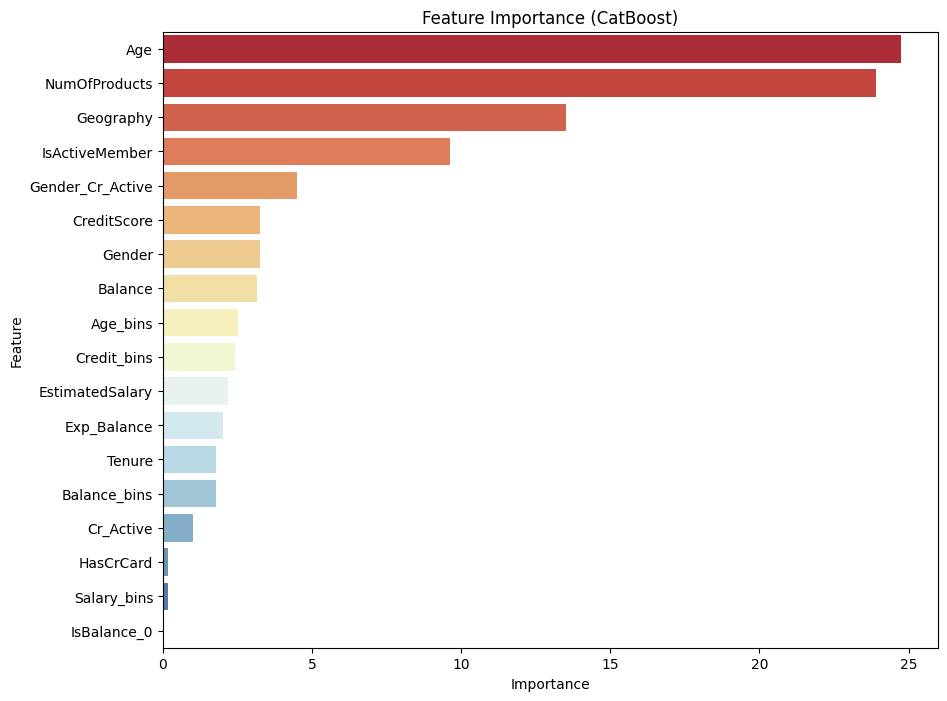

In [76]:
# Extract feature importance
feature_importance = pd.DataFrame()
feature_importance['Feature'] = X.columns
feature_importance['Importance'] = cbm.feature_importances_

# Sort features based on importance
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

# Visualize feature importance with color gradient
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance, palette='RdYlBu')
plt.title('Feature Importance (CatBoost)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


In [ ]:
# credit_bins = list(range(350,851,50))
# credit_labels = list(range(len(credit_bins)-1))
# pd.cut(df_train['CreditScore'], bins = credit_bins, labels = credit_labels)
# salary_bins = [0, 10000, 50000, 100000, 150000, 175000, 200000]
# salary_labels = list(range(len(salary_bins)-1))
# pd.cut(df['EstimatedSalary'], bins = salary_bins, labels = salary_labels)

0         5
1         1
2         5
3         2
4         1
         ..
164906    3
164907    3
164908    3
164909    2
164910    2
Name: EstimatedSalary, Length: 164911, dtype: category
Categories (6, int64): [0 < 1 < 2 < 3 < 4 < 5]

In [68]:
df_sub = df_copy[df_copy['Label']==1].copy().drop('Label', axis=1)
for i in ['Age', 'CreditScore']:
    q1 = df_sub[i].quantile(.25)
    q3 = df_sub[i].quantile(.75)
    iqr = q3-q1
    low = q1 - 1.5*iqr
    high = q3 + 1.5*iqr
    df_sub = df_sub[(df_sub[i]>=low)&(df_sub[i]<=high)]

df_sub = df_sub.reset_index(drop=True)

In [ ]:
# lets Explore a new features
df_train["IsBalanceZero"] = df_train["Balance"]==0
df_train['Low_salary'] = df_train['EstimatedSalary'].apply(lambda x: 1 if x <= 74850 else 0)
df_train['Mid_salary'] = df_train['EstimatedSalary'].apply(lambda x: 1 if (x <= 118528) & (x > 74850) else 0)
df_train['High_salary'] = df_train['EstimatedSalary'].apply(lambda x: 1 if (x > 118528) else 0)
df_train['Low_Balance'] = df_train['Balance'].apply(lambda x: 1 if (x <= 105223.25) & (x != 0) else 0)
df_train['Mid_Balance'] = df_train['Balance'].apply(lambda x: 1 if (x <= 122314) & (x > 105223.25) else 0)
df_train['High_Balance'] = df_train['Balance'].apply(lambda x: 1 if (x > 122314) else 0)
df_train['HasCard&Active'] = df_train["HasCrCard"] * df_train["IsActiveMember"]
df_train["credit_score_cat"] = pd.cut(df_train["CreditScore"],bins=[0, 450, 650, 750, 850],labels=["very_low", "low", "medium", "high"])


In [ ]:
def objective(trial):
    pass

In [ ]:
len(df_copy[df_copy['Label']==1])-len(df_sub)
df_sub.columns

Index(['CreditScore', 'Age', 'Balance', 'HasCrCard', 'IsActiveMember',
       'EstimatedSalary', 'Is_France', 'Is_Germany', 'Is_Spain', 'Gender_F',
       'No_prd_1', 'No_prd_2', 'No_prd_3', 'No_prd_4', 'Tenure_0', 'Tenure_1',
       'Tenure_2', 'Tenure_3', 'Tenure_4', 'Tenure_5', 'Tenure_6', 'Tenure_7',
       'Tenure_8', 'Tenure_9', 'Tenure_10', 'Exited'],
      dtype='object')

[LightGBM] [Info] Number of positive: 8344, number of negative: 21719
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004486 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 850
[LightGBM] [Info] Number of data points in the train set: 30063, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.277550 -> initscore=-0.956645
[LightGBM] [Info] Start training from score -0.956645


(0.8873404030041694, 0.851096075527397)

1. simple model: (0.8865285439081966, 0.8487803689791624)
1. removing outliers : (0.8873404030041694, 0.851096075527397)
1.

### Save result

In [145]:
res_ = {
    'cluster': [],
    'trial_id':[],
    'roc_auc': [],
    'diff':    [],
    'params':  [],
}
for i in range(len(studies)):
    for trial in studies[i].best_trials:
        res_['cluster'].append(clusters_[i])
        # res_['cluster'].append(-1)
        res_['trial_id'].append(trial.number)
        res_['params'].append(trial.params)
        res_['roc_auc'].append(trial.values[0])
        res_['diff'].append(trial.values[1])


In [146]:
filename = 'output/LGBM_result_7.csv'

result_df = pd.DataFrame(res_)
result_df['test_roc'] = result_df['roc_auc'] + result_df['diff']
ordered_cols = ['cluster', 'trial_id', 'roc_auc', 'test_roc', 'diff', 'params']
result_df = result_df[ordered_cols]
result_df.to_csv(filename,index=False)
result_df.head()

,cluster,trial_id,roc_auc,test_roc,diff,params
0,0,10,0.912909,0.915960,0.003050,"{'factor': 2.931599765885029, 'boosting_type':..."
1,0,20,0.926038,0.916740,-0.009299,"{'factor': 9.747335982854967, 'boosting_type':..."
2,0,31,0.943125,0.912464,-0.030661,"{'factor': 2.797942903417222, 'boosting_type':..."
3,0,35,0.920667,0.917154,-0.003512,"{'factor': 4.22331428105212, 'boosting_type': ..."
4,0,40,0.910482,0.914520,0.004038,"{'factor': 11.551680578631784, 'boosting_type'..."


In [147]:
experiment_name = "LGBM model with cluster"
mlflow.set_experiment(experiment_name)
with mlflow.start_run():
    mlflow.log_artifact(filename)

In [ ]:
# from urllib.parse import urlparse
# tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme
# print(tracking_url_type_store)
# with mlflow.start_run():
#     # Log the dictionary as a table
#     mlflow.log_table(data=res_, artifact_file="LGBM_eval_results.json")

In [ ]:
# dataset = mlflow.data.from_pandas(result_df, source="data.csv")
# with mlflow.start_run():
#     mlflow.log_input(dataset, context="training")

In [ ]:
# # metrics = {"mse": 2500.00, "rmse": 50.00}
# # Log a batch of metrics
# with mlflow.start_run():
#     mlflow.log_metrics(metrics)

In [ ]:
result_df[(result_df['roc_auc']>.90) & (result_df['diff']>-.001)]\
.sort_values(by=['test_roc', 'diff','cluster'], ascending=[False, False, True]).reset_index(drop=True)

,cluster,trial_id,roc_auc,test_roc,diff,params
0,2,200,0.922424,0.924283,0.001859,"{'factor': 2.5713299482774277, 'boosting_type'..."
1,2,154,0.921031,0.924026,0.002995,"{'factor': 2.556489630945057, 'boosting_type':..."
2,2,236,0.919812,0.923979,0.004167,"{'factor': 1.8905470008697065, 'boosting_type'..."
3,2,443,0.921817,0.923832,0.002014,"{'factor': 1.417643082643928, 'boosting_type':..."
4,2,249,0.922582,0.923766,0.001185,"{'factor': 2.016363597240582, 'boosting_type':..."
5,2,277,0.919231,0.923720,0.004490,"{'factor': 2.556489630945057, 'boosting_type':..."
6,2,97,0.922650,0.923600,0.000949,"{'factor': 5.966452382516911, 'boosting_type':..."
7,2,223,0.922650,0.923600,0.000949,"{'factor': 5.966452382516911, 'boosting_type':..."
8,2,241,0.921506,0.923556,0.002050,"{'factor': 2.7418503621617187, 'boosting_type'..."
9,2,348,0.920089,0.923525,0.003436,"{'factor': 2.556489630945057, 'boosting_type':..."


In [ ]:
result_df[(result_df['roc_auc']>.90) & (result_df['diff']>=0)]\
.sort_values(by=['test_roc', 'diff','cluster'], ascending=[False, False, True]).reset_index(drop=True)

,cluster,trial_id,roc_auc,test_roc,diff,params
0,2,313,0.921770,0.924139,0.002369,"{'factor': 2.7747935817922182, 'boosting_type'..."
1,2,477,0.923759,0.924135,0.000376,"{'factor': 1.0187402445290734, 'boosting_type'..."
2,2,458,0.923000,0.924060,0.001060,"{'factor': 1.1417208406547235, 'boosting_type'..."
3,2,344,0.921124,0.923997,0.002873,"{'factor': 1.3269136450625643, 'boosting_type'..."
4,2,472,0.921405,0.923996,0.002591,"{'factor': 2.3155643586786216, 'boosting_type'..."
...,...,...,...,...,...,...
61,0,302,0.906094,0.911850,0.005757,"{'factor': 10.807856243221845, 'boosting_type'..."
62,0,407,0.906298,0.911640,0.005341,"{'factor': 5.935973302634203, 'boosting_type':..."
63,0,488,0.906298,0.911640,0.005341,"{'factor': 5.935973302634203, 'boosting_type':..."
64,0,56,0.904883,0.910654,0.005770,"{'factor': 10.807856243221845, 'boosting_type'..."


### obs-01: Selecting most successful result

In [155]:
cluster_id=2
roc_cut_off = .88
diff_cut_off = 0.00

In [156]:
result_df[(result_df['roc_auc']>roc_cut_off) & (result_df['diff']>=diff_cut_off)&(result_df['cluster']==cluster_id)]\
.sort_values(by=['test_roc', 'diff','cluster'], ascending=[False, False, True])\
.reset_index(drop=True)\
# .drop_duplicates(subset='cluster')

,cluster,trial_id,roc_auc,test_roc,diff,params
0,2,78,0.923490,0.923814,0.000324,"{'factor': 1.0546036170141166, 'boosting_type'..."
1,2,105,0.923490,0.923814,0.000324,"{'factor': 1.0546036170141166, 'boosting_type'..."
2,2,325,0.922487,0.923632,0.001144,"{'factor': 1.0546036170141166, 'boosting_type'..."
3,2,477,0.919744,0.923613,0.003869,"{'factor': 1.0546036170141166, 'boosting_type'..."
4,2,380,0.919929,0.923601,0.003672,"{'factor': 1.0546036170141166, 'boosting_type'..."
5,2,274,0.922999,0.923585,0.000586,"{'factor': 1.0546036170141166, 'boosting_type'..."
6,2,256,0.923200,0.923561,0.000361,"{'factor': 1.0546036170141166, 'boosting_type'..."
7,2,418,0.923020,0.923544,0.000525,"{'factor': 1.0668068575184837, 'boosting_type'..."
8,2,348,0.919961,0.923480,0.003520,"{'factor': 1.894303668107879, 'boosting_type':..."
9,2,188,0.922762,0.923458,0.000696,"{'factor': 6.375141663591453, 'boosting_type':..."


### obs-02: Selecting most confident result

In [157]:
result_df[(result_df['roc_auc']>roc_cut_off) & (result_df['diff']>=diff_cut_off)&(result_df['cluster']==cluster_id)]\
.sort_values(by=['diff', 'test_roc', 'cluster'], ascending=[False, False, True])\
.reset_index(drop=True)\
# .drop_duplicates(subset='cluster')

,cluster,trial_id,roc_auc,test_roc,diff,params
0,2,383,0.912314,0.919373,0.007059,"{'factor': 1.0546036170141166, 'boosting_type'..."
1,2,272,0.912451,0.919432,0.006981,"{'factor': 1.373987578711197, 'boosting_type':..."
2,2,342,0.912451,0.919432,0.006981,"{'factor': 1.373987578711197, 'boosting_type':..."
3,2,395,0.912451,0.919432,0.006981,"{'factor': 1.373987578711197, 'boosting_type':..."
4,2,281,0.914497,0.921453,0.006956,"{'factor': 1.0546036170141166, 'boosting_type'..."
5,2,499,0.914497,0.921453,0.006956,"{'factor': 1.0546036170141166, 'boosting_type'..."
6,2,70,0.914772,0.921157,0.006385,"{'factor': 1.1439182649386521, 'boosting_type'..."
7,2,450,0.914799,0.921167,0.006368,"{'factor': 1.1439182649386521, 'boosting_type'..."
8,2,122,0.915760,0.921220,0.005460,"{'factor': 12.145935999549048, 'boosting_type'..."
9,2,366,0.915760,0.921220,0.005460,"{'factor': 12.145935999549048, 'boosting_type'..."


### obs-03

In [ ]:
result_df[(result_df['cluster'].isin([3,]))&(result_df['diff']>=0)]\
.sort_values(by=['test_roc', 'diff','cluster'], ascending=[False, False, True])\
.reset_index(drop=True)\
# .drop_duplicates(subset='cluster')

,cluster,trial_id,roc_auc,test_roc,diff,params
0,3,134,0.838220,0.838256,0.000036,"{'factor': 4.331773631448752, 'n_estimators': ..."
1,3,451,0.835142,0.837869,0.002726,"{'factor': 5.489111338604212, 'n_estimators': ..."
2,3,3,0.837325,0.837631,0.000307,"{'factor': 53.35902634849362, 'n_estimators': ..."
3,3,481,0.836527,0.837286,0.000758,"{'factor': 1.8085146988856002, 'n_estimators':..."
4,3,192,0.832731,0.836363,0.003632,"{'factor': 5.489111338604212, 'n_estimators': ..."
5,3,57,0.830754,0.834845,0.004091,"{'factor': 1.118743659594458, 'n_estimators': ..."
6,3,127,0.830754,0.834845,0.004091,"{'factor': 1.118743659594458, 'n_estimators': ..."
7,3,87,0.830292,0.834441,0.004149,"{'factor': 5.489111338604212, 'n_estimators': ..."
8,3,453,0.830292,0.834441,0.004149,"{'factor': 5.489111338604212, 'n_estimators': ..."
9,3,53,0.827865,0.832614,0.004750,"{'factor': 1.9003844465019168, 'n_estimators':..."


In [ ]:
result_df.sort_values(by=['diff', 'roc_auc', 'cluster'], ascending=[False, False, True]).reset_index(drop=True)

,cluster,trial_id,roc_auc,diff,params
0,3,269,0.782829,0.010737,"{'boosting_type': 'dart', 'num_leaves': 10, 'm..."
1,3,274,0.791600,0.010393,"{'boosting_type': 'dart', 'num_leaves': 57, 'm..."
2,3,424,0.795963,0.009588,"{'boosting_type': 'gbdt', 'num_leaves': 57, 'm..."
3,3,86,0.796823,0.008735,"{'boosting_type': 'gbdt', 'num_leaves': 35, 'm..."
4,3,414,0.796823,0.008735,"{'boosting_type': 'gbdt', 'num_leaves': 35, 'm..."
...,...,...,...,...,...
460,0,485,0.955081,-0.042080,"{'boosting_type': 'gbdt', 'num_leaves': 53, 'm..."
461,1,478,0.891566,-0.042568,"{'boosting_type': 'gbdt', 'num_leaves': 50, 'm..."
462,1,464,0.891647,-0.042780,"{'boosting_type': 'gbdt', 'num_leaves': 50, 'm..."
463,3,431,0.887340,-0.051377,"{'boosting_type': 'gbdt', 'num_leaves': 35, 'm..."


In [ ]:
result_df[(result_df['roc_auc']>.90) & (result_df['diff']>=0)]\
.sort_values(by=['roc_auc', 'diff','cluster'],
             ascending=[False, False, True]).reset_index(drop=True)

,cluster,trial_id,roc_auc,diff,params
0,2,477,0.923759,0.000376,"{'factor': 1.0187402445290734, 'boosting_type'..."
1,2,165,0.923158,0.000464,"{'factor': 3.2365759224424218, 'boosting_type'..."
2,2,478,0.923066,0.000557,"{'factor': 1.0319222425382257, 'boosting_type'..."
3,2,458,0.923000,0.001060,"{'factor': 1.1417208406547235, 'boosting_type'..."
4,2,271,0.922817,0.001140,"{'factor': 4.257705821748617, 'boosting_type':..."
...,...,...,...,...,...
61,0,488,0.906298,0.005341,"{'factor': 5.935973302634203, 'boosting_type':..."
62,0,302,0.906094,0.005757,"{'factor': 10.807856243221845, 'boosting_type'..."
63,2,362,0.905832,0.007492,"{'factor': 1.0769284485462753, 'boosting_type'..."
64,0,56,0.904883,0.005770,"{'factor': 10.807856243221845, 'boosting_type'..."


In [ ]:
result_df[(result_df['roc_auc']>.90) & (result_df['diff']>=0)]\
.sort_values(by=['diff', 'roc_auc', 'cluster'], ascending=[False, False, True]).reset_index(drop=True)

,cluster,trial_id,roc_auc,diff,params
0,2,362,0.905832,0.007492,"{'factor': 1.0769284485462753, 'boosting_type'..."
1,2,483,0.912501,0.006798,"{'factor': 1.0769284485462753, 'boosting_type'..."
2,2,61,0.913739,0.006762,"{'factor': 1.2699963227808777, 'boosting_type'..."
3,2,157,0.913739,0.006762,"{'factor': 1.2699963227808777, 'boosting_type'..."
4,2,276,0.913754,0.006684,"{'factor': 1.2699963227808777, 'boosting_type'..."
...,...,...,...,...,...
61,2,165,0.923158,0.000464,"{'factor': 3.2365759224424218, 'boosting_type'..."
62,0,208,0.916173,0.000413,"{'factor': 6.857684049535044, 'boosting_type':..."
63,0,398,0.917173,0.000392,"{'factor': 1.2503945541596042, 'boosting_type'..."
64,2,477,0.923759,0.000376,"{'factor': 1.0187402445290734, 'boosting_type'..."


In [ ]:
result_df[(result_df['roc_auc']>.84) & (result_df['diff']>=-.1)]\
.sort_values(by=['roc_auc', 'diff','cluster'], ascending=[False, False, True])\
.reset_index(drop=True).drop_duplicates(subset='cluster')

,cluster,trial_id,roc_auc,diff,params
0,0,495,0.990172,-0.089649,"{'factor': 2.370596527110058, 'boosting_type':..."
2,2,476,0.983221,-0.075971,"{'factor': 1.0769284485462753, 'boosting_type'..."
74,1,495,0.934267,-0.092948,"{'factor': 3.895656941855889, 'boosting_type':..."
114,3,427,0.926739,-0.096250,"{'factor': 1.4513729017473795, 'boosting_type'..."


In [ ]:
result_df[(result_df['roc_auc']>.84) & (result_df['diff']>=-.01)]\
.sort_values(by=['diff', 'roc_auc', 'cluster'], ascending=[False, False, True])\
.reset_index(drop=True).drop_duplicates(subset='cluster')

,cluster,trial_id,roc_auc,diff,params
0,2,362,0.905832,0.007492,"{'factor': 1.0769284485462753, 'boosting_type'..."
7,0,387,0.894127,0.006119,"{'factor': 5.935973302634203, 'boosting_type':..."
71,1,325,0.842083,-0.000195,"{'factor': 1.2204130579284755, 'boosting_type'..."
74,3,334,0.840263,-0.000505,"{'factor': 1.7656324508227885, 'boosting_type'..."


## Parameter collection-1

In [ ]:
cluster_2_params = [
    # roc = 0.9240657352171874, diff= 0.00011902789118800605
    {'boosting_type': 'gbdt', 'num_leaves': 15, 'max_depth': 4, 'learning_rate': 0.09091657407978318, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 10, 'colsample_bytree': 0.4, 'reg_alpha': 0.041521958603006594, 'reg_lambda': 0.07210471671531919, 'importance_type': 'gain'}
    # roc= 0.9112754513607575, diff= 0.007323152485641526
,   {'boosting_type': 'rf', 'num_leaves': 9, 'max_depth': -1, 'learning_rate': 0.08510332624577097, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 20, 'colsample_bytree': 0.67, 'reg_alpha': 0.06725362126111765, 'reg_lambda': 0.05429092907814668, 'importance_type': 'split'}
    # roc= 0.9239448987278573,diff= 0.000161442036744731
,   {'0': 0.7235762882026986, 'boosting_type': 'gbdt', 'num_leaves': 22, 'max_depth': 5, 'learning_rate': 0.05693699434416196, 'objective': 'binary', 'min_split_gain': 0.0001, 'min_child_samples': 20, 'colsample_bytree': 0.4, 'reg_alpha': 0.038928420432854674, 'reg_lambda': 0.03766837744350117, 'importance_type': 'split'}
    # roc = , diff=
,   {'0': 41.041786690670804, '1': 2.449832590255197, 'boosting_type': 'gbdt', 'num_leaves': 62, 'max_depth': 4, 'learning_rate': 0.09955853228819812, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 20, 'colsample_bytree': 0.4, 'reg_alpha': 0.06522131599051277, 'reg_lambda': 0.09198952812455896, 'importance_type': 'split'}


    # roc = 0.9217702534355261, diff = 0.0023688782010539144
,  {'factor': 2.7747935817922182, 'boosting_type': 'gbdt', 'num_leaves': 8, 'max_depth': 4, 'learning_rate': 0.09293178557439581, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 10, 'colsample_bytree': 0.45727142967914347, 'reg_alpha': 0.05347968766682344, 'reg_lambda': 0.01331325730136772, 'importance_type': 'gain'}
    # model with max. confidence
, {'factor': 1.0769284485462753, 'boosting_type': 'rf', 'num_leaves': 8, 'max_depth': 4, 'learning_rate': 0.10501984533038497, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 20, 'colsample_bytree': 0.9027432236973051, 'reg_alpha': 0.0025863520267289304, 'reg_lambda': 0.007832757777275831, 'importance_type': 'gain'}

]
cluster_0_params = [
    # roc= 0.9177773466386229, diff= 9.078919654081918e-05
    {'boosting_type': 'gbdt', 'num_leaves': 8, 'max_depth': 4, 'learning_rate': 0.09682417943289649, 'objective': 'binary', 'min_split_gain': 0.0001, 'min_child_samples': 10, 'colsample_bytree': 0.5, 'reg_alpha': 0.025182914637073717, 'reg_lambda': 0.07728668461117302, 'importance_type': 'gain'}
    # roc= 0.8955720744313763, diff= 0.006730590663823199
,   {'boosting_type': 'gbdt', 'num_leaves': 8, 'max_depth': 5, 'learning_rate': 0.004003904642721662, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 20, 'colsample_bytree': 1.0, 'reg_alpha': 0.04754197958339586, 'reg_lambda': 0.03394868022208027, 'importance_type': 'gain'}
    # roc= 0.9170092440500511,diff= 0.0006999716971926029
,   {'0': 0.5967938305484081, 'boosting_type': 'gbdt', 'num_leaves': 52, 'max_depth': 4, 'learning_rate': 0.05689558709344729, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 20, 'colsample_bytree': 0.4, 'reg_alpha': 0.026997650930494877, 'reg_lambda': 0.09506818088037158, 'importance_type': 'split'}

    # roc = 0.9176282242886432, diff = 0.00027181221200700545
    # best so far
,   {'factor': 2.2681108091569535, 'boosting_type': 'gbdt', 'num_leaves': 14, 'max_depth': 3, 'learning_rate': 0.10702952330181366, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 0.6310262176989199, 'reg_alpha': 0.15670996813201313, 'reg_lambda': 0.004971092133452429, 'importance_type': 'split'}
    # model with max. confidence
,   {'factor': 10.807856243221845, 'boosting_type': 'rf', 'num_leaves': 40, 'max_depth': 3, 'learning_rate': 0.019434127132774627, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 20, 'colsample_bytree': 0.7283748832257498, 'reg_alpha': 0.06424507039441346, 'reg_lambda': 0.016838850788030275, 'importance_type': 'split'}

]



In [ ]:
type(())

tuple

In [ ]:
cluster_3_params = [
    # roc = 0.8356136633110324, # diff = 0.002873109748903313
    {'factor': 1.7656324508227885, 'boosting_type': 'dart', 'num_leaves': 8, 'max_depth': 3, 'learning_rate': 0.12452386781101694, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 30, 'colsample_bytree': 0.4858994668570485, 'reg_alpha': 0.0010053127130300469, 'reg_lambda': 0.001092392417398122, 'importance_type': 'gain'}

]
cluster_1_params = [
    # roc = 0.8025562940423678, # diff = 0.0003496302321037703
    {'factor': 1.1521833087849338, 'boosting_type': 'rf', 'num_leaves': 8, 'max_depth': 3, 'learning_rate': 0.2644054592839818, 'objective': 'binary', 'min_split_gain': 0.0001, 'min_child_samples': 10, 'colsample_bytree': 0.9647724091703611, 'reg_alpha': 0.21879801647122385, 'reg_lambda': 0.7996074668855195, 'importance_type': 'gain'}

]

## Parameter collection-2

In [ ]:
cluster_2_params =[
    # both are confident
    {'factor': 2.556489630945057, 'boosting_type': 'gbdt', 'num_leaves': 9, 'max_depth': 3, 'learning_rate': 0.06445682229396081, 'objective': 'binary', 'min_split_gain': 0.0001, 'min_child_samples': 10, 'colsample_bytree': 0.7918222196506435, 'reg_alpha': 0.008964234063277225, 'reg_lambda': 0.13527783355060266, 'importance_type': 'split'}
,   {'factor': 2.556489630945057, 'boosting_type': 'dart', 'num_leaves': 9, 'max_depth': 3, 'learning_rate': 0.29999293942991606, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 0.7653606224049825, 'reg_alpha': 0.01808089247332734, 'reg_lambda': 0.009003180716283173, 'importance_type': 'split'}
,
]
cluster_0_params =[
    # highest score
    {'factor': 3.9134685124175057, 'boosting_type': 'dart', 'num_leaves': 8, 'max_depth': 3, 'learning_rate': 0.32982793780030584, 'objective': 'binary', 'min_split_gain': 0.0001, 'min_child_samples': 25, 'colsample_bytree': 0.8451658101666913, 'reg_alpha': 0.00242194753923402, 'reg_lambda': 0.0012136106258497797, 'importance_type': 'split'}
    # confident
,   {'factor': 2.6167615732717167, 'boosting_type': 'gbdt', 'num_leaves': 39, 'max_depth': 3, 'learning_rate': 0.028814978408245224, 'objective': 'binary', 'min_split_gain': 0.0001, 'min_child_samples': 25, 'colsample_bytree': 0.8253851373209328, 'reg_alpha': 0.0027971227405117777, 'reg_lambda': 0.009106875074522508, 'importance_type': 'gain'}
,
]

array([0, 1])

## Model

In [132]:
df_merged.drop('Exited',axis=1).iloc[[0,1]]
df_merged['Exited'][[0,1]]

0    0
1    0
Name: Exited, dtype: int64

In [179]:
params_0 = { 'boosting_type': 'dart', 'num_leaves': 10, 'max_depth': 3, 'learning_rate': 0.3073286278005067, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 30, 'colsample_bytree': 0.5364192078959057, 'reg_alpha': 0.0015697007798592042, 'reg_lambda': 0.09631423641379186, 'importance_type': 'split'}
factor_0 = 1.6834918218716741
params_0 = { 'boosting_type': 'dart', 'num_leaves': 57, 'max_depth': 3, 'learning_rate': 0.1335540581067796, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 20, 'colsample_bytree': 0.6523174168898919, 'reg_alpha': 0.0126567525893153, 'reg_lambda': 0.19686187480646122, 'importance_type': 'gain'}
factor_0 = 1.4094778479056236

params_2 = {'boosting_type': 'dart', 'num_leaves': 8, 'max_depth': -1, 'learning_rate': 0.36011023545070286, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 25, 'colsample_bytree': 0.4668320607276686, 'reg_alpha': 0.24625027950827988, 'reg_lambda': 0.0019199836643939443, 'importance_type': 'gain'}
factor_2 = 1.0546036170141166
params_2 = { 'boosting_type': 'dart', 'num_leaves': 63, 'max_depth': 3, 'learning_rate': 0.014493389500300274, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 20, 'colsample_bytree': 0.5256682788105532, 'reg_alpha': 0.004443260554270722, 'reg_lambda': 0.618350134822017, 'importance_type': 'split'}
factor_2 = 1.0546036170141166


models = [
    LGBMClassifier(**params_0, class_weight={0:1,1:factor_0}, random_state=42),
    CatBoostClassifier(iterations=300, learning_rate = .07,cat_features = categorical_cols ,random_state=42),
    LGBMClassifier(**params_2, class_weight={0:1,1:factor_2}, random_state=42),
    CatBoostClassifier(iterations=300, learning_rate = .01,cat_features = categorical_cols ,random_state=42)
]
def processor_1(df, scaler):
    df_processed = preprocessing_method_3(df)
    df_processed[categorical_cols] = df_processed[categorical_cols].astype(int)
    df_scaled = pd.DataFrame(scaler.fit_transform(df_processed[numerical_cols]))
    df_scaled.columns = numerical_cols
    df_merged = pd.concat([df_scaled, df_processed[categorical_cols]], axis=1)
    df_merged['Exited'] = df_processed['Exited']
    df_merged_label = df_merged.copy()
    df_merged_label['Label'] = cluster_model.predict(df_merged_label[cluster_cols])

    predictors = []
    for i in range(4):
        indices = df_merged_label[df_merged_label['Label']==i].index
        # model = LGBMClassifier(**params_0, class_weight={0:1,1:factor_0}, random_state=42)
        model = models[i]
        model.fit(df_merged.drop('Exited',axis=1).iloc[indices],df_merged['Exited'][indices])
        predictors.append(model)
    return scaler, predictors


def processor_2(df, scaler, models):
    df['Exited']=0
    df_processed = preprocessing_method_3(df).drop('Exited',axis=1)
    df_processed[categorical_cols] = df_processed[categorical_cols].astype(int)
    df_scaled = pd.DataFrame(scaler.transform(df_processed[numerical_cols]))
    df_scaled.columns = numerical_cols
    df_merged = pd.concat([df_scaled, df_processed[categorical_cols]], axis=1)
    df_merged_label = df_merged.copy()
    df_merged_label['Label'] = cluster_model.predict(df_merged_label[cluster_cols])

    submission= pd.DataFrame()
    submission['id'] = df['id']
    submission['Exited'] = 0
    for i in range(4):
        print("=======================")
        print(i)
        indices = df_merged_label[df_merged_label['Label']==i].index
        submission['Exited'][indices] = models[i].predict_proba(df_merged.iloc[indices])[:,1]
    return submission



In [168]:
df_merged_label['Label'] = cluster_model.predict(df_merged_label[cluster_cols])
df_merged_label['Label'].value_counts()
indices = df_merged_label[df_merged_label['Label']==0].index
X = df_merged.drop('Exited',axis=1).iloc[indices]
y = df_merged['Exited'][indices]
X.head()

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but KMeans was fitted without feature names



,CreditScore,Age,Balance,EstimatedSalary,Exp_Balance,Geography,Gender,Tenure,NumOfProducts,HasCrCard,IsActiveMember,Credit_bins,Age_bins,Salary_bins,Balance_bins,IsBalance_0,Cr_Active,Gender_Cr_Active
1,0.554,0.202703,0.0,0.247483,0.202831,0,0,1,2,1,1,5,2,2,0,1,1,11
4,0.732,0.202703,0.0,0.075293,0.061718,2,0,5,2,1,1,7,2,1,0,1,1,11
12,0.818,0.716216,0.0,0.465396,0.165071,2,0,9,1,1,1,8,4,4,0,1,1,11
13,0.662,0.391892,0.0,0.364705,0.236434,0,0,5,1,1,1,6,3,3,0,1,1,11
20,0.846,0.229730,0.0,0.437731,0.348033,2,0,9,2,0,1,8,2,4,0,1,0,1


In [170]:
model = LGBMClassifier(**params_0, class_weight={0:1,1:factor_0}, random_state=42)
model.fit(X, y)
model.predict_proba(X)[:,1]

[LightGBM] [Info] Number of positive: 6407, number of negative: 34652
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003857 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 969
[LightGBM] [Info] Number of data points in the train set: 41059, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.206731 -> initscore=-1.344745
[LightGBM] [Info] Start training from score -1.344745


array([0.02608209, 0.02637185, 0.26104864, ..., 0.10940097, 0.10940097,
       0.27331838])

In [131]:
df_processed = preprocessing_method_3(df_train)
df_processed[categorical_cols] = df_processed[categorical_cols].astype(int)
df_scaled = pd.DataFrame(scaler.fit_transform(df_processed[numerical_cols]))
df_scaled.columns = numerical_cols
df_merged = pd.concat([df_scaled, df_processed[categorical_cols]], axis=1)
df_merged['Exited'] = df_processed['Exited']
df_merged_label = df_merged.copy()
df_merged_label['Label'] = cluster_model.predict(df_merged_label[cluster_cols])

lgbm_cols = ['CreditScore', 'Geography', 'Gender',
       'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary',]
for i in [2,]:
    indices = df_merged_label[df_merged_label['Label']==i].index
    model = models[i]
    model.fit(df_merged.drop('Exited',axis=1).iloc[indices],df_merged['Exited'][indices])

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but KMeans was fitted without feature names



[LightGBM] [Info] Number of positive: 8299, number of negative: 40954
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003217 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 689
[LightGBM] [Info] Number of data points in the train set: 49253, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.341570 -> initscore=-0.656307
[LightGBM] [Info] Start training from score -0.656307
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [128]:
df_train.columns

Index(['id', 'CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender',
       'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

In [180]:
scaler =  MinMaxScaler()
s, p = processor_1(df_train, scaler)
resu= processor_2(df_test,s, p)
resu.to_csv("submission.csv", index=False)
resu

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but KMeans was fitted without feature names



[LightGBM] [Info] Number of positive: 6407, number of negative: 34652
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002726 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 969
[LightGBM] [Info] Number of data points in the train set: 41059, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.206731 -> initscore=-1.344745
[LightGBM] [Info] Start training from score -1.344745
0:	learn: 0.6500739	total: 69.9ms	remaining: 20.9s
1:	learn: 0.6142690	total: 123ms	remaining: 18.3s
2:	learn: 0.5830150	total: 167ms	remaining: 16.6s
3:	learn: 0.5568802	total: 211ms	remaining: 15.6s
4:	learn: 0.5353570	total: 252ms	remaining: 14.9s
5:	learn: 0.5179878	total: 295ms	remaining: 14.5s
6:	learn: 0.5024878	total: 339ms	remaining: 14.2s
7:	learn: 0.4891884	total: 377ms	remaining: 13.8s
8:	learn: 0.4783197	total: 427ms	remaining:

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but KMeans was fitted without feature names



1
2
3


,id,Exited
0,165034,0.233415
1,165035,0.851710
2,165036,0.249416
3,165037,0.336735
4,165038,0.316557
...,...,...
110018,275052,0.000000
110019,275053,0.000000
110020,275054,0.000000
110021,275055,0.000000


## Trial - 2

In [ ]:
# Define the objective function for Optuna
import xgboost as xgb
def objective(trial, X_train, Y_train):

    params = {
        'n_estimators'      : 100,
        'max_depth'         : trial.suggest_categorical('max_depth', [0, 4, 5, 6, 8, 10]),
        'max_leaves'        : trial.suggest_int('max_leaves', 0, 64),
        # 'max_bin'           : trial.suggest_int('max_bin', 16, 128, log=True),
        'grow_policy'       : trial.suggest_categorical('grow_policy', ['lossguide','depthwise']), # ['depthwise', 'lossguide']
        'learning_rate'     : trial.suggest_float('learning_rate', 0.001, 0.1,log=True),
        'objective'         : trial.suggest_categorical('objective', ['binary:logistic'] ),
        'booster'           : trial.suggest_categorical('booster', ['gbtree', 'gblinear', 'dart']),

        # 'tree_method'       : trial.suggest_categorical('tree_method', ['exact', 'approx', 'hist']),
        # 'updater'           : trial.suggest_categorical('updater', ['grow_colmaker', 'refresh', 'prune']),

        'gamma'             : trial.suggest_categorical('gamma', [0, 1e-4, 1e-3, 1e-1] ),
        'min_child_weight'  : trial.suggest_categorical('min_child_weight', [0, .001, .01, .1, 1, 2, 5]),
        'max_delta_step'    : trial.suggest_categorical('max_delta_step', [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]),
        'subsample'         : trial.suggest_categorical('subsample', [.5, .8, .9, 1]),

        # 'colsample_bytree'  : trial.suggest_categorical('colsample_bytree',[ .25, .4, .5, .67, .75, .8, .9, 1.0]),
        # 'colsample_bylevel' : trial.suggest_categorical('colsample_bylevel',[ .25, .4, .5, .67, .75, .8, .9, 1.0]),
        # 'colsample_bynode'  : trial.suggest_categorical('colsample_bynode',[ .25, .4, .5, .67, .75, .8, .9, 1.0]),

        'reg_alpha'         : trial.suggest_float('reg_alpha', 0, .1 ),
        'reg_lambda'        : trial.suggest_float('reg_lambda', 0, .1 ),
        'scale_pos_weight'  : trial.suggest_float('scale_pos_weight', 1, 10, log=True),
        # 'importance_type'   : trial.suggest_categorical('importance_type', ['gain', 'weight', 'cover', 'total_gain', 'total_cover'] ),
    }

    Xtrain, Xtest, ytrain, ytest = train_test_split(X_train,Y_train, test_size=.3,random_state= 131)
    # clf = XGBClassifier(random_state=42, **params)
    # early_stop = xgb.callback.EarlyStopping(
    #     rounds=2, metric_name='auc', data_name='Validation_0', save_best=True
    # )
    # clf = xgb.XGBClassifier(random_state=42, eval_metric='auc', callbacks=[early_stop], **params)
    clf = xgb.XGBClassifier(random_state=42, eval_metric='auc', **params)

    roc_auc, diff = 0, -np.inf
    try:
        clf.fit(Xtrain, ytrain);
        y_prob = clf.predict_proba(Xtrain)[:, 1]
        roc_auc = roc_auc_score(ytrain, y_prob)
        diff = roc_auc_score(ytest, clf.predict_proba(Xtest)[:, 1]) - roc_auc
    except Exception as e:
        print(e)

    return roc_auc, diff


In [ ]:
scaler_2 = MinMaxScaler()
Xtrain = scaler_2.fit_transform(df_copy.drop(['Exited', 'Label'], axis=1))
ytrain = df_copy['Exited']

In [ ]:
studies = []
for i in [1, 3]:
    indices = df_copy[df_copy['Label']==i].index
    # Create an Optuna study and optimize the objective function
    study = optuna.create_study(directions= ['maximize',  'maximize'] )
    study.optimize(lambda trial: objective(trial,Xtrain[indices], ytrain[indices]), n_trials=200)

    studies.append(study)

[I 2024-01-29 06:58:05,289] A new study created in memory with name: no-name-d3994db9-9e2a-44c6-a771-a31df062a121
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning:

[06:58:05] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "grow_policy", "max_delta_step", "max_depth", "max_leaves", "min_child_weight", "subsample" } are not used.


[I 2024-01-29 06:58:06,976] Trial 0 finished with values: [0.6927196413025289, -0.00214860172085074] and parameters: {'max_depth': 4, 'max_leaves': 26, 'grow_policy': 'lossguide', 'learning_rate': 0.014417358867363832, 'objective': 'binary:logistic', 'booster': 'gblinear', 'gamma': 0.001, 'min_child_weight': 0, 'max_delta_step': 0, 'subsample': 0.9, 'reg_alpha': 0.0765810862130375, 'reg_lambda': 0.054575528115719744, 'scale_pos_weight': 2.2158004657380523}. 
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning:

[06:58:07] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "grow_policy"

KeyboardInterrupt: 

In [ ]:
res_ = {
    'cluster': [],
    'trial_id':[],
    'roc_auc': [],
    'diff':    [],
    'params':  [],
}
for i in range(n_clusters):
    for trial in studies[i].best_trials:
        res_['cluster'].append(i)
        res_['trial_id'].append(trial.number)
        res_['params'].append(trial.params)
        res_['roc_auc'].append(trial.values[0])
        res_['diff'].append(trial.values[1])

result_df = pd.DataFrame(res_)
result_df.head()

In [ ]:
result_df[(result_df['roc_auc']>.84) & (result_df['diff']>=0)]\
.sort_values(by=['roc_auc', 'diff','cluster'], ascending=[False, False, True])\
.reset_index(drop=True).drop_duplicates(subset='cluster')

In [ ]:
result_df[(result_df['roc_auc']>.84) & (result_df['diff']>=-.01)]\
.sort_values(by=['diff', 'roc_auc', 'cluster'], ascending=[False, False, True])\
.reset_index(drop=True).drop_duplicates(subset='cluster')

In [ ]:
cluster_2_params = [
    # roc = 0.9240657352171874, diff= 0.00011902789118800605
    {'boosting_type': 'gbdt', 'num_leaves': 15, 'max_depth': 4, 'learning_rate': 0.09091657407978318, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 10, 'colsample_bytree': 0.4, 'reg_alpha': 0.041521958603006594, 'reg_lambda': 0.07210471671531919, 'importance_type': 'gain'}
    # roc= 0.9112754513607575, diff= 0.007323152485641526
,   {'boosting_type': 'rf', 'num_leaves': 9, 'max_depth': -1, 'learning_rate': 0.08510332624577097, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 20, 'colsample_bytree': 0.67, 'reg_alpha': 0.06725362126111765, 'reg_lambda': 0.05429092907814668, 'importance_type': 'split'}
    # roc= 0.9239448987278573,diff= 0.000161442036744731
,   {'0': 0.7235762882026986, 'boosting_type': 'gbdt', 'num_leaves': 22, 'max_depth': 5, 'learning_rate': 0.05693699434416196, 'objective': 'binary', 'min_split_gain': 0.0001, 'min_child_samples': 20, 'colsample_bytree': 0.4, 'reg_alpha': 0.038928420432854674, 'reg_lambda': 0.03766837744350117, 'importance_type': 'split'}
    # roc = , diff=
,   {'0': 41.041786690670804, '1': 2.449832590255197, 'boosting_type': 'gbdt', 'num_leaves': 62, 'max_depth': 4, 'learning_rate': 0.09955853228819812, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 20, 'colsample_bytree': 0.4, 'reg_alpha': 0.06522131599051277, 'reg_lambda': 0.09198952812455896, 'importance_type': 'split'}

,
                    ]
cluster_0_params = [
    # roc= 0.9177773466386229, diff= 9.078919654081918e-05
    {'boosting_type': 'gbdt', 'num_leaves': 8, 'max_depth': 4, 'learning_rate': 0.09682417943289649, 'objective': 'binary', 'min_split_gain': 0.0001, 'min_child_samples': 10, 'colsample_bytree': 0.5, 'reg_alpha': 0.025182914637073717, 'reg_lambda': 0.07728668461117302, 'importance_type': 'gain'}
    # roc= 0.8955720744313763, diff= 0.006730590663823199
,   {'boosting_type': 'gbdt', 'num_leaves': 8, 'max_depth': 5, 'learning_rate': 0.004003904642721662, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 20, 'colsample_bytree': 1.0, 'reg_alpha': 0.04754197958339586, 'reg_lambda': 0.03394868022208027, 'importance_type': 'gain'}
    # roc= 0.9170092440500511,diff= 0.0006999716971926029
,   {'0': 0.5967938305484081, 'boosting_type': 'gbdt', 'num_leaves': 52, 'max_depth': 4, 'learning_rate': 0.05689558709344729, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 20, 'colsample_bytree': 0.4, 'reg_alpha': 0.026997650930494877, 'reg_lambda': 0.09506818088037158, 'importance_type': 'split'}

]

## Second order clustering

In [ ]:
scaler_2 = MinMaxScaler()
Xtrain = pd.DataFrame(scaler_2.fit_transform(df.drop(['Exited'], axis=1)))
Xtrain.columns = df.columns[:-1]
ytrain = df['Exited']

In [ ]:
Xtrain['Label'] = df_copy['Label']

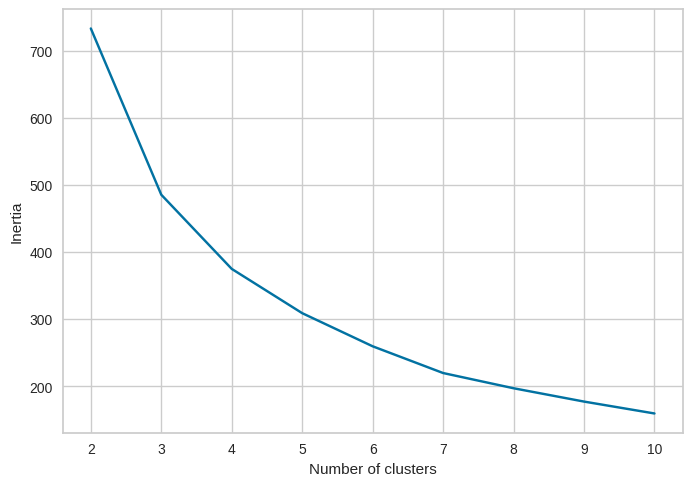

In [ ]:
num_clusters = list(np.arange(2,11))
inertia_list = []
cluster_cols = [
                # 'CreditScore',
                'Age',
                # 'Balance',
                'EstimatedSalary'
                ]
train_x = Xtrain[(Xtrain['Label']==3)][cluster_cols]
for i in num_clusters:
    model = KMeans(n_clusters=i,n_init= 3, max_iter=1000,random_state=151)
    model.fit(train_x)
    inertia_list.append(model.inertia_)

plt.plot(num_clusters, inertia_list)
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
# plt.grid()
plt.show()

## Trial - 3

In [ ]:
from pycaret.anomaly import *
import pycaret.anomaly as pa

In [ ]:
s = setup(Xtrain, session_id = 123)

,Description,Value
0,Session id,123
1,Original data shape,"(164911, 25)"
2,Transformed data shape,"(164911, 25)"
3,Numeric features,25
4,Preprocess,True
5,Imputation type,simple
6,Numeric imputation,mean
7,Categorical imputation,mode
8,CPU Jobs,-1
9,Use GPU,False


In [ ]:
exp = AnomalyExperiment()
exp.setup(Xtrain, session_id = 123)

,Description,Value
0,Session id,123
1,Original data shape,"(164911, 25)"
2,Transformed data shape,"(164911, 25)"
3,Numeric features,25
4,Preprocess,True
5,Imputation type,simple
6,Numeric imputation,mean
7,Categorical imputation,mode
8,CPU Jobs,-1
9,Use GPU,False


In [ ]:
models()

NameError: name 'models' is not defined

In [ ]:
list_models = list(models().index)
anomaly_results = []
for model_name in list_models:
    print("=============================================================")
    print(model_name)
    print("=============================================================")
    temp = create_model(model_name)
    result = assign_model(temp)
    anomaly_results.append(result)
    print(classification_report(df_copy['Exited'], result.Anomaly ))


abod


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.80      0.96      0.87    130002
           1       0.41      0.10      0.16     34909

    accuracy                           0.78    164911
   macro avg       0.61      0.53      0.52    164911
weighted avg       0.72      0.78      0.72    164911

cluster


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.79      0.95      0.86    130002
           1       0.25      0.06      0.10     34909

    accuracy                           0.76    164911
   macro avg       0.52      0.51      0.48    164911
weighted avg       0.68      0.76      0.70    164911

cof


,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,20:09:09
Status,. . . . . . . . . . . . . . . . . .,Fitting 0.05 Fraction
Estimator,. . . . . . . . . . . . . . . . . .,Connectivity-Based Local Outlier


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       1.0
           1       0.00      0.00      0.00       1.0

    accuracy                           0.00       2.0
   macro avg       0.00      0.00      0.00       2.0
weighted avg       0.00      0.00      0.00       2.0



In [ ]:
import pyod

## Finding outproblems with cluster 1 and 3

In [ ]:
view_cols = ['CreditScore', 'Age', 'Balance', 'HasCrCard','IsActiveMember', 'EstimatedSalary', 'Exited']
df_copy[(df_copy['Label']==1)&(df_copy['Exited']==1)][view_cols]

,CreditScore,Age,Balance,HasCrCard,IsActiveMember,EstimatedSalary,Exited
5,588,36.0,131778.58,1.0,0.0,136024.31,1
18,645,55.0,120105.43,1.0,0.0,125083.29,1
19,559,61.0,153711.26,0.0,1.0,180890.40,1
34,749,50.0,132576.25,1.0,0.0,125939.18,1
42,684,31.0,142293.54,1.0,0.0,146650.60,1
...,...,...,...,...,...,...,...
164781,650,33.0,94464.81,1.0,0.0,121485.10,1
164838,683,42.0,118839.60,1.0,0.0,158816.49,1
164872,571,42.0,118829.03,0.0,0.0,175043.69,1
164874,543,43.0,134542.73,1.0,0.0,172363.52,1


In [ ]:
df_copy[(df_copy['Label']==1)&(df_copy['Exited']==0)][view_cols]

,CreditScore,Age,Balance,HasCrCard,IsActiveMember,EstimatedSalary,Exited
9,583,40.0,81274.33,1.0,1.0,170843.07,0
10,599,27.0,161801.47,1.0,0.0,109184.24,0
17,636,36.0,117559.05,1.0,0.0,111573.30,0
22,553,43.0,85200.82,1.0,0.0,160574.09,0
35,413,28.0,130969.77,1.0,1.0,158891.79,0
...,...,...,...,...,...,...,...
164885,679,47.0,127545.94,1.0,1.0,144880.81,0
164891,676,29.0,139825.34,1.0,1.0,116672.02,0
164892,586,48.0,118022.74,0.0,0.0,180593.11,0
164893,461,24.0,117412.34,1.0,0.0,177784.20,0


In [ ]:
len(df_copy[(df_copy['Label']==1)&(df_copy['Exited']==0)][view_cols]), len(df_copy[(df_copy['Label']==1)&(df_copy['Exited']==1)][view_cols])

(29513, 11390)

In [ ]:
scaler_2 = MinMaxScaler()
_d = df_copy[(df_copy['Label']==1)].copy()
Xtrain = scaler_2.fit_transform(_d.drop(['Exited', 'Label'], axis=1))
ytrain = _d['Exited']

In [ ]:
# iforest = IForest(contamination=.27)
params = {'n_estimators': 100, 'max_samples': 0.12175121790858714,
          'contamination': 0.26032537813143364,
          'max_features': 0.22754531957061663, 'bootstrap': False}
# iforest = IForest(**params, random_state=42)
iforest = GMM(contamination=.2)
iforest.fit(Xtrain)

GMM(contamination=0.2, covariance_type='full', init_params='kmeans',
  max_iter=100, means_init=None, n_components=1, n_init=1,
  precisions_init=None, random_state=None, reg_covar=1e-06, tol=0.001,
  warm_start=False, weights_init=None)

In [ ]:
np.array(ytrain)

array([1, 0, 0, ..., 0, 0, 1])

In [ ]:
y_pred = iforest.predict(Xtrain)
y_pred

array([0, 0, 1, ..., 0, 0, 0])

In [ ]:
y_score = iforest.decision_function(Xtrain)
y_score

array([-18.76101286, -17.04107034, -13.77234223, ..., -14.58320596,
       -18.58647587, -17.06642373])

In [ ]:
roc_auc_score( ytrain, y_score )

0.5138024427383632

In [ ]:
print(classification_report(ytrain,y_pred))
print(confusion_matrix(ytrain,y_pred))
print(roc_auc_score(ytrain,y_pred))

              precision    recall  f1-score   support

           0       0.73      0.75      0.74     29513
           1       0.29      0.28      0.28     11390

    accuracy                           0.61     40903
   macro avg       0.51      0.51      0.51     40903
weighted avg       0.61      0.61      0.61     40903

[[21999  7514]
 [ 8256  3134]]
0.5102769878020152


In [ ]:
roc_auc_score(ytrain,iforest.predict_proba(Xtrain)[:,0])
# roc_auc_score([0, 1],[0, 1])

## Possible best outlier detection model

In [ ]:
# Unsupervised algorithm
from pyod.models.iforest import IForest
from pyod.models.auto_encoder import AutoEncoder
from pyod.models.knn import KNN
from pyod.models.gmm import GMM
from pyod.models.ecod import ECOD
from pyod.models.abod import ABOD
from pyod.models.cof import COF
from pyod.models.anogan import AnoGAN

# supervised algorithm
from pyod.models.xgbod import XGBOD
from pyod.models.vae import VAE

# Unsupervised algorithm
from pyod.models.cblof import CBLOF
from pyod.models.hbos import HBOS
from pyod.models.lof import LOF
from pyod.models.ocsvm import OCSVM
from pyod.models.mcd import MCD
from pyod.models.sod import SOD
from pyod.models.sos import SOS

from pyod.utils.data import evaluate_print




In [ ]:
list_ano_det_algo = [
    IForest(), KNN(), GMM(), ECOD(), ABOD(),
    # Following consumes high ram, we need memory optimized algorithm
    # COF(), AutoEncoder(), SOD(), SOS(),
    # Time consuming algorithm
    # AnoGAN(), XGBOD(), VAE(),
    CBLOF(), HBOS(), LOF(), OCSVM(), MCD(),

]
res = {
    'algo'      : [],
    'cluster'   : [],
    'train_auc' : [],
    'test_auc'  : [],
    'diff'      : [],
}
for i in [1, ]:
    _scaler_ = MinMaxScaler()
    _d = df_copy[(df_copy['Label']==1)].copy()
    _Xtrain = _scaler_.fit_transform(_d.drop(['Exited', 'Label'], axis=1))
    _ytrain = _d['Exited']
    _x1, _x2, _y1, _y2 = train_test_split(_Xtrain, _ytrain, test_size=.3, random_state= 131)

    for model in list_ano_det_algo:
        print('===========================')
        print(f"{model.__class__.__name__}")
        try:
            model.fit(_x1,_y1)
            z1 = roc_auc_score(_y1, model.decision_function(_x1))
            z2 = roc_auc_score(_y2, model.decision_function(_x2))

            res['algo'].append(model.__class__.__name__)
            res['cluster'].append(i)
            res['train_auc'].append(z1)
            res['test_auc'].append(z2)
            res['diff'].append(z2-z1)
        except Exception as e:
            print("Failed: ",e)

result_df = pd.DataFrame(res)
result_df.head()

XGBOD


/usr/local/lib/python3.10/dist-packages/pyod/models/base.py:430: UserWarning:

y should not be presented in unsupervised learning.

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning:

[06:55:32] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.




VAE
Failed:  The number of neurons should not exceed the number of features


/usr/local/lib/python3.10/dist-packages/pyod/models/base.py:430: UserWarning:

y should not be presented in unsupervised learning.



,algo,cluster,train_auc,test_auc,diff
0,XGBOD,1,0.856369,0.849048,-0.00732


In [ ]:
result_df

,algo,cluster,train_auc,test_auc,diff
0,XGBOD,1,0.856369,0.849048,-0.00732


In [ ]:
studies = []
def objective(trial, X_train, Y_train):
    params = {
        'n_estimators'      : trial.suggest_categorical('n_estimators', [100, 200]),
        'max_samples'       : trial.suggest_float('max_samples', .1, 1, log=True),
        'contamination'     : trial.suggest_float('contamination',.1,.4, log=True),
        'max_features'      : trial.suggest_float('max_features', .1, 1, log=True),
        'bootstrap'         : trial.suggest_categorical('bootstrap', [True, False]),


    }
    clf = IForest(random_state=42, **params)
    Xtrain, Xtest, ytrain, ytest = train_test_split(X_train,Y_train, test_size=.3,random_state= 131)
    roc_auc, diff = 0, -np.inf
    try:
        clf.fit(Xtrain);
        y_prob = clf.predict_proba(Xtrain)[:, 1]
        roc_auc = roc_auc_score(ytrain, y_prob)
        diff = roc_auc_score(ytest, clf.predict_proba(Xtest)[:, 1]) - roc_auc
    except Exception as e:
        print(e)

    return roc_auc, diff

In [ ]:
study = optuna.create_study(directions= ['maximize',  'maximize'] )
study.optimize(lambda trial: objective(trial,Xtrain, ytrain), n_trials=100)
studies.append(study)

In [ ]:
res_ = {
    'cluster': [],
    'trial_id':[],
    'roc_auc': [],
    'diff':    [],
    'params':  [],
}
for trial in studies[0].best_trials:
    res_['cluster'].append(1)
    res_['trial_id'].append(trial.number)
    res_['params'].append(trial.params)
    res_['roc_auc'].append(trial.values[0])
    res_['diff'].append(trial.values[1])

result_df = pd.DataFrame(res_)
result_df.to_csv('output/cluster_1_iforest.csv',index=False)
result_df.head()

,cluster,trial_id,roc_auc,diff,params
0,1,3,0.532432,0.006087,"{'n_estimators': 100, 'max_samples': 0.1217512..."
1,1,23,0.514112,0.007218,"{'n_estimators': 100, 'max_samples': 0.5129659..."
2,1,39,0.489894,0.010777,"{'n_estimators': 100, 'max_samples': 0.6423829..."
3,1,65,0.493950,0.007413,"{'n_estimators': 100, 'max_samples': 0.8389805..."
4,1,94,0.493833,0.007952,"{'n_estimators': 100, 'max_samples': 0.7091492..."


In [ ]:
result_df[(result_df['roc_auc']>.4) & (result_df['diff']>=0)]\
.sort_values(by=['roc_auc', 'diff','cluster'], ascending=[False, False, True])\
.reset_index(drop=True).drop_duplicates(subset='cluster')

,cluster,trial_id,roc_auc,diff,params
0,1,3,0.532432,0.006087,"{'n_estimators': 100, 'max_samples': 0.1217512..."


In [ ]:
result_df[(result_df['roc_auc']>.4) & (result_df['diff']>=0)]\
.sort_values(by=['diff', 'roc_auc', 'cluster'], ascending=[False, False, True])\
.reset_index(drop=True).drop_duplicates(subset='cluster')

,cluster,trial_id,roc_auc,diff,params
0,1,39,0.489894,0.010777,"{'n_estimators': 100, 'max_samples': 0.6423829..."


In [ ]:
scaler_3 = MinMaxScaler()
_d = df_copy[(df_copy['Label']==3)].copy()
Xtrain = scaler_3.fit_transform(_d.drop(['Exited', 'Label'], axis=1))
ytrain = _d['Exited']

## Trial - 4

In [ ]:
# Define the objective function for Optuna
import xgboost as xgb
def objective(trial, X_train, Y_train):

    params = {
        'n_estimators'      : 100,
        'max_depth'         : trial.suggest_categorical('max_depth', [0, 4, 5, 6, 8, 10]),
        'max_leaves'        : trial.suggest_int('max_leaves', 0, 64),
        # 'max_bin'           : trial.suggest_int('max_bin', 16, 128, log=True),
        'grow_policy'       : trial.suggest_categorical('grow_policy', ['lossguide','depthwise']), # ['depthwise', 'lossguide']
        'learning_rate'     : trial.suggest_float('learning_rate', 0.001, 0.1,log=True),
        'objective'         : trial.suggest_categorical('objective', ['binary:logistic'] ),
        'booster'           : trial.suggest_categorical('booster', ['gbtree', 'gblinear', 'dart']),

        # 'tree_method'       : trial.suggest_categorical('tree_method', ['exact', 'approx', 'hist']),
        # 'updater'           : trial.suggest_categorical('updater', ['grow_colmaker', 'refresh', 'prune']),

        'gamma'             : trial.suggest_categorical('gamma', [0, 1e-4, 1e-3, 1e-1] ),
        'min_child_weight'  : trial.suggest_categorical('min_child_weight', [0, .001, .01, .1, 1, 2, 5]),
        'max_delta_step'    : trial.suggest_categorical('max_delta_step', [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]),
        'subsample'         : trial.suggest_categorical('subsample', [.5, .8, .9, 1]),

        # 'colsample_bytree'  : trial.suggest_categorical('colsample_bytree',[ .25, .4, .5, .67, .75, .8, .9, 1.0]),
        # 'colsample_bylevel' : trial.suggest_categorical('colsample_bylevel',[ .25, .4, .5, .67, .75, .8, .9, 1.0]),
        # 'colsample_bynode'  : trial.suggest_categorical('colsample_bynode',[ .25, .4, .5, .67, .75, .8, .9, 1.0]),

        'reg_alpha'         : trial.suggest_float('reg_alpha', 0, .1 ),
        'reg_lambda'        : trial.suggest_float('reg_lambda', 0, .1 ),
        'scale_pos_weight'  : trial.suggest_float('scale_pos_weight', 1, 10, log=True),
        # 'importance_type'   : trial.suggest_categorical('importance_type', ['gain', 'weight', 'cover', 'total_gain', 'total_cover'] ),
    }

    Xtrain, Xtest, ytrain, ytest = train_test_split(X_train,Y_train, test_size=.3,random_state= 131)
    # clf = XGBClassifier(random_state=42, **params)
    # early_stop = xgb.callback.EarlyStopping(
    #     rounds=2, metric_name='auc', data_name='Validation_0', save_best=True
    # )
    # clf = xgb.XGBClassifier(random_state=42, eval_metric='auc', callbacks=[early_stop], **params)
    clf = xgb.XGBClassifier(random_state=42, eval_metric='auc', **params)

    roc_auc, diff = 0, -np.inf
    try:
        clf.fit(Xtrain, ytrain);
        y_prob = clf.predict_proba(Xtrain)[:, 1]
        roc_auc = roc_auc_score(ytrain, y_prob)
        diff = roc_auc_score(ytest, clf.predict_proba(Xtest)[:, 1]) - roc_auc
    except Exception as e:
        print(e)

    return roc_auc, diff


## Submit

In [181]:
!kaggle competitions submit -c playground-series-s4e1 -f submission.csv -m "Complex clustering and CatBooster, and LGBM model"

100% 2.80M/2.80M [00:02<00:00, 1.06MB/s]
Successfully submitted to Binary Classification with a Bank Churn Dataset 